## Projeto para Disciplina de Mineração de Dados  
## Aplicação de Técnica de Classificação para Solução de Captcha  Sonoro
### Programa de Pós Graduação em Computação UFABC - 2º Quadrimestre de 2018
#### Integrantes:
Erick Fernandes da Cruz <br>
Gustavo Borges Lugoboni


### 1 - Introdução
Segundo o artigo de Gantz (2012) o crescimento de na quantidade de dados ocorre de forma exponencial e até 2020 poderemos chegar a quantidade de 40 trilhões de Gigabytes de dados, e neste contexto as técnicas de Mineração de Dados (Data Mining) apresentam ferramentas para encontrarmos relações desconhecidas e para sumarizar os dados em formas que sejam compreensíveis e úteis, o que dificilmente seria feito sem a utilização de técnicas adequadas.

Durante a disciplina foram estudadas diversas técnicas utilizadas em Mineração de Dados, algoritmos de regressão e classificação, porém o presente projeto se limita ao estudo dos algoritmos de classificação. Os problemas de classificação tem como objetivo principal identificar qual a classe mais que um novo dado deve ser classificado.

Neste trabalho utilizaremos algoritmos de classificação para classificar de forma adequada um conjunto de arquivos wav que possuem em 4 caracteres sendo falados por arquivo, onde os possíveis caracteres são a,b,c,d,h,m,n,x,6,7. Para isso teremos um conjunto de arquivos treinamento e um conjunto de arquivos de validação. Nosso objetivo é através da utilização de um algoritmo de classificação conseguir inferir corretamente as letras que estão contidas em cada um dos arquivos wav do conjunto de validação.

Para o desenvolvimento do projeto foi utilizada a linguagem Python (Versão 3.5.2) e para auxiliar o desenvolvimento utilizamos algumas bibliotecas para auxiliar no desenvolvimento. Dentre essa bibliotecas utilizamos a Numpy e Scipy que auxilia em vários cálculos realizados e manipulações de Arrays, a biblioteca Librosa que apresenta ferramentas para manipulação de arquivos de aúdio, a bilioteca Sklearn que possui um grande número de técnicas de Mineração de Dados que foram aproveitadas neste projeto e a bilioteca Bokeh que possui funções que auxiliaram na geração dos histogramas que utilizamos em nossa análise.

No trecho de código a seguir é possível realizar as importações das bibliotecas que serão utilizadas no decorrer do projeto.

In [1]:
#Bibliotecas utilizadas

import os
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import IPython.display as ipd
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn import tree
from sklearn.externals import joblib

from bokeh.models import CDSView, ColumnDataSource, GroupFilter
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.io import output_notebook

### 2 - Análise Exploratória
A base de dados estudada possuía alguns problemas que necessitaram de certas transformações para facilitar a obtenção dos atributos. A primeira etapa segmentar o arquivo wav de forma a obter 4 partes correspondentes a cada carácter do arquivo. Para isso inicialmente separamos o arquivo em 4 partes iguais, visto que a duração dos arquivos de áudio que compunham o captcha possuíam tamanhos iguais.

Após esta separação, a próximo etapa foi separar os trechos onde apenas continha ruído de fundo do trecho que o carácter é falada. Para isto segmentamos o áudio em pequenos subconjuntos e utilizamos o pico de frequência do primeiro subconjunto mais o desvio padrão como frequência de corte, considerando que sempre o primeiro subconjunto será um trecho com apenas ruído. Utilizamos esta frequência de corte para verificar os subconjuntos que possuíam um frequência superior a ela e unimos os conjuntos com estas características que estivessem a uma distancia de no máximo 2 subconjuntos. Com os subconjuntos unidos verificamos qual a união de subconjuntos possuía o maior número de elementos e consideramos esta como a parte correspondente ao carácter.

Após identificarmos o exato pedaço correspondente de cada carácter, a transformação seguinte teve como objetivo remover o ruído de fundo que estava presente no próprio carácter. Para isso subtraímos da região correspondente as frequências dos caracteres por uma frequência de corte correspondente ao ruído de fundo de cada áudio.

Por fim verificamos que devido a diferença de volume dos áudios, apesar de um mesmo carácter falado por duas pessoas diferentes possuir uma curva de frequência semelhante, os valores referentes a frequência se mostravam bem distintos. Para contornamos este problema normalizamos os valores de frequência correspondentes a cada carácter entre -1 e 1.

A seguir é possível verificar o código utilizado para a realização das manipulações citadas acima, sendo este primeiro trecho corresponde aos Arrays que foram criados para obter respectivamente a onda e ao char de cada carácter do conjunto de treinamento.

In [2]:
WaveLetters = list()
Y = list()

A função a seguir recebe um Array com os valores de frequências correspondentes a cada carácter e devolve como saída o mesmo Array com os valores de frequência normalizados entre -1 e 1.

In [3]:
def normalizar(data) :
    
    #Definir valor máximo
    maximo = 0;
    if (max(data) > np.absolute(min(data))):
        maximo = max(data)
    else: 
        maximo = np.absolute(min(data))
    
    #Normalizar vetor entre -1 e 1
    x = 0
    while(x < len(data)):
        data[x] = data[x]/maximo
        x += 1
    
    return data

A função separar_caracter recebe como entrada o Array correspondente ao captcha contendo 4 caracteres e o Array onde estão sendo armazenadas os caracteres separados. O está função realiza o processo de separar os caracteres do arquivo, remover o ruído contido no carácter e aplicar a função de normalização mostrada anteriormente, e por fim armazena os 4 segmentos corresponde aos caracteres em um Array que irá armazenar as saídas de todos os captchas de cada conjunto.

In [4]:
def separar_caracter(data, destination_array) :

    #Separar Array data em 4 conjuntos 
    splited = []
    for i in range(4):
        start = int(i*len(data)/4)
        end = int((i+1)*len(data)/4)
        splited.append(data[start:end])
    
    frame_lenght = 3150 # frames de fs/14 aprox 0.5s
    
    chars_values = list()
    
    for audioPart in range(4):
        initial_frame_pos = 0 
        frames_list = list()

        #Separando os frames
        while initial_frame_pos < len(splited[audioPart]):
            frames_list.append(splited[audioPart][initial_frame_pos : initial_frame_pos+frame_lenght])
            initial_frame_pos += frame_lenght

        #Filtrando por amplitude maxima do frame inicial (supondo que é sempre ruido ou silencio) + desvio padrao
        amp_cat_values = list()

        max_values = [max(x) for x in frames_list] 
        max_values.sort()
        max_value_mean = np.mean(max_values)
        max_value_std = np.std(max_values)

        for frame in frames_list:
            frame_max = max(abs(frame))
            #se o frame tiver amplitude maxima <= a inicial std consideramos como um trecho de audio valido      
            if frame_max <= max_value_mean + max_value_std**2 :  
                if frame_max >= max_value_mean - max_value_std**2 :
                    amp_cat_values.append("max")
                else:
                    amp_cat_values.append("min")
            else:
                amp_cat_values.append("max")

        # guardando os idices dos frames de frames_list onde a amplitude equivale a um valor de audio valido
        max_indexes = list()
        index_list = range(0, len(amp_cat_values))
        amp_cat_values = list(zip(index_list, amp_cat_values))

        max_indexes = [index for index in amp_cat_values if index[1] is "max"]

        #agrupando por indices a uma distancia <= 2 posições (separando os caracteres)
        chars_indexes = list()
        new_frame = list()
        new_frame.append(max_indexes[0])
        for frame_info in max_indexes:
            if frame_info[0] - new_frame[-1][0] <= 2:
                if frame_info not in new_frame:
                    new_frame.append(frame_info)
            else:
                chars_indexes.append(new_frame)
                new_frame = list()
                new_frame.append(frame_info)
            if frame_info is max_indexes[-1]:
                chars_indexes.append(new_frame)

        # filtrando os indices no vetor de frames_list (contendo as amostras originais) para separar as amostras de
        # caracteres validos
        initialBigger = 0
        lastBigger = 0

        diferenca = 0

        for index in chars_indexes:
            initial = index[0][0] 
            last = index[-1][0] 

            if (last - initial) > diferenca:
                initialBigger = initial
                lastBigger = last

        if (initialBigger != 0):
            initialBigger = initialBigger - 1
    
        #Obter uma frequencia de corte baseada em um conjunto que possui apenas o ruído
        
        corte = 0
        if (initialBigger != 0):
            corte = max(frames_list[initialBigger - 1])
        else:     
            corte = max(frames_list[lastBigger + 2])
            
        value = np.hstack(frames_list[initialBigger:lastBigger+1])
        
        #Remover o ruído com base no corte obtido anteriormente
        variavel = 0
        while(variavel < len(value)):
            if value[variavel] < 0:
                if corte > np.absolute(value[variavel]):
                    value[variavel] = 0
                else: 
                    value[variavel] = value[variavel] + corte
            else: 
                if corte > value[variavel]:
                    value[variavel] = 0
                else:
                    value[variavel] = value[variavel] - corte
            
            variavel = variavel+1
        
        destination_array.append(normalizar(value))

Com as funções criadas, o próximo passo era aplicar a função por toda a base de treinamente. O trecho de código a seguir acessa a pasta da base de treinamento e aplica a função de separação de caracteres, além de separarmos o char correspondente a cada carácter do nome do arquivo e armazená-los no Array Y.

In [5]:
for root, dirs, files in os.walk("base_treinamento_I/"):  
    
    for filename in files:
        
        data, fs = librosa.load('base_treinamento_I/' + filename, None)
        for s in range(4):
            Y.append(filename[s])
            
        separar_caracter(data, WaveLetters)

Após aplicarmos as transformações necessárias para remover a maior parte ruído do áudio em conjunto com a seguimentação dos caracteres realizada, a etapa seguinte foi o levantamento de possíveis atributos para utilizarmos nos algoritmos de classificação.

Dentre os atributos que utilizamos podemos citar a duração do áudio, batidas por minuto, média da frequência, média do centroide, quartis e média das frequências por segmento do áudio. A extração desses atributos podem ser visualizados no código abaixo. 

In [6]:
#extraindo atributos
duration = np.array([len(x)/fs for x in WaveLetters])

tempo_beat = [librosa.beat.beat_track(y=x, sr=fs) for x in WaveLetters]
tempo = np.array([x[0] for x in tempo_beat])
beat_frame = np.array([x[1] for x in tempo_beat])

mean_percussive = np.array([librosa.effects.hpss(x)[1].mean() for x in WaveLetters])

#sftf = [librosa.stft(x) for x in WaveLetters]
fourier = [np.fft.fft(x) for x in WaveLetters]
mean_freq = np.array([np.abs(x).mean() for x in fourier])

mean_centroid = [librosa.feature.spectral_centroid(y=x, sr=fs).mean() for x in WaveLetters]

freq_QT50 = [np.percentile(np.abs(x), 50) for x in fourier]
freq_QT75 = [np.percentile(np.abs(x), 75) for x in fourier]
freq_QT25 = [np.percentile(np.abs(x), 25) for x in fourier]

#Médias
mean_0_20 = []
mean_20_40 = []
mean_40_60 = []
mean_60_80 = []
mean_80_100 = []

for x in WaveLetters:
     
    splited = []
    for i in range(5):
        start = int(i*len(x)/5)
        end = int((i+1)*len(x)/5)
        splited.append(x[start:end])
    
    mean_0_20.append(np.mean(np.absolute(splited[0])))
    mean_20_40.append(np.mean(np.absolute(splited[1])))
    mean_40_60.append(np.mean(np.absolute(splited[2])))
    mean_60_80.append(np.mean(np.absolute(splited[3])))
    mean_80_100.append(np.mean(np.absolute(splited[4])))
    
train_base = np.array(list(zip(
    duration,
    tempo, 
    mean_percussive, 
    mean_freq, 
    mean_centroid, 
    freq_QT50, 
    freq_QT75, 
    freq_QT25,
    mean_0_20,
    mean_20_40,
    mean_40_60,
    mean_60_80,
    mean_80_100)))

Após a obtenção dos atributos na base de treinamento, foram realizadas as mesmas etapas de segmentação e tratamento de ruídos na base de validação para que fosse possível obter os mesmos atributos que foram obtidos na base de treinamento.

In [7]:
#carregando base de validação
Array_test = list()
Y_test = list()
for root, dirs, files in os.walk("base_validacao_I/"):  
    
    for filename in files:
        
        data, fs = librosa.load('base_validacao_I/' + filename, None)
        for s in range(4):
            Y_test.append(filename[s])
            
        separar_caracter(data, Array_test)

In [8]:
#extraindo informações
duration_test = np.array([len(x)/fs for x in Array_test])

tempo_beat_test = [librosa.beat.beat_track(y=x, sr=fs) for x in Array_test]
tempo_test = np.array([x[0] for x in tempo_beat_test])
beat_frame_test = np.array([x[1] for x in tempo_beat_test])

mean_percussive_test = np.array([librosa.effects.hpss(x)[1].mean() for x in Array_test])

#sftf_test = [librosa.stft(x) for x in Array_test]
fourier_test = [np.fft.fft(x) for x in Array_test]
mean_freq_test = np.array([np.abs(x).mean() for x in fourier_test])
freq_QT50_test = [np.percentile(np.abs(x), 50) for x in fourier_test]
freq_QT75_test = [np.percentile(np.abs(x), 75) for x in fourier_test]
freq_QT25_test = [np.percentile(np.abs(x), 25) for x in fourier_test]

mean_centroid_test = [librosa.feature.spectral_centroid(y=x, sr=fs).mean() for x in Array_test]

#Médias
mean_0_20_test = []
mean_20_40_test = []
mean_40_60_test = []
mean_60_80_test = []
mean_80_100_test = []

for x in Array_test:
     
    splited = []
    for i in range(5):
        start = int(i*len(x)/5)
        end = int((i+1)*len(x)/5)
        splited.append(x[start:end])
    
    mean_0_20_test.append(np.mean(np.absolute(splited[0])))
    mean_20_40_test.append(np.mean(np.absolute(splited[1])))
    mean_40_60_test.append(np.mean(np.absolute(splited[2])))
    mean_60_80_test.append(np.mean(np.absolute(splited[3])))
    mean_80_100_test.append(np.mean(np.absolute(splited[4])))

test_base = np.array(list(zip(
    duration_test,
    tempo_test, 
    mean_percussive_test, 
    mean_freq_test, 
    mean_centroid_test, 
    freq_QT50_test, 
    freq_QT75_test, 
    freq_QT25_test,
    mean_0_20_test,
    mean_20_40_test,
    mean_40_60_test,
    mean_60_80_test,
    mean_80_100_test)))


### 3 - Metodologia
Após a obtenção de possíveis atributos que poderiamos utilizar da nossa base de dados, realizamos uma análise para verificar qual ou quais os melhores atributos que poderiamos utilizar. Inicialmente separamos a nossa base de treinamento por carácter e geramos histogramas comparando os valores dos atributos obtidos em cada um desses caracteres para verificar se em algum destes atributos erá possível visualizar um padrão relevante.

In [9]:
#Criando bases de cada letra a,b,c,d,h,m,n,x,6,7

a_base = list()
b_base = list()
c_base = list()
d_base = list()
h_base = list()
m_base = list()
n_base = list()
x_base = list()
si_base = list()
se_base = list()
labels = [
    'duration',
    'tempo', 
    'mean_percussive', 
    'mean_freq', 
    'mean_centroid', 
    'freq_QT50', 
    'freq_QT75', 
    'freq_QT25',
    'mean1',
    'mean2',
    'mean3',
    'mean4',
    'mean5']

for i in range(0, len(Y)):
    if Y[i] == 'a':
        a_base.append(train_base[i])
    elif Y[i] == 'b':
        b_base.append(train_base[i])
    elif Y[i] == 'c':
        c_base.append(train_base[i])
    elif Y[i] == 'd':
        d_base.append(train_base[i])
    elif Y[i] == 'h':
        h_base.append(train_base[i])
    elif Y[i] == 'm':
        m_base.append(train_base[i])
    elif Y[i] == 'n':
        n_base.append(train_base[i])
    elif Y[i] == 'x':
        x_base.append(train_base[i])
    elif Y[i] == '6':
        si_base.append(train_base[i])
    elif Y[i] == '7':
        se_base.append(train_base[i])
    else:
        pass

a_base = pd.DataFrame.from_records(a_base, columns=labels)
b_base = pd.DataFrame.from_records(b_base, columns=labels)
c_base = pd.DataFrame.from_records(c_base, columns=labels)
d_base = pd.DataFrame.from_records(d_base, columns=labels)
h_base = pd.DataFrame.from_records(h_base, columns=labels)
m_base = pd.DataFrame.from_records(m_base, columns=labels)
n_base = pd.DataFrame.from_records(n_base, columns=labels)
x_base = pd.DataFrame.from_records(x_base, columns=labels)
si_base = pd.DataFrame.from_records(si_base, columns=labels)
se_base = pd.DataFrame.from_records(se_base, columns=labels)


#Base de teste

a_base_test = list()
b_base_test = list()
c_base_test = list()
d_base_test = list()
h_base_test = list()
m_base_test = list()
n_base_test = list()
x_base_test = list()
si_base_test = list()
se_base_test = list()

for i in range(0, len(Y_test)):
    if Y[i] == 'a':
        a_base_test.append(test_base[i])
    elif Y[i] == 'b':
        b_base_test.append(test_base[i])
    elif Y[i] == 'c':
        c_base_test.append(test_base[i])
    elif Y[i] == 'd':
        d_base_test.append(test_base[i])
    elif Y[i] == 'h':
        h_base_test.append(test_base[i])
    elif Y[i] == 'm':
        m_base_test.append(test_base[i])
    elif Y[i] == 'n':
        n_base_test.append(test_base[i])
    elif Y[i] == 'x':
        x_base_test.append(test_base[i])
    elif Y[i] == '6':
        si_base_test.append(test_base[i])
    elif Y[i] == '7':
        se_base_test.append(test_base[i])
    else:
        pass

a_base_test = pd.DataFrame.from_records(a_base_test, columns=labels)
b_base_test = pd.DataFrame.from_records(b_base_test, columns=labels)
c_base_test = pd.DataFrame.from_records(c_base_test, columns=labels)
d_base_test = pd.DataFrame.from_records(d_base_test, columns=labels)
h_base_test = pd.DataFrame.from_records(h_base_test, columns=labels)
m_base_test = pd.DataFrame.from_records(m_base_test, columns=labels)
n_base_test = pd.DataFrame.from_records(n_base_test, columns=labels)
x_base_test = pd.DataFrame.from_records(x_base_test, columns=labels)
si_base_test = pd.DataFrame.from_records(si_base_test, columns=labels)
se_base_test = pd.DataFrame.from_records(se_base_test, columns=labels)


Histograma mean_freq

In [10]:
output_notebook()

a_mean_freq_hist, edges_a = np.histogram(a_base.mean_freq, density=True)
b_mean_freq_hist, edges_b = np.histogram(b_base.mean_freq, density=True)
c_mean_freq_hist, edges_c = np.histogram(c_base.mean_freq, density=True)
d_mean_freq_hist, edges_d = np.histogram(d_base.mean_freq, density=True)
h_mean_freq_hist, edges_h = np.histogram(h_base.mean_freq, density=True)
m_mean_freq_hist, edges_m = np.histogram(m_base.mean_freq, density=True)
n_mean_freq_hist, edges_n = np.histogram(n_base.mean_freq, density=True)
x_mean_freq_hist, edges_x = np.histogram(x_base.mean_freq, density=True)
si_mean_freq_hist, edges_si = np.histogram(si_base.mean_freq, density=True)
se_mean_freq_hist, edges_se = np.histogram(se_base.mean_freq, density=True)

fig_a_mean_freq_hist = figure(title="a_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_a_mean_freq_hist.quad(top=a_mean_freq_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_b_mean_freq_hist = figure(title="b_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_b_mean_freq_hist.quad(top=b_mean_freq_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_c_mean_freq_hist = figure(title="c_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_c_mean_freq_hist.quad(top=c_mean_freq_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_d_mean_freq_hist = figure(title="d_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_d_mean_freq_hist.quad(top=d_mean_freq_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_h_mean_freq_hist = figure(title="h_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_h_mean_freq_hist.quad(top=h_mean_freq_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_m_mean_freq_hist = figure(title="m_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_m_mean_freq_hist.quad(top=m_mean_freq_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_n_mean_freq_hist = figure(title="n_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_n_mean_freq_hist.quad(top=n_mean_freq_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_x_mean_freq_hist = figure(title="x_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_x_mean_freq_hist.quad(top=x_mean_freq_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_si_mean_freq_hist = figure(title="six_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_si_mean_freq_hist.quad(top=si_mean_freq_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_se_mean_freq_hist = figure(title="seven_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_se_mean_freq_hist.quad(top=se_mean_freq_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_mean_freq_hist, fig_b_mean_freq_hist, fig_c_mean_freq_hist], 
                [fig_d_mean_freq_hist, fig_h_mean_freq_hist, fig_m_mean_freq_hist], 
                [fig_n_mean_freq_hist, fig_x_mean_freq_hist, fig_si_mean_freq_hist], 
                [fig_se_mean_freq_hist]], title='MEAN_FREQ', notebook_handle=True)
show(plt)

Loading BokehJS ...

Histograma freq_QT50

In [11]:
#freq_QT50 histograma
a_freq_QT50_hist, edges_a = np.histogram(a_base.freq_QT50, density=True)
b_freq_QT50_hist, edges_b = np.histogram(b_base.freq_QT50, density=True)
c_freq_QT50_hist, edges_c = np.histogram(c_base.freq_QT50, density=True)
d_freq_QT50_hist, edges_d = np.histogram(d_base.freq_QT50, density=True)
h_freq_QT50_hist, edges_h = np.histogram(h_base.freq_QT50, density=True)
m_freq_QT50_hist, edges_m = np.histogram(m_base.freq_QT50, density=True)
n_freq_QT50_hist, edges_n = np.histogram(n_base.freq_QT50, density=True)
x_freq_QT50_hist, edges_x = np.histogram(x_base.freq_QT50, density=True)
si_freq_QT50_hist, edges_si = np.histogram(si_base.freq_QT50, density=True)
se_freq_QT50_hist, edges_se = np.histogram(se_base.freq_QT50, density=True)

fig_a_freq_QT50_hist = figure(title="a_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_a_freq_QT50_hist.quad(top=a_freq_QT50_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_b_freq_QT50_hist = figure(title="b_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_b_freq_QT50_hist.quad(top=b_freq_QT50_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_c_freq_QT50_hist = figure(title="c_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_c_freq_QT50_hist.quad(top=c_freq_QT50_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_d_freq_QT50_hist = figure(title="d_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_d_freq_QT50_hist.quad(top=d_freq_QT50_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_h_freq_QT50_hist = figure(title="h_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_h_freq_QT50_hist.quad(top=h_freq_QT50_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_m_freq_QT50_hist = figure(title="m_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_m_freq_QT50_hist.quad(top=m_freq_QT50_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_n_freq_QT50_hist = figure(title="n_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_n_freq_QT50_hist.quad(top=n_freq_QT50_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_x_freq_QT50_hist = figure(title="x_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_x_freq_QT50_hist.quad(top=x_freq_QT50_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_si_freq_QT50_hist = figure(title="six_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_si_freq_QT50_hist.quad(top=si_freq_QT50_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_se_freq_QT50_hist = figure(title="seven_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_se_freq_QT50_hist.quad(top=se_freq_QT50_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_freq_QT50_hist, fig_b_freq_QT50_hist, fig_c_freq_QT50_hist], 
                [fig_d_freq_QT50_hist, fig_h_freq_QT50_hist, fig_m_freq_QT50_hist], 
                [fig_n_freq_QT50_hist, fig_x_freq_QT50_hist, fig_si_freq_QT50_hist], 
                [fig_se_freq_QT50_hist]], title='freq_QT50', notebook_handle=True)
show(plt)

Histograma freq_QT25

In [12]:
#freq_QT25 histograma
a_freq_QT25_hist, edges_a = np.histogram(a_base.freq_QT25, density=True)
b_freq_QT25_hist, edges_b = np.histogram(b_base.freq_QT25, density=True)
c_freq_QT25_hist, edges_c = np.histogram(c_base.freq_QT25, density=True)
d_freq_QT25_hist, edges_d = np.histogram(d_base.freq_QT25, density=True)
h_freq_QT25_hist, edges_h = np.histogram(h_base.freq_QT25, density=True)
m_freq_QT25_hist, edges_m = np.histogram(m_base.freq_QT25, density=True)
n_freq_QT25_hist, edges_n = np.histogram(n_base.freq_QT25, density=True)
x_freq_QT25_hist, edges_x = np.histogram(x_base.freq_QT25, density=True)
si_freq_QT25_hist, edges_si = np.histogram(si_base.freq_QT25, density=True)
se_freq_QT25_hist, edges_se = np.histogram(se_base.freq_QT25, density=True)

fig_a_freq_QT25_hist = figure(title="a_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_a_freq_QT25_hist.quad(top=a_freq_QT25_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_b_freq_QT25_hist = figure(title="b_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_b_freq_QT25_hist.quad(top=b_freq_QT25_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_c_freq_QT25_hist = figure(title="c_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_c_freq_QT25_hist.quad(top=c_freq_QT25_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_d_freq_QT25_hist = figure(title="d_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_d_freq_QT25_hist.quad(top=d_freq_QT25_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_h_freq_QT25_hist = figure(title="h_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_h_freq_QT25_hist.quad(top=h_freq_QT25_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_m_freq_QT25_hist = figure(title="m_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_m_freq_QT25_hist.quad(top=m_freq_QT25_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_n_freq_QT25_hist = figure(title="n_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_n_freq_QT25_hist.quad(top=n_freq_QT25_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_x_freq_QT25_hist = figure(title="x_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_x_freq_QT25_hist.quad(top=x_freq_QT25_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_si_freq_QT25_hist = figure(title="six_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_si_freq_QT25_hist.quad(top=si_freq_QT25_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_se_freq_QT25_hist = figure(title="seven_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_se_freq_QT25_hist.quad(top=se_freq_QT25_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_freq_QT25_hist, fig_b_freq_QT25_hist, fig_c_freq_QT25_hist], 
                [fig_d_freq_QT25_hist, fig_h_freq_QT25_hist, fig_m_freq_QT25_hist], 
                [fig_n_freq_QT25_hist, fig_x_freq_QT25_hist, fig_si_freq_QT25_hist], 
                [fig_se_freq_QT25_hist]], title='freq_QT25', notebook_handle=True)
show(plt)

Histograma freq_QT75

In [13]:
#freq_QT75 histograma
a_freq_QT75_hist, edges_a = np.histogram(a_base.freq_QT75, density=True)
b_freq_QT75_hist, edges_b = np.histogram(b_base.freq_QT75, density=True)
c_freq_QT75_hist, edges_c = np.histogram(c_base.freq_QT75, density=True)
d_freq_QT75_hist, edges_d = np.histogram(d_base.freq_QT75, density=True)
h_freq_QT75_hist, edges_h = np.histogram(h_base.freq_QT75, density=True)
m_freq_QT75_hist, edges_m = np.histogram(m_base.freq_QT75, density=True)
n_freq_QT75_hist, edges_n = np.histogram(n_base.freq_QT75, density=True)
x_freq_QT75_hist, edges_x = np.histogram(x_base.freq_QT75, density=True)
si_freq_QT75_hist, edges_si = np.histogram(si_base.freq_QT75, density=True)
se_freq_QT75_hist, edges_se = np.histogram(se_base.freq_QT75, density=True)

fig_a_freq_QT75_hist = figure(title="a_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_a_freq_QT75_hist.quad(top=a_freq_QT75_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_b_freq_QT75_hist = figure(title="b_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_b_freq_QT75_hist.quad(top=b_freq_QT75_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_c_freq_QT75_hist = figure(title="c_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_c_freq_QT75_hist.quad(top=c_freq_QT75_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_d_freq_QT75_hist = figure(title="d_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_d_freq_QT75_hist.quad(top=d_freq_QT75_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_h_freq_QT75_hist = figure(title="h_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_h_freq_QT75_hist.quad(top=h_freq_QT75_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_m_freq_QT75_hist = figure(title="m_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_m_freq_QT75_hist.quad(top=m_freq_QT75_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_n_freq_QT75_hist = figure(title="n_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_n_freq_QT75_hist.quad(top=n_freq_QT75_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_x_freq_QT75_hist = figure(title="x_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_x_freq_QT75_hist.quad(top=x_freq_QT75_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_si_freq_QT75_hist = figure(title="six_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_si_freq_QT75_hist.quad(top=si_freq_QT75_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_se_freq_QT75_hist = figure(title="seven_freq_density", x_axis_label='value', y_axis_label='density', plot_width=250, plot_height=250)
fig_se_freq_QT75_hist.quad(top=se_freq_QT75_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_freq_QT75_hist, fig_b_freq_QT75_hist, fig_c_freq_QT75_hist], 
                [fig_d_freq_QT75_hist, fig_h_freq_QT75_hist, fig_m_freq_QT75_hist], 
                [fig_n_freq_QT75_hist, fig_x_freq_QT75_hist, fig_si_freq_QT75_hist], 
                [fig_se_freq_QT75_hist]], title='freq_QT75', notebook_handle=True)
show(plt)

Histograma tempo

In [14]:
#Tempo histogramas

a_tempo_hist, edges_a = np.histogram(a_base.tempo, density=True)
b_tempo_hist, edges_b = np.histogram(b_base.tempo, density=True)
c_tempo_hist, edges_c = np.histogram(c_base.tempo, density=True)
d_tempo_hist, edges_d = np.histogram(d_base.tempo, density=True)
h_tempo_hist, edges_h = np.histogram(h_base.tempo, density=True)
m_tempo_hist, edges_m = np.histogram(m_base.tempo, density=True)
n_tempo_hist, edges_n = np.histogram(n_base.tempo, density=True)
x_tempo_hist, edges_x = np.histogram(x_base.tempo, density=True)
si_tempo_hist, edges_si = np.histogram(si_base.tempo, density=True)
se_tempo_hist, edges_se = np.histogram(se_base.tempo, density=True)

fig_a_tempo_hist = figure(title="a_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_a_tempo_hist.quad(top=a_tempo_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_b_tempo_hist = figure(title="b_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_b_tempo_hist.quad(top=b_tempo_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_c_tempo_hist = figure(title="c_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_c_tempo_hist.quad(top=c_tempo_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_d_tempo_hist = figure(title="d_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_d_tempo_hist.quad(top=d_tempo_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_h_tempo_hist = figure(title="h_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_h_tempo_hist.quad(top=h_tempo_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_m_tempo_hist = figure(title="m_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_m_tempo_hist.quad(top=m_tempo_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_n_tempo_hist = figure(title="n_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_n_tempo_hist.quad(top=n_tempo_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_x_tempo_hist = figure(title="x_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_x_tempo_hist.quad(top=x_tempo_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_si_tempo_hist = figure(title="six_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_si_tempo_hist.quad(top=si_tempo_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_se_tempo_hist = figure(title="seven_tempo", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_se_tempo_hist.quad(top=se_tempo_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_tempo_hist, fig_b_tempo_hist, fig_c_tempo_hist], 
                [fig_d_tempo_hist, fig_h_tempo_hist, fig_m_tempo_hist], 
                [fig_n_tempo_hist, fig_x_tempo_hist, fig_si_tempo_hist], 
                [fig_se_tempo_hist]], title='tempo', notebook_handle=True)
show(plt)

Histograma mean_percussive

In [15]:
#mean_percussive histograms 
a_mean_percussive_hist, edges_a = np.histogram(a_base.mean_percussive, density=True)
b_mean_percussive_hist, edges_b = np.histogram(b_base.mean_percussive, density=True)
c_mean_percussive_hist, edges_c = np.histogram(c_base.mean_percussive, density=True)
d_mean_percussive_hist, edges_d = np.histogram(d_base.mean_percussive, density=True)
h_mean_percussive_hist, edges_h = np.histogram(h_base.mean_percussive, density=True)
m_mean_percussive_hist, edges_m = np.histogram(m_base.mean_percussive, density=True)
n_mean_percussive_hist, edges_n = np.histogram(n_base.mean_percussive, density=True)
x_mean_percussive_hist, edges_x = np.histogram(x_base.mean_percussive, density=True)
si_mean_percussive_hist, edges_si = np.histogram(si_base.mean_percussive, density=True)
se_mean_percussive_hist, edges_se = np.histogram(se_base.mean_percussive, density=True)

fig_a_mean_percussive_hist = figure(title="a_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_a_mean_percussive_hist.quad(top=a_mean_percussive_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_b_mean_percussive_hist = figure(title="b_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_b_mean_percussive_hist.quad(top=b_mean_percussive_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_c_mean_percussive_hist = figure(title="c_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_c_mean_percussive_hist.quad(top=c_mean_percussive_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_d_mean_percussive_hist = figure(title="d_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_d_mean_percussive_hist.quad(top=d_mean_percussive_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_h_mean_percussive_hist = figure(title="h_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_h_mean_percussive_hist.quad(top=h_mean_percussive_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_m_mean_percussive_hist = figure(title="m_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_m_mean_percussive_hist.quad(top=m_mean_percussive_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_n_mean_percussive_hist = figure(title="n_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_n_mean_percussive_hist.quad(top=n_mean_percussive_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_x_mean_percussive_hist = figure(title="x_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_x_mean_percussive_hist.quad(top=x_mean_percussive_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_si_mean_percussive_hist = figure(title="six_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_si_mean_percussive_hist.quad(top=si_mean_percussive_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

fig_se_mean_percussive_hist = figure(title="seven_mean_percussive", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_se_mean_percussive_hist.quad(top=se_mean_percussive_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#036564", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_mean_percussive_hist, fig_b_mean_percussive_hist, fig_c_mean_percussive_hist], 
                [fig_d_mean_percussive_hist, fig_h_mean_percussive_hist, fig_m_mean_percussive_hist], 
                [fig_n_mean_percussive_hist, fig_x_mean_percussive_hist, fig_si_mean_percussive_hist], 
                [fig_se_mean_percussive_hist]], title='mean_percussive', notebook_handle=True)
show(plt)


Histograma mean_centroid

In [16]:
#Mean-centroid histograma

a_mean_centroid_hist, edges_a = np.histogram(a_base.mean_centroid, density=True)
b_mean_centroid_hist, edges_b = np.histogram(b_base.mean_centroid, density=True)
c_mean_centroid_hist, edges_c = np.histogram(c_base.mean_centroid, density=True)
d_mean_centroid_hist, edges_d = np.histogram(d_base.mean_centroid, density=True)
h_mean_centroid_hist, edges_h = np.histogram(h_base.mean_centroid, density=True)
m_mean_centroid_hist, edges_m = np.histogram(m_base.mean_centroid, density=True)
n_mean_centroid_hist, edges_n = np.histogram(n_base.mean_centroid, density=True)
x_mean_centroid_hist, edges_x = np.histogram(x_base.mean_centroid, density=True)
si_mean_centroid_hist, edges_si = np.histogram(si_base.mean_centroid, density=True)
se_mean_centroid_hist, edges_se = np.histogram(se_base.mean_centroid, density=True)

fig_a_mean_centroid_hist = figure(title="a_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_a_mean_centroid_hist.quad(top=a_mean_centroid_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_b_mean_centroid_hist = figure(title="b_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_b_mean_centroid_hist.quad(top=b_mean_centroid_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_c_mean_centroid_hist = figure(title="c_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_c_mean_centroid_hist.quad(top=c_mean_centroid_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_d_mean_centroid_hist = figure(title="d_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_d_mean_centroid_hist.quad(top=d_mean_centroid_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_h_mean_centroid_hist = figure(title="h_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_h_mean_centroid_hist.quad(top=h_mean_centroid_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_m_mean_centroid_hist = figure(title="m_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_m_mean_centroid_hist.quad(top=m_mean_centroid_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_n_mean_centroid_hist = figure(title="n_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_n_mean_centroid_hist.quad(top=n_mean_centroid_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_x_mean_centroid_hist = figure(title="x_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_x_mean_centroid_hist.quad(top=x_mean_centroid_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_si_mean_centroid_hist = figure(title="six_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_si_mean_centroid_hist.quad(top=si_mean_centroid_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_se_mean_centroid_hist = figure(title="seven_mean_centroid", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_se_mean_centroid_hist.quad(top=se_mean_centroid_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_mean_centroid_hist, fig_b_mean_centroid_hist, fig_c_mean_centroid_hist], 
                [fig_d_mean_centroid_hist, fig_h_mean_centroid_hist, fig_m_mean_centroid_hist], 
                [fig_n_mean_centroid_hist, fig_x_mean_centroid_hist, fig_si_mean_centroid_hist], 
                [fig_se_mean_centroid_hist]], title='mean_centroid', notebook_handle=True)
show(plt)

Histograma mean1

In [17]:
#Mean-0-20 histograma
a_mean1_hist, edges_a = np.histogram(a_base.mean1, density=True)
b_mean1_hist, edges_b = np.histogram(b_base.mean1, density=True)
c_mean1_hist, edges_c = np.histogram(c_base.mean1, density=True)
d_mean1_hist, edges_d = np.histogram(d_base.mean1, density=True)
h_mean1_hist, edges_h = np.histogram(h_base.mean1, density=True)
m_mean1_hist, edges_m = np.histogram(m_base.mean1, density=True)
n_mean1_hist, edges_n = np.histogram(n_base.mean1, density=True)
x_mean1_hist, edges_x = np.histogram(x_base.mean1, density=True)
si_mean1_hist, edges_si = np.histogram(si_base.mean1, density=True)
se_mean1_hist, edges_se = np.histogram(se_base.mean1, density=True)

fig_a_mean1_hist = figure(title="a_mean1", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_a_mean1_hist.quad(top=a_mean_centroid_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_b_mean1_hist = figure(title="b_mean1", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_b_mean1_hist.quad(top=b_mean_centroid_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_c_mean1_hist = figure(title="c_mean1", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_c_mean1_hist.quad(top=c_mean_centroid_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_d_mean1_hist = figure(title="d_mean1", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_d_mean1_hist.quad(top=d_mean_centroid_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_h_mean1_hist = figure(title="h_mean1", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_h_mean1_hist.quad(top=h_mean_centroid_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_m_mean1_hist = figure(title="m_mean1", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_m_mean1_hist.quad(top=m_mean_centroid_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_n_mean1_hist = figure(title="n_mean1", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_n_mean1_hist.quad(top=n_mean_centroid_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_x_mean1_hist = figure(title="x_mean1", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_x_mean1_hist.quad(top=x_mean_centroid_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_si_mean1_hist = figure(title="six_mean1", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_si_mean1_hist.quad(top=si_mean_centroid_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_se_mean1_hist = figure(title="seven_mean1", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_se_mean1_hist.quad(top=se_mean_centroid_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_mean1_hist, fig_b_mean1_hist, fig_c_mean1_hist], 
                [fig_d_mean1_hist, fig_h_mean1_hist, fig_m_mean1_hist], 
                [fig_n_mean1_hist, fig_x_mean1_hist, fig_si_mean1_hist], 
                [fig_se_mean1_hist]], title='mean1', notebook_handle=True)
show(plt)

Histograma mean2

In [18]:
#Mean-20-40 histograma
a_mean2_hist, edges_a = np.histogram(a_base.mean2, density=True)
b_mean2_hist, edges_b = np.histogram(b_base.mean2, density=True)
c_mean2_hist, edges_c = np.histogram(c_base.mean2, density=True)
d_mean2_hist, edges_d = np.histogram(d_base.mean2, density=True)
h_mean2_hist, edges_h = np.histogram(h_base.mean2, density=True)
m_mean2_hist, edges_m = np.histogram(m_base.mean2, density=True)
n_mean2_hist, edges_n = np.histogram(n_base.mean2, density=True)
x_mean2_hist, edges_x = np.histogram(x_base.mean2, density=True)
si_mean2_hist, edges_si = np.histogram(si_base.mean2, density=True)
se_mean2_hist, edges_se = np.histogram(se_base.mean2, density=True)

fig_a_mean2_hist = figure(title="a_mean2", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_a_mean2_hist.quad(top=a_mean_centroid_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_b_mean2_hist = figure(title="b_mean2", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_b_mean2_hist.quad(top=b_mean_centroid_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_c_mean2_hist = figure(title="c_mean2", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_c_mean2_hist.quad(top=c_mean_centroid_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_d_mean2_hist = figure(title="d_mean2", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_d_mean2_hist.quad(top=d_mean_centroid_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_h_mean2_hist = figure(title="h_mean2", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_h_mean2_hist.quad(top=h_mean_centroid_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_m_mean2_hist = figure(title="m_mean2", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_m_mean2_hist.quad(top=m_mean_centroid_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_n_mean2_hist = figure(title="n_mean2", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_n_mean2_hist.quad(top=n_mean_centroid_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_x_mean2_hist = figure(title="x_mean2", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_x_mean2_hist.quad(top=x_mean_centroid_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_si_mean2_hist = figure(title="six_mean2", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_si_mean2_hist.quad(top=si_mean_centroid_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_se_mean2_hist = figure(title="seven_mean2", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_se_mean2_hist.quad(top=se_mean_centroid_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_mean2_hist, fig_b_mean2_hist, fig_c_mean2_hist], 
                [fig_d_mean2_hist, fig_h_mean2_hist, fig_m_mean2_hist], 
                [fig_n_mean2_hist, fig_x_mean2_hist, fig_si_mean2_hist], 
                [fig_se_mean2_hist]], title='mean2', notebook_handle=True)
show(plt)

Histograma mean3

In [19]:
#Mean-40-60 histograma
a_mean3_hist, edges_a = np.histogram(a_base.mean3, density=True)
b_mean3_hist, edges_b = np.histogram(b_base.mean3, density=True)
c_mean3_hist, edges_c = np.histogram(c_base.mean3, density=True)
d_mean3_hist, edges_d = np.histogram(d_base.mean3, density=True)
h_mean3_hist, edges_h = np.histogram(h_base.mean3, density=True)
m_mean3_hist, edges_m = np.histogram(m_base.mean3, density=True)
n_mean3_hist, edges_n = np.histogram(n_base.mean3, density=True)
x_mean3_hist, edges_x = np.histogram(x_base.mean3, density=True)
si_mean3_hist, edges_si = np.histogram(si_base.mean3, density=True)
se_mean3_hist, edges_se = np.histogram(se_base.mean3, density=True)

fig_a_mean3_hist = figure(title="a_mean3", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_a_mean3_hist.quad(top=a_mean_centroid_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_b_mean3_hist = figure(title="b_mean3", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_b_mean3_hist.quad(top=b_mean_centroid_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_c_mean3_hist = figure(title="c_mean3", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_c_mean3_hist.quad(top=c_mean_centroid_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_d_mean3_hist = figure(title="d_mean3", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_d_mean3_hist.quad(top=d_mean_centroid_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_h_mean3_hist = figure(title="h_mean3", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_h_mean3_hist.quad(top=h_mean_centroid_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_m_mean3_hist = figure(title="m_mean3", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_m_mean3_hist.quad(top=m_mean_centroid_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_n_mean3_hist = figure(title="n_mean3", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_n_mean3_hist.quad(top=n_mean_centroid_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_x_mean3_hist = figure(title="x_mean3", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_x_mean3_hist.quad(top=x_mean_centroid_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_si_mean3_hist = figure(title="six_mean3", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_si_mean3_hist.quad(top=si_mean_centroid_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_se_mean3_hist = figure(title="seven_mean3", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_se_mean3_hist.quad(top=se_mean_centroid_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_mean3_hist, fig_b_mean3_hist, fig_c_mean3_hist], 
                [fig_d_mean3_hist, fig_h_mean3_hist, fig_m_mean3_hist], 
                [fig_n_mean3_hist, fig_x_mean3_hist, fig_si_mean3_hist], 
                [fig_se_mean3_hist]], title='mean3', notebook_handle=True)
show(plt)

Histograma mean4

In [20]:
#Mean-60-80 histograma
a_mean4_hist, edges_a = np.histogram(a_base.mean4, density=True)
b_mean4_hist, edges_b = np.histogram(b_base.mean4, density=True)
c_mean4_hist, edges_c = np.histogram(c_base.mean4, density=True)
d_mean4_hist, edges_d = np.histogram(d_base.mean4, density=True)
h_mean4_hist, edges_h = np.histogram(h_base.mean4, density=True)
m_mean4_hist, edges_m = np.histogram(m_base.mean4, density=True)
n_mean4_hist, edges_n = np.histogram(n_base.mean4, density=True)
x_mean4_hist, edges_x = np.histogram(x_base.mean4, density=True)
si_mean4_hist, edges_si = np.histogram(si_base.mean4, density=True)
se_mean4_hist, edges_se = np.histogram(se_base.mean4, density=True)

fig_a_mean4_hist = figure(title="a_mean4", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_a_mean4_hist.quad(top=a_mean_centroid_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_b_mean4_hist = figure(title="b_mean4", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_b_mean4_hist.quad(top=b_mean_centroid_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_c_mean4_hist = figure(title="c_mean4", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_c_mean4_hist.quad(top=c_mean_centroid_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_d_mean4_hist = figure(title="d_mean4", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_d_mean4_hist.quad(top=d_mean_centroid_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_h_mean4_hist = figure(title="h_mean4", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_h_mean4_hist.quad(top=h_mean_centroid_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_m_mean4_hist = figure(title="m_mean4", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_m_mean4_hist.quad(top=m_mean_centroid_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_n_mean4_hist = figure(title="n_mean4", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_n_mean4_hist.quad(top=n_mean_centroid_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_x_mean4_hist = figure(title="x_mean4", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_x_mean4_hist.quad(top=x_mean_centroid_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_si_mean4_hist = figure(title="six_mean4", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_si_mean4_hist.quad(top=si_mean_centroid_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_se_mean4_hist = figure(title="seven_mean4", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_se_mean4_hist.quad(top=se_mean_centroid_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_mean4_hist, fig_b_mean4_hist, fig_c_mean4_hist], 
                [fig_d_mean4_hist, fig_h_mean4_hist, fig_m_mean4_hist], 
                [fig_n_mean4_hist, fig_x_mean4_hist, fig_si_mean4_hist], 
                [fig_se_mean4_hist]], title='mean4', notebook_handle=True)
show(plt)

Histograma mean5

In [21]:
#Mean-80-100 histograma
a_mean5_hist, edges_a = np.histogram(a_base.mean5, density=True)
b_mean5_hist, edges_b = np.histogram(b_base.mean5, density=True)
c_mean5_hist, edges_c = np.histogram(c_base.mean5, density=True)
d_mean5_hist, edges_d = np.histogram(d_base.mean5, density=True)
h_mean5_hist, edges_h = np.histogram(h_base.mean5, density=True)
m_mean5_hist, edges_m = np.histogram(m_base.mean5, density=True)
n_mean5_hist, edges_n = np.histogram(n_base.mean5, density=True)
x_mean5_hist, edges_x = np.histogram(x_base.mean5, density=True)
si_mean5_hist, edges_si = np.histogram(si_base.mean5, density=True)
se_mean5_hist, edges_se = np.histogram(se_base.mean5, density=True)

fig_a_mean5_hist = figure(title="a_mean5", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_a_mean5_hist.quad(top=a_mean_centroid_hist, bottom=0, left=edges_a[:-1], right=edges_a[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_b_mean5_hist = figure(title="b_mean5", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_b_mean5_hist.quad(top=b_mean_centroid_hist, bottom=0, left=edges_b[:-1], right=edges_b[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_c_mean5_hist = figure(title="c_mean5", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_c_mean5_hist.quad(top=c_mean_centroid_hist, bottom=0, left=edges_c[:-1], right=edges_c[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_d_mean5_hist = figure(title="d_mean5", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_d_mean5_hist.quad(top=d_mean_centroid_hist, bottom=0, left=edges_d[:-1], right=edges_d[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_h_mean5_hist = figure(title="h_mean5", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_h_mean5_hist.quad(top=h_mean_centroid_hist, bottom=0, left=edges_h[:-1], right=edges_h[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_m_mean5_hist = figure(title="m_mean5", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_m_mean5_hist.quad(top=m_mean_centroid_hist, bottom=0, left=edges_m[:-1], right=edges_m[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_n_mean5_hist = figure(title="n_mean5", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_n_mean5_hist.quad(top=n_mean_centroid_hist, bottom=0, left=edges_n[:-1], right=edges_n[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_x_mean5_hist = figure(title="x_mean5", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_x_mean5_hist.quad(top=x_mean_centroid_hist, bottom=0, left=edges_x[:-1], right=edges_x[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_si_mean5_hist = figure(title="six_mean5", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_si_mean5_hist.quad(top=si_mean_centroid_hist, bottom=0, left=edges_si[:-1], right=edges_si[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

fig_se_mean5_hist = figure(title="seven_mean5", x_axis_label='value', y_axis_label='freq', plot_width=250, plot_height=250)
fig_se_mean5_hist.quad(top=se_mean_centroid_hist, bottom=0, left=edges_se[:-1], right=edges_se[1:], fill_color="#033649", line_color="#033649", fill_alpha=0.3)

plt = gridplot([[fig_a_mean5_hist, fig_b_mean5_hist, fig_c_mean5_hist], 
                [fig_d_mean5_hist, fig_h_mean5_hist, fig_m_mean5_hist], 
                [fig_n_mean5_hist, fig_x_mean5_hist, fig_si_mean5_hist], 
                [fig_se_mean5_hist]], title='mean5', notebook_handle=True)
show(plt)

Após análisarmos os histogramas gerados, não foi possível identificar um atributo que sozinho pudesse ser relevante para utilizarmos na classificação de nossa base de validação, assim, foram plotados graficos dois a dois atributos com atributos que apresentaram frequências que poderiam ser diferenciativas mas em faixas comuns a mais de uma letra afim de se identificar se juntos poderiam gerar alguma aproximação melhor para uma função de classificação.

mean_freq X tempo

In [32]:
fig_mean_freq_tempo = figure(x_axis_label='mean_freq', y_axis_label='tempo', title="Densidade Mean_freq x Tempo")
fig_mean_freq_tempo.circle(x=a_base.mean_freq, y=a_base.tempo, color='#ffe6ee', legend='a')
fig_mean_freq_tempo.circle(x=b_base.mean_freq, y=b_base.tempo, color='#b5e5fb', legend='b')
fig_mean_freq_tempo.circle(x=c_base.mean_freq, y=c_base.tempo, color='#000000', legend='c')
fig_mean_freq_tempo.circle(x=d_base.mean_freq, y=d_base.tempo, color='#5f37ab', legend='d')
fig_mean_freq_tempo.circle(x=h_base.mean_freq, y=h_base.tempo, color='#298b95', legend='h')
fig_mean_freq_tempo.circle(x=m_base.mean_freq, y=m_base.tempo, color='#561c22', legend='m')
fig_mean_freq_tempo.circle(x=n_base.mean_freq, y=n_base.tempo, color='#610361', legend='n')
fig_mean_freq_tempo.circle(x=x_base.mean_freq, y=x_base.tempo, color='#d82aac', legend='x')
fig_mean_freq_tempo.circle(x=si_base.mean_freq, y=si_base.tempo, color='#bc8b79', legend='si')
fig_mean_freq_tempo.circle(x=se_base.mean_freq, y=se_base.tempo, color='#6c819e', legend='se')
show(fig_mean_freq_tempo)


mean_freq X mean_percussive

In [33]:
fig_mean_freq_mean_percussive = figure(x_axis_label='mean_freq', y_axis_label='mean_percussive', title="Densidade Mean_freq x mean_percussive")
fig_mean_freq_mean_percussive.circle(x=a_base.mean_freq, y=a_base.mean_percussive, color='#ffe6ee', legend='a')
fig_mean_freq_mean_percussive.circle(x=b_base.mean_freq, y=b_base.mean_percussive, color='#b5e5fb', legend='b')
fig_mean_freq_mean_percussive.circle(x=c_base.mean_freq, y=c_base.mean_percussive, color='#000000', legend='c')
fig_mean_freq_mean_percussive.circle(x=d_base.mean_freq, y=d_base.mean_percussive, color='#5f37ab', legend='d')
fig_mean_freq_mean_percussive.circle(x=h_base.mean_freq, y=h_base.mean_percussive, color='#298b95', legend='h')
fig_mean_freq_mean_percussive.circle(x=m_base.mean_freq, y=m_base.mean_percussive, color='#561c22', legend='m')
fig_mean_freq_mean_percussive.circle(x=n_base.mean_freq, y=n_base.mean_percussive, color='#610361', legend='n')
fig_mean_freq_mean_percussive.circle(x=x_base.mean_freq, y=x_base.mean_percussive, color='#d82aac', legend='x')
fig_mean_freq_mean_percussive.circle(x=si_base.mean_freq, y=si_base.mean_percussive, color='#bc8b79', legend='si')
fig_mean_freq_mean_percussive.circle(x=se_base.mean_freq, y=se_base.mean_percussive, color='#6c819e', legend='se')

show(fig_mean_freq_mean_percussive)

Tempo X mean_percussive

In [34]:
fig_tempo_mean_percussive = figure(x_axis_label='tempo', y_axis_label='mean_percussive', title="Densidade tempo x mean_percussive")
fig_tempo_mean_percussive.circle(x=a_base.tempo, y=a_base.mean_percussive, color='#ffe6ee', legend='a')
fig_tempo_mean_percussive.circle(x=b_base.tempo, y=b_base.mean_percussive, color='#b5e5fb', legend='b')
fig_tempo_mean_percussive.circle(x=c_base.tempo, y=c_base.mean_percussive, color='#000000', legend='c')
fig_tempo_mean_percussive.circle(x=d_base.tempo, y=d_base.mean_percussive, color='#5f37ab', legend='d')
fig_tempo_mean_percussive.circle(x=h_base.tempo, y=h_base.mean_percussive, color='#298b95', legend='h')
fig_tempo_mean_percussive.circle(x=m_base.tempo, y=m_base.mean_percussive, color='#561c22', legend='m')
fig_tempo_mean_percussive.circle(x=n_base.tempo, y=n_base.mean_percussive, color='#610361', legend='n')
fig_tempo_mean_percussive.circle(x=x_base.tempo, y=x_base.mean_percussive, color='#d82aac', legend='x')
fig_tempo_mean_percussive.circle(x=si_base.tempo, y=si_base.mean_percussive, color='#bc8b79', legend='si')
fig_tempo_mean_percussive.circle(x=se_base.tempo, y=se_base.mean_percussive, color='#6c819e', legend='se')

show(fig_tempo_mean_percussive)

freq_QT25 X mean_percussive

In [35]:
fig_freq_QT25_mean_percussive = figure(x_axis_label='freq_QT25', y_axis_label='mean_percussive', title="Densidade freq_QT25 x mean_percussive")
fig_freq_QT25_mean_percussive.circle(x=a_base.freq_QT25, y=a_base.mean_percussive, color='#ffe6ee', legend='a')
fig_freq_QT25_mean_percussive.circle(x=b_base.freq_QT25, y=b_base.mean_percussive, color='#b5e5fb', legend='b')
fig_freq_QT25_mean_percussive.circle(x=c_base.freq_QT25, y=c_base.mean_percussive, color='#000000', legend='c')
fig_freq_QT25_mean_percussive.circle(x=d_base.freq_QT25, y=d_base.mean_percussive, color='#5f37ab', legend='d')
fig_freq_QT25_mean_percussive.circle(x=h_base.freq_QT25, y=h_base.mean_percussive, color='#298b95', legend='h')
fig_freq_QT25_mean_percussive.circle(x=m_base.freq_QT25, y=m_base.mean_percussive, color='#561c22', legend='m')
fig_freq_QT25_mean_percussive.circle(x=n_base.freq_QT25, y=n_base.mean_percussive, color='#610361', legend='n')
fig_freq_QT25_mean_percussive.circle(x=x_base.freq_QT25, y=x_base.mean_percussive, color='#d82aac', legend='x')
fig_freq_QT25_mean_percussive.circle(x=si_base.freq_QT25, y=si_base.mean_percussive, color='#bc8b79', legend='si')
fig_freq_QT25_mean_percussive.circle(x=se_base.freq_QT25, y=se_base.mean_percussive, color='#6c819e', legend='se')

show(fig_freq_QT25_mean_percussive)

Verificado que de fato nenhuma dupla de atributos aparentemente poderia ser determinante para a classificação, foram realizados testes unindo os atributos de dois em dois e de três em três, além de utilizar um conjunto com todos os atributos juntos, e foram executados testes para verificar qual das combinações apresentava um melhor resultado.

In [22]:
# Combinações de atributos para teste
freq_QT25_mean_percussive_train_base = np.array(list(zip(freq_QT25, mean_percussive)))
freq_QT25_mean_percussive_test_base = np.array(list(zip(freq_QT25_test, mean_percussive_test)))

freq_QT50_mean_percussive_train_base = np.array(list(zip(freq_QT50, mean_percussive)))
freq_QT50_mean_percussive_test_base = np.array(list(zip(freq_QT50_test, mean_percussive_test)))

freq_QT75_mean_percussive_train_base = np.array(list(zip(freq_QT75, mean_percussive)))
freq_QT75_mean_percussive_test_base = np.array(list(zip(freq_QT75_test, mean_percussive_test)))

tempo_mean_percussive_train_base = np.array(list(zip(tempo, mean_percussive)))
tempo_mean_percussive_test_base = np.array(list(zip(tempo_test, mean_percussive_test)))

mean_freq_mean_percussive_train_base = np.array(list(zip(mean_freq, mean_percussive)))
mean_freq_mean_percussive_test_base = np.array(list(zip(mean_freq_test, mean_percussive_test)))

mean_centroid_mean_percussive_train_base = np.array(list(zip(mean_centroid, mean_percussive)))
mean_centroid_mean_percussive_test_base = np.array(list(zip(mean_centroid_test, mean_percussive_test)))

mean_0_20_mean_percussive_train_base = np.array(list(zip(mean_0_20, mean_percussive)))
mean_0_20_mean_percussive_test_base = np.array(list(zip(mean_0_20_test, mean_percussive_test)))

mean_20_40_mean_percussive_train_base = np.array(list(zip(mean_20_40, mean_percussive)))
mean_20_40_mean_percussive_test_base = np.array(list(zip(mean_20_40_test, mean_percussive_test)))

mean_40_60_mean_percussive_train_base = np.array(list(zip(mean_40_60, mean_percussive)))
mean_40_60_mean_percussive_test_base = np.array(list(zip(mean_40_60_test, mean_percussive_test)))

mean_60_80_mean_percussive_train_base = np.array(list(zip(mean_60_80, mean_percussive)))
mean_60_80_mean_percussive_test_base = np.array(list(zip(mean_60_80_test, mean_percussive_test)))

mean_80_100_mean_percussive_train_base = np.array(list(zip(mean_80_100, mean_percussive)))
mean_80_100_mean_percussive_test_base = np.array(list(zip(mean_80_100_test, mean_percussive_test)))


tempo_mean_freq_train_base = np.array(list(zip(tempo, mean_freq)))
tempo_mean_freq_test_base = np.array(list(zip(tempo_test, mean_freq_test)))

mean_freq_mean_freq_train_base = np.array(list(zip(mean_freq, mean_freq)))
mean_freq_mean_freq_test_base = np.array(list(zip(mean_freq_test, mean_freq_test)))

mean_centroid_mean_freq_train_base = np.array(list(zip(mean_centroid, mean_freq)))
mean_centroid_mean_freq_test_base = np.array(list(zip(mean_centroid_test, mean_freq_test)))

freq_QT50_mean_freq_train_base = np.array(list(zip(freq_QT50, mean_freq)))
freq_QT50_mean_freq_test_base = np.array(list(zip(freq_QT50_test, mean_freq_test)))

freq_QT75_mean_freq_train_base = np.array(list(zip(freq_QT75, mean_freq)))
freq_QT75_mean_freq_test_base = np.array(list(zip(freq_QT75_test, mean_freq_test)))

freq_QT25_mean_freq_train_base = np.array(list(zip(freq_QT25, mean_freq)))
freq_QT25_mean_freq_test_base = np.array(list(zip(freq_QT25_test, mean_freq_test)))

mean_0_20_mean_freq_train_base = np.array(list(zip(mean_0_20, mean_freq)))
mean_0_20_mean_freq_test_base = np.array(list(zip(mean_0_20_test, mean_freq_test)))

mean_20_40_mean_freq_train_base = np.array(list(zip(mean_20_40, mean_freq)))
mean_20_40_mean_freq_test_base = np.array(list(zip(mean_20_40_test, mean_freq_test)))

mean_40_60_mean_freq_train_base = np.array(list(zip(mean_40_60, mean_freq)))
mean_40_60_mean_freq_test_base = np.array(list(zip(mean_40_60_test, mean_freq_test)))

mean_60_80_mean_freq_train_base = np.array(list(zip(mean_60_80, mean_freq)))
mean_60_80_mean_freq_test_base = np.array(list(zip(mean_60_80_test, mean_freq_test)))

mean_80_100_mean_freq_train_base = np.array(list(zip(mean_80_100, mean_freq)))
mean_80_100_mean_freq_test_base = np.array(list(zip(mean_80_100_test, mean_freq_test)))


tempo_mean_centroid_train_base = np.array(list(zip(tempo, mean_centroid)))
tempo_mean_centroid_test_base = np.array(list(zip(tempo_test, mean_centroid_test)))

freq_QT50_mean_centroid_train_base = np.array(list(zip(freq_QT50, mean_centroid)))
freq_QT50_mean_centroid_test_base = np.array(list(zip(freq_QT50_test, mean_centroid_test)))

freq_QT75_mean_centroid_train_base = np.array(list(zip(freq_QT75, mean_centroid)))
freq_QT75_mean_centroid_test_base = np.array(list(zip(freq_QT75_test, mean_centroid_test)))

freq_QT25_mean_centroid_train_base = np.array(list(zip(freq_QT25, mean_centroid)))
freq_QT25_mean_centroid_test_base = np.array(list(zip(freq_QT25_test, mean_centroid_test)))

mean_0_20_mean_centroid_train_base = np.array(list(zip(mean_0_20, mean_centroid)))
mean_0_20_mean_centroid_test_base = np.array(list(zip(mean_0_20_test, mean_centroid_test)))

mean_20_40_mean_centroid_train_base = np.array(list(zip(mean_20_40, mean_centroid)))
mean_20_40_mean_centroid_test_base = np.array(list(zip(mean_20_40_test, mean_centroid_test)))

mean_40_60_mean_centroid_train_base = np.array(list(zip(mean_40_60, mean_centroid)))
mean_40_60_mean_centroid_test_base = np.array(list(zip(mean_40_60_test, mean_centroid_test)))

mean_60_80_mean_centroid_train_base = np.array(list(zip(mean_60_80, mean_centroid)))
mean_60_80_mean_centroid_test_base = np.array(list(zip(mean_60_80_test, mean_centroid_test)))

mean_80_100_mean_centroid_train_base = np.array(list(zip(mean_80_100, mean_centroid)))
mean_80_100_mean_centroid_test_base = np.array(list(zip(mean_80_100_test, mean_centroid_test)))


freq_QT50_tempo_train_base = np.array(list(zip(freq_QT50, tempo)))
freq_QT50_tempo_test_base = np.array(list(zip(freq_QT50_test, tempo_test)))

freq_QT75_tempo_train_base = np.array(list(zip(freq_QT75, tempo)))
freq_QT75_tempo_test_base = np.array(list(zip(freq_QT75_test, tempo_test)))

freq_QT25_tempo_train_base = np.array(list(zip(freq_QT25, tempo)))
freq_QT25_tempo_test_base = np.array(list(zip(freq_QT25_test, tempo_test)))

mean_0_20_tempo_train_base = np.array(list(zip(mean_0_20, tempo)))
mean_0_20_tempo_test_base = np.array(list(zip(mean_0_20_test, tempo_test)))

mean_20_40_tempo_train_base = np.array(list(zip(mean_20_40, tempo)))
mean_20_40_tempo_test_base = np.array(list(zip(mean_20_40_test, tempo_test)))

mean_40_60_tempo_train_base = np.array(list(zip(mean_40_60, tempo)))
mean_40_60_tempo_test_base = np.array(list(zip(mean_40_60_test, tempo_test)))

mean_60_80_tempo_train_base = np.array(list(zip(mean_60_80, tempo)))
mean_60_80_tempo_test_base = np.array(list(zip(mean_60_80_test, tempo_test)))

mean_80_100_tempo_train_base = np.array(list(zip(mean_80_100, tempo)))
mean_80_100_tempo_test_base = np.array(list(zip(mean_80_100_test, tempo_test)))


freq_QT75_freq_QT50_train_base = np.array(list(zip(freq_QT75, freq_QT50)))
freq_QT75_freq_QT50_test_base = np.array(list(zip(freq_QT75_test, freq_QT50_test)))

freq_QT25_freq_QT50_train_base = np.array(list(zip(freq_QT25, freq_QT50)))
freq_QT25_freq_QT50_test_base = np.array(list(zip(freq_QT25_test, freq_QT50_test)))

mean_0_20_freq_QT50_train_base = np.array(list(zip(mean_0_20, freq_QT50)))
mean_0_20_freq_QT50_test_base = np.array(list(zip(mean_0_20_test, freq_QT50_test)))

mean_20_40_freq_QT50_train_base = np.array(list(zip(mean_20_40, freq_QT50)))
mean_20_40_freq_QT50_test_base = np.array(list(zip(mean_20_40_test, freq_QT50_test)))

mean_40_60_freq_QT50_train_base = np.array(list(zip(mean_40_60, freq_QT50)))
mean_40_60_freq_QT50_test_base = np.array(list(zip(mean_40_60_test, freq_QT50_test)))

mean_60_80_freq_QT50_train_base = np.array(list(zip(mean_60_80, freq_QT50)))
mean_60_80_freq_QT50_test_base = np.array(list(zip(mean_60_80_test, freq_QT50_test)))

mean_80_100_freq_QT50_train_base = np.array(list(zip(mean_80_100, freq_QT50)))
mean_80_100_freq_QT50_test_base = np.array(list(zip(mean_80_100_test, freq_QT50_test)))


freq_QT25_freq_QT75_train_base = np.array(list(zip(freq_QT25, freq_QT75)))
freq_QT25_freq_QT75_test_base = np.array(list(zip(freq_QT25_test, freq_QT75_test)))

mean_0_20_freq_QT75_train_base = np.array(list(zip(mean_0_20, freq_QT75)))
mean_0_20_freq_QT75_test_base = np.array(list(zip(mean_0_20_test, freq_QT75_test)))

mean_20_40_freq_QT75_train_base = np.array(list(zip(mean_20_40, freq_QT75)))
mean_20_40_freq_QT75_test_base = np.array(list(zip(mean_20_40_test, freq_QT75_test)))

mean_40_60_freq_QT75_train_base = np.array(list(zip(mean_40_60, freq_QT75)))
mean_40_60_freq_QT75_test_base = np.array(list(zip(mean_40_60_test, freq_QT75_test)))

mean_60_80_freq_QT75_train_base = np.array(list(zip(mean_60_80, freq_QT75)))
mean_60_80_freq_QT75_test_base = np.array(list(zip(mean_60_80_test, freq_QT75_test)))

mean_80_100_freq_QT75_train_base = np.array(list(zip(mean_80_100, freq_QT75)))
mean_80_100_freq_QT75_test_base = np.array(list(zip(mean_80_100_test, freq_QT75_test)))


mean_0_20_freq_QT25_train_base = np.array(list(zip(mean_0_20, freq_QT25)))
mean_0_20_freq_QT25_test_base = np.array(list(zip(mean_0_20_test, freq_QT25_test)))

mean_20_40_freq_QT25_train_base = np.array(list(zip(mean_20_40, freq_QT25)))
mean_20_40_freq_QT25_test_base = np.array(list(zip(mean_20_40_test, freq_QT25_test)))

mean_40_60_freq_QT25_train_base = np.array(list(zip(mean_40_60, freq_QT25)))
mean_40_60_freq_QT25_test_base = np.array(list(zip(mean_40_60_test, freq_QT25_test)))

mean_60_80_freq_QT25_train_base = np.array(list(zip(mean_60_80, freq_QT25)))
mean_60_80_freq_QT25_test_base = np.array(list(zip(mean_60_80_test, freq_QT25_test)))

mean_80_100_freq_QT25_train_base = np.array(list(zip(mean_80_100, freq_QT25)))
mean_80_100_freq_QT25_test_base = np.array(list(zip(mean_80_100_test, freq_QT25_test)))


mean_20_40_mean_0_20_train_base = np.array(list(zip(mean_20_40, mean_0_20)))
mean_20_40_mean_0_20_test_base = np.array(list(zip(mean_20_40_test, mean_0_20_test)))

mean_40_60_mean_0_20_train_base = np.array(list(zip(mean_40_60, mean_0_20)))
mean_40_60_mean_0_20_test_base = np.array(list(zip(mean_40_60_test, mean_0_20_test)))

mean_60_80_mean_0_20_train_base = np.array(list(zip(mean_60_80, mean_0_20)))
mean_60_80_mean_0_20_test_base = np.array(list(zip(mean_60_80_test, mean_0_20_test)))

mean_80_100_mean_0_20_train_base = np.array(list(zip(mean_80_100, mean_0_20)))
mean_80_100_mean_0_20_test_base = np.array(list(zip(mean_80_100_test, mean_0_20_test)))


mean_40_60_mean_20_40_train_base = np.array(list(zip(mean_40_60, mean_20_40)))
mean_40_60_mean_20_40_test_base = np.array(list(zip(mean_40_60_test, mean_20_40_test)))

mean_60_80_mean_20_40_train_base = np.array(list(zip(mean_60_80, mean_20_40)))
mean_60_80_mean_20_40_test_base = np.array(list(zip(mean_60_80_test, mean_20_40_test)))

mean_80_100_mean_20_40_train_base = np.array(list(zip(mean_80_100, mean_20_40)))
mean_80_100_mean_20_40_test_base = np.array(list(zip(mean_80_100_test, mean_20_40_test)))


mean_60_80_mean_40_60_train_base = np.array(list(zip(mean_60_80, mean_40_60)))
mean_60_80_mean_40_60_test_base = np.array(list(zip(mean_60_80_test, mean_40_60_test)))

mean_80_100_mean_40_60_train_base = np.array(list(zip(mean_80_100, mean_40_60)))
mean_80_100_mean_40_60_test_base = np.array(list(zip(mean_80_100_test, mean_40_60_test)))


mean_80_100_mean_60_80_train_base = np.array(list(zip(mean_80_100, mean_60_80)))
mean_80_100_mean_60_80_test_base = np.array(list(zip(mean_80_100_test, mean_60_80_test)))

#Conjunto de 3

mean_0_20_mean_20_40_mean_40_60_train_base = np.array(list(zip(mean_0_20, mean_20_40, mean_40_60)))
mean_0_20_mean_20_40_mean_40_60_test_base = np.array(list(zip(mean_0_20_test, mean_20_40_test, mean_40_60_test)))

mean_0_20_mean_20_40_mean_60_80_train_base = np.array(list(zip(mean_0_20, mean_20_40, mean_60_80)))
mean_0_20_mean_20_40_mean_60_80_test_base = np.array(list(zip(mean_0_20_test, mean_20_40_test, mean_60_80_test)))

mean_0_20_mean_20_40_mean_80_100_train_base = np.array(list(zip(mean_0_20, mean_20_40, mean_80_100)))
mean_0_20_mean_20_40_mean_80_100_test_base = np.array(list(zip(mean_0_20_test, mean_20_40_test, mean_80_100_test)))

mean_0_20_mean_20_40_freq_QT25_train_base = np.array(list(zip(mean_0_20, mean_20_40, freq_QT25)))
mean_0_20_mean_20_40_freq_QT25_test_base = np.array(list(zip(mean_0_20_test, mean_20_40_test, freq_QT25_test)))

mean_0_20_mean_20_40_freq_QT50_train_base = np.array(list(zip(mean_0_20, mean_20_40, freq_QT50)))
mean_0_20_mean_20_40_freq_QT50_test_base = np.array(list(zip(mean_0_20_test, mean_20_40_test, freq_QT50_test)))

mean_0_20_mean_20_40_freq_QT75_train_base = np.array(list(zip(mean_0_20, mean_20_40, freq_QT75)))
mean_0_20_mean_20_40_freq_QT75_test_base = np.array(list(zip(mean_0_20_test, mean_20_40_test, freq_QT75_test)))

mean_0_20_mean_20_40_mean_percussive_train_base = np.array(list(zip(mean_0_20, mean_20_40, mean_percussive)))
mean_0_20_mean_20_40_mean_percussive_test_base = np.array(list(zip(mean_0_20_test, mean_20_40_test, mean_percussive_test)))

mean_0_20_mean_20_40_tempo_train_base = np.array(list(zip(mean_0_20, mean_20_40, tempo)))
mean_0_20_mean_20_40_tempo_test_base = np.array(list(zip(mean_0_20_test, mean_20_40_test, tempo_test)))

mean_0_20_mean_20_40_mean_centroid_train_base = np.array(list(zip(mean_0_20, mean_20_40, mean_centroid)))
mean_0_20_mean_20_40_mean_centroid_test_base = np.array(list(zip(mean_0_20_test, mean_20_40_test, mean_centroid_test)))

mean_0_20_mean_20_40_mean_freq_train_base = np.array(list(zip(mean_0_20, mean_20_40, mean_freq)))
mean_0_20_mean_20_40_mean_freq_test_base = np.array(list(zip(mean_0_20_test, mean_20_40_test, mean_freq_test)))

mean_0_20_mean_40_60_mean_60_80_train_base = np.array(list(zip(mean_0_20, mean_40_60, mean_60_80)))
mean_0_20_mean_40_60_mean_60_80_test_base = np.array(list(zip(mean_0_20_test, mean_40_60_test, mean_60_80_test)))

mean_0_20_mean_40_60_mean_80_100_train_base = np.array(list(zip(mean_0_20, mean_40_60, mean_80_100)))
mean_0_20_mean_40_60_mean_80_100_test_base = np.array(list(zip(mean_0_20_test, mean_40_60_test, mean_80_100_test)))

mean_0_20_mean_40_60_freq_QT25_train_base = np.array(list(zip(mean_0_20, mean_40_60, freq_QT25)))
mean_0_20_mean_40_60_freq_QT25_test_base = np.array(list(zip(mean_0_20_test, mean_40_60_test, freq_QT25_test)))

mean_0_20_mean_40_60_freq_QT50_train_base = np.array(list(zip(mean_0_20, mean_40_60, freq_QT50)))
mean_0_20_mean_40_60_freq_QT50_test_base = np.array(list(zip(mean_0_20_test, mean_40_60_test, freq_QT50_test)))

mean_0_20_mean_40_60_freq_QT75_train_base = np.array(list(zip(mean_0_20, mean_40_60, freq_QT75)))
mean_0_20_mean_40_60_freq_QT75_test_base = np.array(list(zip(mean_0_20_test, mean_40_60_test, freq_QT75_test)))

mean_0_20_mean_40_60_mean_percussive_train_base = np.array(list(zip(mean_0_20, mean_40_60, mean_percussive)))
mean_0_20_mean_40_60_mean_percussive_test_base = np.array(list(zip(mean_0_20_test, mean_40_60_test, mean_percussive_test)))

mean_0_20_mean_40_60_tempo_train_base = np.array(list(zip(mean_0_20, mean_40_60, tempo)))
mean_0_20_mean_40_60_tempo_test_base = np.array(list(zip(mean_0_20_test, mean_40_60_test, tempo_test)))

mean_0_20_mean_40_60_mean_centroid_train_base = np.array(list(zip(mean_0_20, mean_40_60, mean_centroid)))
mean_0_20_mean_40_60_mean_centroid_test_base = np.array(list(zip(mean_0_20_test, mean_40_60_test, mean_centroid_test)))

mean_0_20_mean_40_60_mean_freq_train_base = np.array(list(zip(mean_0_20, mean_40_60, mean_freq)))
mean_0_20_mean_40_60_mean_freq_test_base = np.array(list(zip(mean_0_20_test, mean_40_60_test, mean_freq_test)))

mean_0_20_mean_60_80_mean_80_100_train_base = np.array(list(zip(mean_0_20, mean_60_80, mean_80_100)))
mean_0_20_mean_60_80_mean_80_100_test_base = np.array(list(zip(mean_0_20_test, mean_60_80_test, mean_80_100_test)))

mean_0_20_mean_60_80_freq_QT25_train_base = np.array(list(zip(mean_0_20, mean_60_80, freq_QT25)))
mean_0_20_mean_60_80_freq_QT25_test_base = np.array(list(zip(mean_0_20_test, mean_60_80_test, freq_QT25_test)))

mean_0_20_mean_60_80_freq_QT50_train_base = np.array(list(zip(mean_0_20, mean_60_80, freq_QT50)))
mean_0_20_mean_60_80_freq_QT50_test_base = np.array(list(zip(mean_0_20_test, mean_60_80_test, freq_QT50_test)))

mean_0_20_mean_60_80_freq_QT75_train_base = np.array(list(zip(mean_0_20, mean_60_80, freq_QT75)))
mean_0_20_mean_60_80_freq_QT75_test_base = np.array(list(zip(mean_0_20_test, mean_60_80_test, freq_QT75_test)))

mean_0_20_mean_60_80_mean_percussive_train_base = np.array(list(zip(mean_0_20, mean_60_80, mean_percussive)))
mean_0_20_mean_60_80_mean_percussive_test_base = np.array(list(zip(mean_0_20_test, mean_60_80_test, mean_percussive_test)))

mean_0_20_mean_60_80_tempo_train_base = np.array(list(zip(mean_0_20, mean_60_80, tempo)))
mean_0_20_mean_60_80_tempo_test_base = np.array(list(zip(mean_0_20_test, mean_60_80_test, tempo_test)))

mean_0_20_mean_60_80_mean_centroid_train_base = np.array(list(zip(mean_0_20, mean_60_80, mean_centroid)))
mean_0_20_mean_60_80_mean_centroid_test_base = np.array(list(zip(mean_0_20_test, mean_60_80_test, mean_centroid_test)))

mean_0_20_mean_60_80_mean_freq_train_base = np.array(list(zip(mean_0_20, mean_60_80, mean_freq)))
mean_0_20_mean_60_80_mean_freq_test_base = np.array(list(zip(mean_0_20_test, mean_60_80_test, mean_freq_test)))

mean_0_20_mean_80_100_freq_QT25_train_base = np.array(list(zip(mean_0_20, mean_80_100, freq_QT25)))
mean_0_20_mean_80_100_freq_QT25_test_base = np.array(list(zip(mean_0_20_test, mean_80_100_test, freq_QT25_test)))

mean_0_20_mean_80_100_freq_QT50_train_base = np.array(list(zip(mean_0_20, mean_80_100, freq_QT50)))
mean_0_20_mean_80_100_freq_QT50_test_base = np.array(list(zip(mean_0_20_test, mean_80_100_test, freq_QT50_test)))

mean_0_20_mean_80_100_freq_QT75_train_base = np.array(list(zip(mean_0_20, mean_80_100, freq_QT75)))
mean_0_20_mean_80_100_freq_QT75_test_base = np.array(list(zip(mean_0_20_test, mean_80_100_test, freq_QT75_test)))

mean_0_20_mean_80_100_mean_percussive_train_base = np.array(list(zip(mean_0_20, mean_80_100, mean_percussive)))
mean_0_20_mean_80_100_mean_percussive_test_base = np.array(list(zip(mean_0_20_test, mean_80_100_test, mean_percussive_test)))

mean_0_20_mean_80_100_tempo_train_base = np.array(list(zip(mean_0_20, mean_80_100, tempo)))
mean_0_20_mean_80_100_tempo_test_base = np.array(list(zip(mean_0_20_test, mean_80_100_test, tempo_test)))

mean_0_20_mean_80_100_mean_centroid_train_base = np.array(list(zip(mean_0_20, mean_80_100, mean_centroid)))
mean_0_20_mean_80_100_mean_centroid_test_base = np.array(list(zip(mean_0_20_test, mean_80_100_test, mean_centroid_test)))

mean_0_20_mean_80_100_mean_freq_train_base = np.array(list(zip(mean_0_20, mean_80_100, mean_freq)))
mean_0_20_mean_80_100_mean_freq_test_base = np.array(list(zip(mean_0_20_test, mean_80_100_test, mean_freq_test)))

mean_0_20_freq_QT25_freq_QT50_train_base = np.array(list(zip(mean_0_20, freq_QT25, freq_QT50)))
mean_0_20_freq_QT25_freq_QT50_test_base = np.array(list(zip(mean_0_20_test, freq_QT25_test, freq_QT50_test)))

mean_0_20_freq_QT25_freq_QT75_train_base = np.array(list(zip(mean_0_20, freq_QT25, freq_QT75)))
mean_0_20_freq_QT25_freq_QT75_test_base = np.array(list(zip(mean_0_20_test, freq_QT25_test, freq_QT75_test)))

mean_0_20_freq_QT25_mean_percussive_train_base = np.array(list(zip(mean_0_20, freq_QT25, mean_percussive)))
mean_0_20_freq_QT25_mean_percussive_test_base = np.array(list(zip(mean_0_20_test, freq_QT25_test, mean_percussive_test)))

mean_0_20_freq_QT25_tempo_train_base = np.array(list(zip(mean_0_20, freq_QT25, tempo)))
mean_0_20_freq_QT25_tempo_test_base = np.array(list(zip(mean_0_20_test, freq_QT25_test, tempo_test)))

mean_0_20_freq_QT25_mean_centroid_train_base = np.array(list(zip(mean_0_20, freq_QT25, mean_centroid)))
mean_0_20_freq_QT25_mean_centroid_test_base = np.array(list(zip(mean_0_20_test, freq_QT25_test, mean_centroid_test)))

mean_0_20_freq_QT25_mean_freq_train_base = np.array(list(zip(mean_0_20, freq_QT25, mean_freq)))
mean_0_20_freq_QT25_mean_freq_test_base = np.array(list(zip(mean_0_20_test, freq_QT25_test, mean_freq_test)))

mean_0_20_freq_QT50_freq_QT75_train_base = np.array(list(zip(mean_0_20, freq_QT50, freq_QT75)))
mean_0_20_freq_QT50_freq_QT75_test_base = np.array(list(zip(mean_0_20_test, freq_QT50_test, freq_QT75_test)))

mean_0_20_freq_QT50_mean_percussive_train_base = np.array(list(zip(mean_0_20, freq_QT50, mean_percussive)))
mean_0_20_freq_QT50_mean_percussive_test_base = np.array(list(zip(mean_0_20_test, freq_QT50_test, mean_percussive_test)))

mean_0_20_freq_QT50_tempo_train_base = np.array(list(zip(mean_0_20, freq_QT50, tempo)))
mean_0_20_freq_QT50_tempo_test_base = np.array(list(zip(mean_0_20_test, freq_QT50_test, tempo_test)))

mean_0_20_freq_QT50_mean_centroid_train_base = np.array(list(zip(mean_0_20, freq_QT50, mean_centroid)))
mean_0_20_freq_QT50_mean_centroid_test_base = np.array(list(zip(mean_0_20_test, freq_QT50_test, mean_centroid_test)))

mean_0_20_freq_QT50_mean_freq_train_base = np.array(list(zip(mean_0_20, freq_QT50, mean_freq)))
mean_0_20_freq_QT50_mean_freq_test_base = np.array(list(zip(mean_0_20_test, freq_QT50_test, mean_freq_test)))

mean_0_20_freq_QT75_mean_percussive_train_base = np.array(list(zip(mean_0_20, freq_QT75, mean_percussive)))
mean_0_20_freq_QT75_mean_percussive_test_base = np.array(list(zip(mean_0_20_test, freq_QT75_test, mean_percussive_test)))

mean_0_20_freq_QT75_tempo_train_base = np.array(list(zip(mean_0_20, freq_QT75, tempo)))
mean_0_20_freq_QT75_tempo_test_base = np.array(list(zip(mean_0_20_test, freq_QT75_test, tempo_test)))

mean_0_20_freq_QT75_mean_centroid_train_base = np.array(list(zip(mean_0_20, freq_QT75, mean_centroid)))
mean_0_20_freq_QT75_mean_centroid_test_base = np.array(list(zip(mean_0_20_test, freq_QT75_test, mean_centroid_test)))

mean_0_20_freq_QT75_mean_freq_train_base = np.array(list(zip(mean_0_20, freq_QT75, mean_freq)))
mean_0_20_freq_QT75_mean_freq_test_base = np.array(list(zip(mean_0_20_test, freq_QT75_test, mean_freq_test)))

mean_0_20_mean_percussive_tempo_train_base = np.array(list(zip(mean_0_20, mean_percussive, tempo)))
mean_0_20_mean_percussive_tempo_test_base = np.array(list(zip(mean_0_20_test, mean_percussive_test, tempo_test)))

mean_0_20_mean_percussive_mean_centroid_train_base = np.array(list(zip(mean_0_20, mean_percussive, mean_centroid)))
mean_0_20_mean_percussive_mean_centroid_test_base = np.array(list(zip(mean_0_20_test, mean_percussive_test, mean_centroid_test)))

mean_0_20_mean_percussive_mean_freq_train_base = np.array(list(zip(mean_0_20, mean_percussive, mean_freq)))
mean_0_20_mean_percussive_mean_freq_test_base = np.array(list(zip(mean_0_20_test, mean_percussive_test, mean_freq_test)))

mean_0_20_tempo_mean_centroid_train_base = np.array(list(zip(mean_0_20, tempo, mean_centroid)))
mean_0_20_tempo_mean_centroid_test_base = np.array(list(zip(mean_0_20_test, tempo_test, mean_centroid_test)))

mean_0_20_tempo_mean_freq_train_base = np.array(list(zip(mean_0_20, tempo, mean_freq)))
mean_0_20_tempo_mean_freq_test_base = np.array(list(zip(mean_0_20_test, tempo_test, mean_freq_test)))

mean_0_20_mean_centroid_mean_freq_train_base = np.array(list(zip(mean_0_20, mean_centroid, mean_freq)))
mean_0_20_mean_centroid_mean_freq_test_base = np.array(list(zip(mean_0_20_test, mean_centroid_test, mean_freq_test)))


mean_20_40_mean_40_60_mean_60_80_train_base = np.array(list(zip(mean_20_40, mean_40_60, mean_60_80)))
mean_20_40_mean_40_60_mean_60_80_test_base = np.array(list(zip(mean_20_40_test, mean_40_60_test, mean_60_80_test)))

mean_20_40_mean_40_60_mean_80_100_train_base = np.array(list(zip(mean_20_40, mean_40_60, mean_80_100)))
mean_20_40_mean_40_60_mean_80_100_test_base = np.array(list(zip(mean_20_40_test, mean_40_60_test, mean_80_100_test)))

mean_20_40_mean_40_60_freq_QT25_train_base = np.array(list(zip(mean_20_40, mean_40_60, freq_QT25)))
mean_20_40_mean_40_60_freq_QT25_test_base = np.array(list(zip(mean_20_40_test, mean_40_60_test, freq_QT25_test)))

mean_20_40_mean_40_60_freq_QT50_train_base = np.array(list(zip(mean_20_40, mean_40_60, freq_QT50)))
mean_20_40_mean_40_60_freq_QT50_test_base = np.array(list(zip(mean_20_40_test, mean_40_60_test, freq_QT50_test)))

mean_20_40_mean_40_60_freq_QT75_train_base = np.array(list(zip(mean_20_40, mean_40_60, freq_QT75)))
mean_20_40_mean_40_60_freq_QT75_test_base = np.array(list(zip(mean_20_40_test, mean_40_60_test, freq_QT75_test)))

mean_20_40_mean_40_60_mean_percussive_train_base = np.array(list(zip(mean_20_40, mean_40_60, mean_percussive)))
mean_20_40_mean_40_60_mean_percussive_test_base = np.array(list(zip(mean_20_40_test, mean_40_60_test, mean_percussive_test)))

mean_20_40_mean_40_60_tempo_train_base = np.array(list(zip(mean_20_40, mean_40_60, tempo)))
mean_20_40_mean_40_60_tempo_test_base = np.array(list(zip(mean_20_40_test, mean_40_60_test, tempo_test)))

mean_20_40_mean_40_60_mean_centroid_train_base = np.array(list(zip(mean_20_40, mean_40_60, mean_centroid)))
mean_20_40_mean_40_60_mean_centroid_test_base = np.array(list(zip(mean_20_40_test, mean_40_60_test, mean_centroid_test)))

mean_20_40_mean_40_60_mean_freq_train_base = np.array(list(zip(mean_20_40, mean_40_60, mean_freq)))
mean_20_40_mean_40_60_mean_freq_test_base = np.array(list(zip(mean_20_40_test, mean_40_60_test, mean_freq_test)))

mean_20_40_mean_60_80_mean_80_100_train_base = np.array(list(zip(mean_20_40, mean_60_80, mean_80_100)))
mean_20_40_mean_60_80_mean_80_100_test_base = np.array(list(zip(mean_20_40_test, mean_60_80_test, mean_80_100_test)))

mean_20_40_mean_60_80_freq_QT25_train_base = np.array(list(zip(mean_20_40, mean_60_80, freq_QT25)))
mean_20_40_mean_60_80_freq_QT25_test_base = np.array(list(zip(mean_20_40_test, mean_60_80_test, freq_QT25_test)))

mean_20_40_mean_60_80_freq_QT50_train_base = np.array(list(zip(mean_20_40, mean_60_80, freq_QT50)))
mean_20_40_mean_60_80_freq_QT50_test_base = np.array(list(zip(mean_20_40_test, mean_60_80_test, freq_QT50_test)))

mean_20_40_mean_60_80_freq_QT75_train_base = np.array(list(zip(mean_20_40, mean_60_80, freq_QT75)))
mean_20_40_mean_60_80_freq_QT75_test_base = np.array(list(zip(mean_20_40_test, mean_60_80_test, freq_QT75_test)))

mean_20_40_mean_60_80_mean_percussive_train_base = np.array(list(zip(mean_20_40, mean_60_80, mean_percussive)))
mean_20_40_mean_60_80_mean_percussive_test_base = np.array(list(zip(mean_20_40_test, mean_60_80_test, mean_percussive_test)))

mean_20_40_mean_60_80_tempo_train_base = np.array(list(zip(mean_20_40, mean_60_80, tempo)))
mean_20_40_mean_60_80_tempo_test_base = np.array(list(zip(mean_20_40_test, mean_60_80_test, tempo_test)))

mean_20_40_mean_60_80_mean_centroid_train_base = np.array(list(zip(mean_20_40, mean_60_80, mean_centroid)))
mean_20_40_mean_60_80_mean_centroid_test_base = np.array(list(zip(mean_20_40_test, mean_60_80_test, mean_centroid_test)))

mean_20_40_mean_60_80_mean_freq_train_base = np.array(list(zip(mean_20_40, mean_60_80, mean_freq)))
mean_20_40_mean_60_80_mean_freq_test_base = np.array(list(zip(mean_20_40_test, mean_60_80_test, mean_freq_test)))

mean_20_40_mean_80_100_freq_QT25_train_base = np.array(list(zip(mean_20_40, mean_80_100, freq_QT25)))
mean_20_40_mean_80_100_freq_QT25_test_base = np.array(list(zip(mean_20_40_test, mean_80_100_test, freq_QT25_test)))

mean_20_40_mean_80_100_freq_QT50_train_base = np.array(list(zip(mean_20_40, mean_80_100, freq_QT50)))
mean_20_40_mean_80_100_freq_QT50_test_base = np.array(list(zip(mean_20_40_test, mean_80_100_test, freq_QT50_test)))

mean_20_40_mean_80_100_freq_QT75_train_base = np.array(list(zip(mean_20_40, mean_80_100, freq_QT75)))
mean_20_40_mean_80_100_freq_QT75_test_base = np.array(list(zip(mean_20_40_test, mean_80_100_test, freq_QT75_test)))

mean_20_40_mean_80_100_mean_percussive_train_base = np.array(list(zip(mean_20_40, mean_80_100, mean_percussive)))
mean_20_40_mean_80_100_mean_percussive_test_base = np.array(list(zip(mean_20_40_test, mean_80_100_test, mean_percussive_test)))

mean_20_40_mean_80_100_tempo_train_base = np.array(list(zip(mean_20_40, mean_80_100, tempo)))
mean_20_40_mean_80_100_tempo_test_base = np.array(list(zip(mean_20_40_test, mean_80_100_test, tempo_test)))

mean_20_40_mean_80_100_mean_centroid_train_base = np.array(list(zip(mean_20_40, mean_80_100, mean_centroid)))
mean_20_40_mean_80_100_mean_centroid_test_base = np.array(list(zip(mean_20_40_test, mean_80_100_test, mean_centroid_test)))

mean_20_40_mean_80_100_mean_freq_train_base = np.array(list(zip(mean_20_40, mean_80_100, mean_freq)))
mean_20_40_mean_80_100_mean_freq_test_base = np.array(list(zip(mean_20_40_test, mean_80_100_test, mean_freq_test)))

mean_20_40_freq_QT25_freq_QT50_train_base = np.array(list(zip(mean_20_40, freq_QT25, freq_QT50)))
mean_20_40_freq_QT25_freq_QT50_test_base = np.array(list(zip(mean_20_40_test, freq_QT25_test, freq_QT50_test)))

mean_20_40_freq_QT25_freq_QT75_train_base = np.array(list(zip(mean_20_40, freq_QT25, freq_QT75)))
mean_20_40_freq_QT25_freq_QT75_test_base = np.array(list(zip(mean_20_40_test, freq_QT25_test, freq_QT75_test)))

mean_20_40_freq_QT25_mean_percussive_train_base = np.array(list(zip(mean_20_40, freq_QT25, mean_percussive)))
mean_20_40_freq_QT25_mean_percussive_test_base = np.array(list(zip(mean_20_40_test, freq_QT25_test, mean_percussive_test)))

mean_20_40_freq_QT25_tempo_train_base = np.array(list(zip(mean_20_40, freq_QT25, tempo)))
mean_20_40_freq_QT25_tempo_test_base = np.array(list(zip(mean_20_40_test, freq_QT25_test, tempo_test)))

mean_20_40_freq_QT25_mean_centroid_train_base = np.array(list(zip(mean_20_40, freq_QT25, mean_centroid)))
mean_20_40_freq_QT25_mean_centroid_test_base = np.array(list(zip(mean_20_40_test, freq_QT25_test, mean_centroid_test)))

mean_20_40_freq_QT25_mean_freq_train_base = np.array(list(zip(mean_20_40, freq_QT25, mean_freq)))
mean_20_40_freq_QT25_mean_freq_test_base = np.array(list(zip(mean_20_40_test, freq_QT25_test, mean_freq_test)))

mean_20_40_freq_QT50_freq_QT75_train_base = np.array(list(zip(mean_20_40, freq_QT50, freq_QT75)))
mean_20_40_freq_QT50_freq_QT75_test_base = np.array(list(zip(mean_20_40_test, freq_QT50_test, freq_QT75_test)))

mean_20_40_freq_QT50_mean_percussive_train_base = np.array(list(zip(mean_20_40, freq_QT50, mean_percussive)))
mean_20_40_freq_QT50_mean_percussive_test_base = np.array(list(zip(mean_20_40_test, freq_QT50_test, mean_percussive_test)))

mean_20_40_freq_QT50_tempo_train_base = np.array(list(zip(mean_20_40, freq_QT50, tempo)))
mean_20_40_freq_QT50_tempo_test_base = np.array(list(zip(mean_20_40_test, freq_QT50_test, tempo_test)))

mean_20_40_freq_QT50_mean_centroid_train_base = np.array(list(zip(mean_20_40, freq_QT50, mean_centroid)))
mean_20_40_freq_QT50_mean_centroid_test_base = np.array(list(zip(mean_20_40_test, freq_QT50_test, mean_centroid_test)))

mean_20_40_freq_QT50_mean_freq_train_base = np.array(list(zip(mean_20_40, freq_QT50, mean_freq)))
mean_20_40_freq_QT50_mean_freq_test_base = np.array(list(zip(mean_20_40_test, freq_QT50_test, mean_freq_test)))

mean_20_40_freq_QT75_mean_percussive_train_base = np.array(list(zip(mean_20_40, freq_QT75, mean_percussive)))
mean_20_40_freq_QT75_mean_percussive_test_base = np.array(list(zip(mean_20_40_test, freq_QT75_test, mean_percussive_test)))

mean_20_40_freq_QT75_tempo_train_base = np.array(list(zip(mean_20_40, freq_QT75, tempo)))
mean_20_40_freq_QT75_tempo_test_base = np.array(list(zip(mean_20_40_test, freq_QT75_test, tempo_test)))

mean_20_40_freq_QT75_mean_centroid_train_base = np.array(list(zip(mean_20_40, freq_QT75, mean_centroid)))
mean_20_40_freq_QT75_mean_centroid_test_base = np.array(list(zip(mean_20_40_test, freq_QT75_test, mean_centroid_test)))

mean_20_40_freq_QT75_mean_freq_train_base = np.array(list(zip(mean_20_40, freq_QT75, mean_freq)))
mean_20_40_freq_QT75_mean_freq_test_base = np.array(list(zip(mean_20_40_test, freq_QT75_test, mean_freq_test)))

mean_20_40_mean_percussive_tempo_train_base = np.array(list(zip(mean_20_40, mean_percussive, tempo)))
mean_20_40_mean_percussive_tempo_test_base = np.array(list(zip(mean_20_40_test, mean_percussive_test, tempo_test)))

mean_20_40_mean_percussive_mean_centroid_train_base = np.array(list(zip(mean_20_40, mean_percussive, mean_centroid)))
mean_20_40_mean_percussive_mean_centroid_test_base = np.array(list(zip(mean_20_40_test, mean_percussive_test, mean_centroid_test)))

mean_20_40_mean_percussive_mean_freq_train_base = np.array(list(zip(mean_20_40, mean_percussive, mean_freq)))
mean_20_40_mean_percussive_mean_freq_test_base = np.array(list(zip(mean_20_40_test, mean_percussive_test, mean_freq_test)))

mean_20_40_tempo_mean_centroid_train_base = np.array(list(zip(mean_20_40, tempo, mean_centroid)))
mean_20_40_tempo_mean_centroid_test_base = np.array(list(zip(mean_20_40_test, tempo_test, mean_centroid_test)))

mean_20_40_tempo_mean_freq_train_base = np.array(list(zip(mean_20_40, tempo, mean_freq)))
mean_20_40_tempo_mean_freq_test_base = np.array(list(zip(mean_20_40_test, tempo_test, mean_freq_test)))

mean_20_40_mean_centroid_mean_freq_train_base = np.array(list(zip(mean_20_40, mean_centroid, mean_freq)))
mean_20_40_mean_centroid_mean_freq_test_base = np.array(list(zip(mean_20_40_test, mean_centroid_test, mean_freq_test)))


mean_40_60_mean_60_80_freq_QT25_train_base = np.array(list(zip(mean_40_60, mean_60_80, freq_QT25)))
mean_40_60_mean_60_80_freq_QT25_test_base = np.array(list(zip(mean_40_60_test, mean_60_80_test, freq_QT25_test)))

mean_40_60_mean_60_80_freq_QT50_train_base = np.array(list(zip(mean_40_60, mean_60_80, freq_QT50)))
mean_40_60_mean_60_80_freq_QT50_test_base = np.array(list(zip(mean_40_60_test, mean_60_80_test, freq_QT50_test)))

mean_40_60_mean_60_80_freq_QT75_train_base = np.array(list(zip(mean_40_60, mean_60_80, freq_QT75)))
mean_40_60_mean_60_80_freq_QT75_test_base = np.array(list(zip(mean_40_60_test, mean_60_80_test, freq_QT75_test)))

mean_40_60_mean_60_80_mean_percussive_train_base = np.array(list(zip(mean_40_60, mean_60_80, mean_percussive)))
mean_40_60_mean_60_80_mean_percussive_test_base = np.array(list(zip(mean_40_60_test, mean_60_80_test, mean_percussive_test)))

mean_40_60_mean_60_80_tempo_train_base = np.array(list(zip(mean_40_60, mean_60_80, tempo)))
mean_40_60_mean_60_80_tempo_test_base = np.array(list(zip(mean_40_60_test, mean_60_80_test, tempo_test)))

mean_40_60_mean_60_80_mean_centroid_train_base = np.array(list(zip(mean_40_60, mean_60_80, mean_centroid)))
mean_40_60_mean_60_80_mean_centroid_test_base = np.array(list(zip(mean_40_60_test, mean_60_80_test, mean_centroid_test)))

mean_40_60_mean_60_80_mean_freq_train_base = np.array(list(zip(mean_40_60, mean_60_80, mean_freq)))
mean_40_60_mean_60_80_mean_freq_test_base = np.array(list(zip(mean_40_60_test, mean_60_80_test, mean_freq_test)))

mean_40_60_mean_80_100_freq_QT25_train_base = np.array(list(zip(mean_40_60, mean_80_100, freq_QT25)))
mean_40_60_mean_80_100_freq_QT25_test_base = np.array(list(zip(mean_40_60_test, mean_80_100_test, freq_QT25_test)))

mean_40_60_mean_80_100_freq_QT50_train_base = np.array(list(zip(mean_40_60, mean_80_100, freq_QT50)))
mean_40_60_mean_80_100_freq_QT50_test_base = np.array(list(zip(mean_40_60_test, mean_80_100_test, freq_QT50_test)))

mean_40_60_mean_80_100_freq_QT75_train_base = np.array(list(zip(mean_40_60, mean_80_100, freq_QT75)))
mean_40_60_mean_80_100_freq_QT75_test_base = np.array(list(zip(mean_40_60_test, mean_80_100_test, freq_QT75_test)))

mean_40_60_mean_80_100_mean_percussive_train_base = np.array(list(zip(mean_40_60, mean_80_100, mean_percussive)))
mean_40_60_mean_80_100_mean_percussive_test_base = np.array(list(zip(mean_40_60_test, mean_80_100_test, mean_percussive_test)))

mean_40_60_mean_80_100_tempo_train_base = np.array(list(zip(mean_40_60, mean_80_100, tempo)))
mean_40_60_mean_80_100_tempo_test_base = np.array(list(zip(mean_40_60_test, mean_80_100_test, tempo_test)))

mean_40_60_mean_80_100_mean_centroid_train_base = np.array(list(zip(mean_40_60, mean_80_100, mean_centroid)))
mean_40_60_mean_80_100_mean_centroid_test_base = np.array(list(zip(mean_40_60_test, mean_80_100_test, mean_centroid_test)))

mean_40_60_mean_80_100_mean_freq_train_base = np.array(list(zip(mean_40_60, mean_80_100, mean_freq)))
mean_40_60_mean_80_100_mean_freq_test_base = np.array(list(zip(mean_40_60_test, mean_80_100_test, mean_freq_test)))

mean_40_60_freq_QT25_freq_QT50_train_base = np.array(list(zip(mean_40_60, freq_QT25, freq_QT50)))
mean_40_60_freq_QT25_freq_QT50_test_base = np.array(list(zip(mean_40_60_test, freq_QT25_test, freq_QT50_test)))

mean_40_60_freq_QT25_freq_QT75_train_base = np.array(list(zip(mean_40_60, freq_QT25, freq_QT75)))
mean_40_60_freq_QT25_freq_QT75_test_base = np.array(list(zip(mean_40_60_test, freq_QT25_test, freq_QT75_test)))

mean_40_60_freq_QT25_mean_percussive_train_base = np.array(list(zip(mean_40_60, freq_QT25, mean_percussive)))
mean_40_60_freq_QT25_mean_percussive_test_base = np.array(list(zip(mean_40_60_test, freq_QT25_test, mean_percussive_test)))

mean_40_60_freq_QT25_tempo_train_base = np.array(list(zip(mean_40_60, freq_QT25, tempo)))
mean_40_60_freq_QT25_tempo_test_base = np.array(list(zip(mean_40_60_test, freq_QT25_test, tempo_test)))

mean_40_60_freq_QT25_mean_centroid_train_base = np.array(list(zip(mean_40_60, freq_QT25, mean_centroid)))
mean_40_60_freq_QT25_mean_centroid_test_base = np.array(list(zip(mean_40_60_test, freq_QT25_test, mean_centroid_test)))

mean_40_60_freq_QT25_mean_freq_train_base = np.array(list(zip(mean_40_60, freq_QT25, mean_freq)))
mean_40_60_freq_QT25_mean_freq_test_base = np.array(list(zip(mean_40_60_test, freq_QT25_test, mean_freq_test)))

mean_40_60_freq_QT50_freq_QT75_train_base = np.array(list(zip(mean_40_60, freq_QT50, freq_QT75)))
mean_40_60_freq_QT50_freq_QT75_test_base = np.array(list(zip(mean_40_60_test, freq_QT50_test, freq_QT75_test)))

mean_40_60_freq_QT50_mean_percussive_train_base = np.array(list(zip(mean_40_60, freq_QT50, mean_percussive)))
mean_40_60_freq_QT50_mean_percussive_test_base = np.array(list(zip(mean_40_60_test, freq_QT50_test, mean_percussive_test)))

mean_40_60_freq_QT50_tempo_train_base = np.array(list(zip(mean_40_60, freq_QT50, tempo)))
mean_40_60_freq_QT50_tempo_test_base = np.array(list(zip(mean_40_60_test, freq_QT50_test, tempo_test)))

mean_40_60_freq_QT50_mean_centroid_train_base = np.array(list(zip(mean_40_60, freq_QT50, mean_centroid)))
mean_40_60_freq_QT50_mean_centroid_test_base = np.array(list(zip(mean_40_60_test, freq_QT50_test, mean_centroid_test)))

mean_40_60_freq_QT50_mean_freq_train_base = np.array(list(zip(mean_40_60, freq_QT50, mean_freq)))
mean_40_60_freq_QT50_mean_freq_test_base = np.array(list(zip(mean_40_60_test, freq_QT50_test, mean_freq_test)))

mean_40_60_freq_QT75_mean_percussive_train_base = np.array(list(zip(mean_40_60, freq_QT75, mean_percussive)))
mean_40_60_freq_QT75_mean_percussive_test_base = np.array(list(zip(mean_40_60_test, freq_QT75_test, mean_percussive_test)))

mean_40_60_freq_QT75_tempo_train_base = np.array(list(zip(mean_40_60, freq_QT75, tempo)))
mean_40_60_freq_QT75_tempo_test_base = np.array(list(zip(mean_40_60_test, freq_QT75_test, tempo_test)))

mean_40_60_freq_QT75_mean_centroid_train_base = np.array(list(zip(mean_40_60, freq_QT75, mean_centroid)))
mean_40_60_freq_QT75_mean_centroid_test_base = np.array(list(zip(mean_40_60_test, freq_QT75_test, mean_centroid_test)))

mean_40_60_freq_QT75_mean_freq_train_base = np.array(list(zip(mean_40_60, freq_QT75, mean_freq)))
mean_40_60_freq_QT75_mean_freq_test_base = np.array(list(zip(mean_40_60_test, freq_QT75_test, mean_freq_test)))

mean_40_60_mean_percussive_tempo_train_base = np.array(list(zip(mean_40_60, mean_percussive, tempo)))
mean_40_60_mean_percussive_tempo_test_base = np.array(list(zip(mean_40_60_test, mean_percussive_test, tempo_test)))

mean_40_60_mean_percussive_mean_centroid_train_base = np.array(list(zip(mean_40_60, mean_percussive, mean_centroid)))
mean_40_60_mean_percussive_mean_centroid_test_base = np.array(list(zip(mean_40_60_test, mean_percussive_test, mean_centroid_test)))

mean_40_60_mean_percussive_mean_freq_train_base = np.array(list(zip(mean_40_60, mean_percussive, mean_freq)))
mean_40_60_mean_percussive_mean_freq_test_base = np.array(list(zip(mean_40_60_test, mean_percussive_test, mean_freq_test)))

mean_40_60_tempo_mean_centroid_train_base = np.array(list(zip(mean_40_60, tempo, mean_centroid)))
mean_40_60_tempo_mean_centroid_test_base = np.array(list(zip(mean_40_60_test, tempo_test, mean_centroid_test)))

mean_40_60_tempo_mean_freq_train_base = np.array(list(zip(mean_40_60, tempo, mean_freq)))
mean_40_60_tempo_mean_freq_test_base = np.array(list(zip(mean_40_60_test, tempo_test, mean_freq_test)))

mean_40_60_mean_centroid_mean_freq_train_base = np.array(list(zip(mean_40_60, mean_centroid, mean_freq)))
mean_40_60_mean_centroid_mean_freq_test_base = np.array(list(zip(mean_40_60_test, mean_centroid_test, mean_freq_test)))


mean_60_80_mean_80_100_freq_QT25_train_base = np.array(list(zip(mean_60_80, mean_80_100, freq_QT25)))
mean_60_80_mean_80_100_freq_QT25_test_base = np.array(list(zip(mean_60_80_test, mean_80_100_test, freq_QT25_test)))

mean_60_80_mean_80_100_freq_QT50_train_base = np.array(list(zip(mean_60_80, mean_80_100, freq_QT50)))
mean_60_80_mean_80_100_freq_QT50_test_base = np.array(list(zip(mean_60_80_test, mean_80_100_test, freq_QT50_test)))

mean_60_80_mean_80_100_freq_QT75_train_base = np.array(list(zip(mean_60_80, mean_80_100, freq_QT75)))
mean_60_80_mean_80_100_freq_QT75_test_base = np.array(list(zip(mean_60_80_test, mean_80_100_test, freq_QT75_test)))

mean_60_80_mean_80_100_mean_percussive_train_base = np.array(list(zip(mean_60_80, mean_80_100, mean_percussive)))
mean_60_80_mean_80_100_mean_percussive_test_base = np.array(list(zip(mean_60_80_test, mean_80_100_test, mean_percussive_test)))

mean_60_80_mean_80_100_tempo_train_base = np.array(list(zip(mean_60_80, mean_80_100, tempo)))
mean_60_80_mean_80_100_tempo_test_base = np.array(list(zip(mean_60_80_test, mean_80_100_test, tempo_test)))

mean_60_80_mean_80_100_mean_centroid_train_base = np.array(list(zip(mean_60_80, mean_80_100, mean_centroid)))
mean_60_80_mean_80_100_mean_centroid_test_base = np.array(list(zip(mean_60_80_test, mean_80_100_test, mean_centroid_test)))

mean_60_80_mean_80_100_mean_freq_train_base = np.array(list(zip(mean_60_80, mean_80_100, mean_freq)))
mean_60_80_mean_80_100_mean_freq_test_base = np.array(list(zip(mean_60_80_test, mean_80_100_test, mean_freq_test)))

mean_60_80_freq_QT25_freq_QT50_train_base = np.array(list(zip(mean_60_80, freq_QT25, freq_QT50)))
mean_60_80_freq_QT25_freq_QT50_test_base = np.array(list(zip(mean_60_80_test, freq_QT25_test, freq_QT50_test)))

mean_60_80_freq_QT25_freq_QT75_train_base = np.array(list(zip(mean_60_80, freq_QT25, freq_QT75)))
mean_60_80_freq_QT25_freq_QT75_test_base = np.array(list(zip(mean_60_80_test, freq_QT25_test, freq_QT75_test)))

mean_60_80_freq_QT25_mean_percussive_train_base = np.array(list(zip(mean_60_80, freq_QT25, mean_percussive)))
mean_60_80_freq_QT25_mean_percussive_test_base = np.array(list(zip(mean_60_80_test, freq_QT25_test, mean_percussive_test)))

mean_60_80_freq_QT25_tempo_train_base = np.array(list(zip(mean_60_80, freq_QT25, tempo)))
mean_60_80_freq_QT25_tempo_test_base = np.array(list(zip(mean_60_80_test, freq_QT25_test, tempo_test)))

mean_60_80_freq_QT25_mean_centroid_train_base = np.array(list(zip(mean_60_80, freq_QT25, mean_centroid)))
mean_60_80_freq_QT25_mean_centroid_test_base = np.array(list(zip(mean_60_80_test, freq_QT25_test, mean_centroid_test)))

mean_60_80_freq_QT25_mean_freq_train_base = np.array(list(zip(mean_60_80, freq_QT25, mean_freq)))
mean_60_80_freq_QT25_mean_freq_test_base = np.array(list(zip(mean_60_80_test, freq_QT25_test, mean_freq_test)))

mean_60_80_freq_QT50_freq_QT75_train_base = np.array(list(zip(mean_60_80, freq_QT50, freq_QT75)))
mean_60_80_freq_QT50_freq_QT75_test_base = np.array(list(zip(mean_60_80_test, freq_QT50_test, freq_QT75_test)))

mean_60_80_freq_QT50_mean_percussive_train_base = np.array(list(zip(mean_60_80, freq_QT50, mean_percussive)))
mean_60_80_freq_QT50_mean_percussive_test_base = np.array(list(zip(mean_60_80_test, freq_QT50_test, mean_percussive_test)))

mean_60_80_freq_QT50_tempo_train_base = np.array(list(zip(mean_60_80, freq_QT50, tempo)))
mean_60_80_freq_QT50_tempo_test_base = np.array(list(zip(mean_60_80_test, freq_QT50_test, tempo_test)))

mean_60_80_freq_QT50_mean_centroid_train_base = np.array(list(zip(mean_60_80, freq_QT50, mean_centroid)))
mean_60_80_freq_QT50_mean_centroid_test_base = np.array(list(zip(mean_60_80_test, freq_QT50_test, mean_centroid_test)))

mean_60_80_freq_QT50_mean_freq_train_base = np.array(list(zip(mean_60_80, freq_QT50, mean_freq)))
mean_60_80_freq_QT50_mean_freq_test_base = np.array(list(zip(mean_60_80_test, freq_QT50_test, mean_freq_test)))

mean_60_80_freq_QT75_mean_percussive_train_base = np.array(list(zip(mean_60_80, freq_QT75, mean_percussive)))
mean_60_80_freq_QT75_mean_percussive_test_base = np.array(list(zip(mean_60_80_test, freq_QT75_test, mean_percussive_test)))

mean_60_80_freq_QT75_tempo_train_base = np.array(list(zip(mean_60_80, freq_QT75, tempo)))
mean_60_80_freq_QT75_tempo_test_base = np.array(list(zip(mean_60_80_test, freq_QT75_test, tempo_test)))

mean_60_80_freq_QT75_mean_centroid_train_base = np.array(list(zip(mean_60_80, freq_QT75, mean_centroid)))
mean_60_80_freq_QT75_mean_centroid_test_base = np.array(list(zip(mean_60_80_test, freq_QT75_test, mean_centroid_test)))

mean_60_80_freq_QT75_mean_freq_train_base = np.array(list(zip(mean_60_80, freq_QT75, mean_freq)))
mean_60_80_freq_QT75_mean_freq_test_base = np.array(list(zip(mean_60_80_test, freq_QT75_test, mean_freq_test)))

mean_60_80_mean_percussive_tempo_train_base = np.array(list(zip(mean_60_80, mean_percussive, tempo)))
mean_60_80_mean_percussive_tempo_test_base = np.array(list(zip(mean_60_80_test, mean_percussive_test, tempo_test)))

mean_60_80_mean_percussive_mean_centroid_train_base = np.array(list(zip(mean_60_80, mean_percussive, mean_centroid)))
mean_60_80_mean_percussive_mean_centroid_test_base = np.array(list(zip(mean_60_80_test, mean_percussive_test, mean_centroid_test)))

mean_60_80_mean_percussive_mean_freq_train_base = np.array(list(zip(mean_60_80, mean_percussive, mean_freq)))
mean_60_80_mean_percussive_mean_freq_test_base = np.array(list(zip(mean_60_80_test, mean_percussive_test, mean_freq_test)))

mean_60_80_tempo_mean_centroid_train_base = np.array(list(zip(mean_60_80, tempo, mean_centroid)))
mean_60_80_tempo_mean_centroid_test_base = np.array(list(zip(mean_60_80_test, tempo_test, mean_centroid_test)))

mean_60_80_tempo_mean_freq_train_base = np.array(list(zip(mean_60_80, tempo, mean_freq)))
mean_60_80_tempo_mean_freq_test_base = np.array(list(zip(mean_60_80_test, tempo_test, mean_freq_test)))

mean_60_80_mean_centroid_mean_freq_train_base = np.array(list(zip(mean_60_80, mean_centroid, mean_freq)))
mean_60_80_mean_centroid_mean_freq_test_base = np.array(list(zip(mean_60_80_test, mean_centroid_test, mean_freq_test)))


mean_80_100_freq_QT25_freq_QT50_train_base = np.array(list(zip(mean_80_100, freq_QT25, freq_QT50)))
mean_80_100_freq_QT25_freq_QT50_test_base = np.array(list(zip(mean_80_100_test, freq_QT25_test, freq_QT50_test)))

mean_80_100_freq_QT25_freq_QT75_train_base = np.array(list(zip(mean_80_100, freq_QT25, freq_QT75)))
mean_80_100_freq_QT25_freq_QT75_test_base = np.array(list(zip(mean_80_100_test, freq_QT25_test, freq_QT75_test)))

mean_80_100_freq_QT25_mean_percussive_train_base = np.array(list(zip(mean_80_100, freq_QT25, mean_percussive)))
mean_80_100_freq_QT25_mean_percussive_test_base = np.array(list(zip(mean_80_100_test, freq_QT25_test, mean_percussive_test)))

mean_80_100_freq_QT25_tempo_train_base = np.array(list(zip(mean_80_100, freq_QT25, tempo)))
mean_80_100_freq_QT25_tempo_test_base = np.array(list(zip(mean_80_100_test, freq_QT25_test, tempo_test)))

mean_80_100_freq_QT25_mean_centroid_train_base = np.array(list(zip(mean_80_100, freq_QT25, mean_centroid)))
mean_80_100_freq_QT25_mean_centroid_test_base = np.array(list(zip(mean_80_100_test, freq_QT25_test, mean_centroid_test)))

mean_80_100_freq_QT25_mean_freq_train_base = np.array(list(zip(mean_80_100, freq_QT25, mean_freq)))
mean_80_100_freq_QT25_mean_freq_test_base = np.array(list(zip(mean_80_100_test, freq_QT25_test, mean_freq_test)))

mean_80_100_freq_QT50_freq_QT75_train_base = np.array(list(zip(mean_80_100, freq_QT50, freq_QT75)))
mean_80_100_freq_QT50_freq_QT75_test_base = np.array(list(zip(mean_80_100_test, freq_QT50_test, freq_QT75_test)))

mean_80_100_freq_QT50_mean_percussive_train_base = np.array(list(zip(mean_80_100, freq_QT50, mean_percussive)))
mean_80_100_freq_QT50_mean_percussive_test_base = np.array(list(zip(mean_80_100_test, freq_QT50_test, mean_percussive_test)))

mean_80_100_freq_QT50_tempo_train_base = np.array(list(zip(mean_80_100, freq_QT50, tempo)))
mean_80_100_freq_QT50_tempo_test_base = np.array(list(zip(mean_80_100_test, freq_QT50_test, tempo_test)))

mean_80_100_freq_QT50_mean_centroid_train_base = np.array(list(zip(mean_80_100, freq_QT50, mean_centroid)))
mean_80_100_freq_QT50_mean_centroid_test_base = np.array(list(zip(mean_80_100_test, freq_QT50_test, mean_centroid_test)))

mean_80_100_freq_QT50_mean_freq_train_base = np.array(list(zip(mean_80_100, freq_QT50, mean_freq)))
mean_80_100_freq_QT50_mean_freq_test_base = np.array(list(zip(mean_80_100_test, freq_QT50_test, mean_freq_test)))

mean_80_100_freq_QT75_mean_percussive_train_base = np.array(list(zip(mean_80_100, freq_QT75, mean_percussive)))
mean_80_100_freq_QT75_mean_percussive_test_base = np.array(list(zip(mean_80_100_test, freq_QT75_test, mean_percussive_test)))

mean_80_100_freq_QT75_tempo_train_base = np.array(list(zip(mean_80_100, freq_QT75, tempo)))
mean_80_100_freq_QT75_tempo_test_base = np.array(list(zip(mean_80_100_test, freq_QT75_test, tempo_test)))

mean_80_100_freq_QT75_mean_centroid_train_base = np.array(list(zip(mean_80_100, freq_QT75, mean_centroid)))
mean_80_100_freq_QT75_mean_centroid_test_base = np.array(list(zip(mean_80_100_test, freq_QT75_test, mean_centroid_test)))

mean_80_100_freq_QT75_mean_freq_train_base = np.array(list(zip(mean_80_100, freq_QT75, mean_freq)))
mean_80_100_freq_QT75_mean_freq_test_base = np.array(list(zip(mean_80_100_test, freq_QT75_test, mean_freq_test)))

mean_80_100_mean_percussive_tempo_train_base = np.array(list(zip(mean_80_100, mean_percussive, tempo)))
mean_80_100_mean_percussive_tempo_test_base = np.array(list(zip(mean_80_100_test, mean_percussive_test, tempo_test)))

mean_80_100_mean_percussive_mean_centroid_train_base = np.array(list(zip(mean_80_100, mean_percussive, mean_centroid)))
mean_80_100_mean_percussive_mean_centroid_test_base = np.array(list(zip(mean_80_100_test, mean_percussive_test, mean_centroid_test)))

mean_80_100_mean_percussive_mean_freq_train_base = np.array(list(zip(mean_80_100, mean_percussive, mean_freq)))
mean_80_100_mean_percussive_mean_freq_test_base = np.array(list(zip(mean_80_100_test, mean_percussive_test, mean_freq_test)))

mean_80_100_tempo_mean_centroid_train_base = np.array(list(zip(mean_80_100, tempo, mean_centroid)))
mean_80_100_tempo_mean_centroid_test_base = np.array(list(zip(mean_80_100_test, tempo_test, mean_centroid_test)))

mean_80_100_tempo_mean_freq_train_base = np.array(list(zip(mean_80_100, tempo, mean_freq)))
mean_80_100_tempo_mean_freq_test_base = np.array(list(zip(mean_80_100_test, tempo_test, mean_freq_test)))

mean_80_100_mean_centroid_mean_freq_train_base = np.array(list(zip(mean_80_100, mean_centroid, mean_freq)))
mean_80_100_mean_centroid_mean_freq_test_base = np.array(list(zip(mean_80_100_test, mean_centroid_test, mean_freq_test)))


freq_QT25_freq_QT50_freq_QT75_train_base = np.array(list(zip(freq_QT25, freq_QT50, freq_QT75)))
freq_QT25_freq_QT50_freq_QT75_test_base = np.array(list(zip(freq_QT25_test, freq_QT50_test, freq_QT75_test)))

freq_QT25_freq_QT50_mean_percussive_train_base = np.array(list(zip(freq_QT25, freq_QT50, mean_percussive)))
freq_QT25_freq_QT50_mean_percussive_test_base = np.array(list(zip(freq_QT25_test, freq_QT50_test, mean_percussive_test)))

freq_QT25_freq_QT50_tempo_train_base = np.array(list(zip(freq_QT25, freq_QT50, tempo)))
freq_QT25_freq_QT50_tempo_test_base = np.array(list(zip(freq_QT25_test, freq_QT50_test, tempo_test)))

freq_QT25_freq_QT50_mean_centroid_train_base = np.array(list(zip(freq_QT25, freq_QT50, mean_centroid)))
freq_QT25_freq_QT50_mean_centroid_test_base = np.array(list(zip(freq_QT25_test, freq_QT50_test, mean_centroid_test)))

freq_QT25_freq_QT50_mean_freq_train_base = np.array(list(zip(freq_QT25, freq_QT50, mean_freq)))
freq_QT25_freq_QT50_mean_freq_test_base = np.array(list(zip(freq_QT25_test, freq_QT50_test, mean_freq_test)))

freq_QT25_freq_QT75_mean_percussive_train_base = np.array(list(zip(freq_QT25, freq_QT75, mean_percussive)))
freq_QT25_freq_QT75_mean_percussive_test_base = np.array(list(zip(freq_QT25_test, freq_QT75_test, mean_percussive_test)))

freq_QT25_freq_QT75_tempo_train_base = np.array(list(zip(freq_QT25, freq_QT75, tempo)))
freq_QT25_freq_QT75_tempo_test_base = np.array(list(zip(freq_QT25_test, freq_QT75_test, tempo_test)))

freq_QT25_freq_QT75_mean_centroid_train_base = np.array(list(zip(freq_QT25, freq_QT75, mean_centroid)))
freq_QT25_freq_QT75_mean_centroid_test_base = np.array(list(zip(freq_QT25_test, freq_QT75_test, mean_centroid_test)))

freq_QT25_freq_QT75_mean_freq_train_base = np.array(list(zip(freq_QT25, freq_QT75, mean_freq)))
freq_QT25_freq_QT75_mean_freq_test_base = np.array(list(zip(freq_QT25_test, freq_QT75_test, mean_freq_test)))

freq_QT25_mean_percussive_tempo_train_base = np.array(list(zip(freq_QT25, mean_percussive, tempo)))
freq_QT25_mean_percussive_tempo_test_base = np.array(list(zip(freq_QT25_test, mean_percussive_test, tempo_test)))

freq_QT25_mean_percussive_mean_centroid_train_base = np.array(list(zip(freq_QT25, mean_percussive, mean_centroid)))
freq_QT25_mean_percussive_mean_centroid_test_base = np.array(list(zip(freq_QT25_test, mean_percussive_test, mean_centroid_test)))

freq_QT25_mean_percussive_mean_freq_train_base = np.array(list(zip(freq_QT25, mean_percussive, mean_freq)))
freq_QT25_mean_percussive_mean_freq_test_base = np.array(list(zip(freq_QT25_test, mean_percussive_test, mean_freq_test)))

freq_QT25_tempo_mean_centroid_train_base = np.array(list(zip(freq_QT25, tempo, mean_centroid)))
freq_QT25_tempo_mean_centroid_test_base = np.array(list(zip(freq_QT25_test, tempo_test, mean_centroid_test)))

freq_QT25_tempo_mean_freq_train_base = np.array(list(zip(freq_QT25, tempo, mean_freq)))
freq_QT25_tempo_mean_freq_test_base = np.array(list(zip(freq_QT25_test, tempo_test, mean_freq_test)))

freq_QT25_mean_centroid_mean_freq_train_base = np.array(list(zip(freq_QT25, mean_centroid, mean_freq)))
freq_QT25_mean_centroid_mean_freq_test_base = np.array(list(zip(freq_QT25_test, mean_centroid_test, mean_freq_test)))

freq_QT50_freq_QT75_mean_percussive_train_base = np.array(list(zip(freq_QT50, freq_QT75, mean_percussive)))
freq_QT50_freq_QT75_mean_percussive_test_base = np.array(list(zip(freq_QT50_test, freq_QT75_test, mean_percussive_test)))

freq_QT50_freq_QT75_tempo_train_base = np.array(list(zip(freq_QT50, freq_QT75, tempo)))
freq_QT50_freq_QT75_tempo_test_base = np.array(list(zip(freq_QT50_test, freq_QT75_test, tempo_test)))

freq_QT50_freq_QT75_mean_centroid_train_base = np.array(list(zip(freq_QT50, freq_QT75, mean_centroid)))
freq_QT50_freq_QT75_mean_centroid_test_base = np.array(list(zip(freq_QT50_test, freq_QT75_test, mean_centroid_test)))

freq_QT50_freq_QT75_mean_freq_train_base = np.array(list(zip(freq_QT50, freq_QT75, mean_freq)))
freq_QT50_freq_QT75_mean_freq_test_base = np.array(list(zip(freq_QT50_test, freq_QT75_test, mean_freq_test)))

freq_QT50_mean_percussive_tempo_train_base = np.array(list(zip(freq_QT50, mean_percussive, tempo)))
freq_QT50_mean_percussive_tempo_test_base = np.array(list(zip(freq_QT50_test, mean_percussive_test, tempo_test)))

freq_QT50_mean_percussive_mean_centroid_train_base = np.array(list(zip(freq_QT50, mean_percussive, mean_centroid)))
freq_QT50_mean_percussive_mean_centroid_test_base = np.array(list(zip(freq_QT50_test, mean_percussive_test, mean_centroid_test)))

freq_QT50_mean_percussive_mean_freq_train_base = np.array(list(zip(freq_QT50, mean_percussive, mean_freq)))
freq_QT50_mean_percussive_mean_freq_test_base = np.array(list(zip(freq_QT50_test, mean_percussive_test, mean_freq_test)))

freq_QT50_tempo_mean_centroid_train_base = np.array(list(zip(freq_QT50, tempo, mean_centroid)))
freq_QT50_tempo_mean_centroid_test_base = np.array(list(zip(freq_QT50_test, tempo_test, mean_centroid_test)))

freq_QT50_tempo_mean_freq_train_base = np.array(list(zip(freq_QT50, tempo, mean_freq)))
freq_QT50_tempo_mean_freq_test_base = np.array(list(zip(freq_QT50_test, tempo_test, mean_freq_test)))

freq_QT50_mean_centroid_mean_freq_train_base = np.array(list(zip(freq_QT50, mean_centroid, mean_freq)))
freq_QT50_mean_centroid_mean_freq_test_base = np.array(list(zip(freq_QT50_test, mean_centroid_test, mean_freq_test)))

freq_QT75_mean_percussive_tempo_train_base = np.array(list(zip(freq_QT75, mean_percussive, tempo)))
freq_QT75_mean_percussive_tempo_test_base = np.array(list(zip(freq_QT75_test, mean_percussive_test, tempo_test)))

freq_QT75_mean_percussive_mean_centroid_train_base = np.array(list(zip(freq_QT75, mean_percussive, mean_centroid)))
freq_QT75_mean_percussive_mean_centroid_test_base = np.array(list(zip(freq_QT75_test, mean_percussive_test, mean_centroid_test)))

freq_QT75_mean_percussive_mean_freq_train_base = np.array(list(zip(freq_QT75, mean_percussive, mean_freq)))
freq_QT75_mean_percussive_mean_freq_test_base = np.array(list(zip(freq_QT75_test, mean_percussive_test, mean_freq_test)))

freq_QT75_tempo_mean_centroid_train_base = np.array(list(zip(freq_QT75, tempo, mean_centroid)))
freq_QT75_tempo_mean_centroid_test_base = np.array(list(zip(freq_QT75_test, tempo_test, mean_centroid_test)))

freq_QT75_tempo_mean_freq_train_base = np.array(list(zip(freq_QT75, tempo, mean_freq)))
freq_QT75_tempo_mean_freq_test_base = np.array(list(zip(freq_QT75_test, tempo_test, mean_freq_test)))

freq_QT75_mean_centroid_mean_freq_train_base = np.array(list(zip(freq_QT75, mean_centroid, mean_freq)))
freq_QT75_mean_centroid_mean_freq_test_base = np.array(list(zip(freq_QT75_test, mean_centroid_test, mean_freq_test)))

mean_percussive_tempo_mean_centroid_train_base = np.array(list(zip(mean_percussive, tempo, mean_centroid)))
mean_percussive_tempo_mean_centroid_test_base = np.array(list(zip(mean_percussive_test, tempo_test, mean_centroid_test)))

mean_percussive_tempo_mean_freq_train_base = np.array(list(zip(mean_percussive, tempo, mean_freq)))
mean_percussive_tempo_mean_freq_test_base = np.array(list(zip(mean_percussive_test, tempo_test, mean_freq_test)))

mean_percussive_mean_centroid_mean_freq_train_base = np.array(list(zip(mean_percussive, mean_centroid, mean_freq)))
mean_percussive_mean_centroid_mean_freq_test_base = np.array(list(zip(mean_percussive_test, mean_centroid_test, mean_freq_test)))

tempo_mean_centroid_mean_freq_train_base = np.array(list(zip(tempo, mean_centroid, mean_freq)))
tempo_mean_centroid_mean_freq_test_base = np.array(list(zip(tempo_test, mean_centroid_test, mean_freq_test)))

train_vector = [
    train_base,
    freq_QT25_mean_percussive_train_base,
    freq_QT50_mean_percussive_train_base, 
    freq_QT75_mean_percussive_train_base, 
    tempo_mean_percussive_train_base, 
    mean_freq_mean_percussive_train_base, 
    mean_centroid_mean_percussive_train_base, 
    mean_0_20_mean_percussive_train_base, 
    mean_20_40_mean_percussive_train_base, 
    mean_40_60_mean_percussive_train_base, 
    mean_60_80_mean_percussive_train_base, 
    mean_80_100_mean_percussive_train_base, 
    tempo_mean_freq_train_base, 
    mean_freq_mean_freq_train_base, 
    mean_centroid_mean_freq_train_base, 
    freq_QT50_mean_freq_train_base, 
    freq_QT75_mean_freq_train_base, 
    freq_QT25_mean_freq_train_base, 
    mean_0_20_mean_freq_train_base, 
    mean_20_40_mean_freq_train_base, 
    mean_40_60_mean_freq_train_base, 
    mean_60_80_mean_freq_train_base, 
    mean_80_100_mean_freq_train_base, 
    tempo_mean_centroid_train_base, 
    freq_QT50_mean_centroid_train_base, 
    freq_QT75_mean_centroid_train_base, 
    freq_QT25_mean_centroid_train_base, 
    mean_0_20_mean_centroid_train_base, 
    mean_20_40_mean_centroid_train_base, 
    mean_40_60_mean_centroid_train_base, 
    mean_60_80_mean_centroid_train_base, 
    mean_80_100_mean_centroid_train_base, 
    freq_QT50_tempo_train_base, 
    freq_QT75_tempo_train_base, 
    freq_QT25_tempo_train_base, 
    mean_0_20_tempo_train_base, 
    mean_20_40_tempo_train_base, 
    mean_40_60_tempo_train_base, 
    mean_60_80_tempo_train_base, 
    mean_80_100_tempo_train_base, 
    freq_QT75_freq_QT50_train_base, 
    freq_QT25_freq_QT50_train_base, 
    mean_0_20_freq_QT50_train_base, 
    mean_20_40_freq_QT50_train_base, 
    mean_40_60_freq_QT50_train_base, 
    mean_60_80_freq_QT50_train_base, 
    mean_80_100_freq_QT50_train_base, 
    freq_QT25_freq_QT75_train_base, 
    mean_0_20_freq_QT75_train_base, 
    mean_20_40_freq_QT75_train_base, 
    mean_40_60_freq_QT75_train_base, 
    mean_60_80_freq_QT75_train_base, 
    mean_80_100_freq_QT75_train_base, 
    mean_0_20_freq_QT25_train_base, 
    mean_20_40_freq_QT25_train_base, 
    mean_40_60_freq_QT25_train_base, 
    mean_60_80_freq_QT25_train_base, 
    mean_80_100_freq_QT25_train_base, 
    mean_20_40_mean_0_20_train_base, 
    mean_40_60_mean_0_20_train_base, 
    mean_60_80_mean_0_20_train_base, 
    mean_80_100_mean_0_20_train_base, 
    mean_40_60_mean_20_40_train_base, 
    mean_60_80_mean_20_40_train_base, 
    mean_80_100_mean_20_40_train_base, 
    mean_60_80_mean_40_60_train_base, 
    mean_80_100_mean_40_60_train_base, 
    mean_80_100_mean_60_80_train_base, 
    mean_0_20_mean_20_40_mean_40_60_train_base, 
    mean_0_20_mean_20_40_mean_60_80_train_base, 
    mean_0_20_mean_20_40_mean_80_100_train_base, 
    mean_0_20_mean_20_40_freq_QT25_train_base, 
    mean_0_20_mean_20_40_freq_QT50_train_base, 
    mean_0_20_mean_20_40_freq_QT75_train_base, 
    mean_0_20_mean_20_40_mean_percussive_train_base, 
    mean_0_20_mean_20_40_tempo_train_base, 
    mean_0_20_mean_20_40_mean_centroid_train_base, 
    mean_0_20_mean_20_40_mean_freq_train_base, 
    mean_0_20_mean_40_60_mean_60_80_train_base, 
    mean_0_20_mean_40_60_mean_80_100_train_base, 
    mean_0_20_mean_40_60_freq_QT25_train_base, 
    mean_0_20_mean_40_60_freq_QT50_train_base, 
    mean_0_20_mean_40_60_freq_QT75_train_base, 
    mean_0_20_mean_40_60_mean_percussive_train_base, 
    mean_0_20_mean_40_60_tempo_train_base, 
    mean_0_20_mean_40_60_mean_centroid_train_base, 
    mean_0_20_mean_40_60_mean_freq_train_base, 
    mean_0_20_mean_60_80_mean_80_100_train_base, 
    mean_0_20_mean_60_80_freq_QT25_train_base, 
    mean_0_20_mean_60_80_freq_QT50_train_base, 
    mean_0_20_mean_60_80_freq_QT75_train_base, 
    mean_0_20_mean_60_80_mean_percussive_train_base, 
    mean_0_20_mean_60_80_tempo_train_base, 
    mean_0_20_mean_60_80_mean_centroid_train_base,
    mean_0_20_mean_60_80_mean_freq_train_base, 
    mean_0_20_mean_80_100_freq_QT25_train_base, 
    mean_0_20_mean_80_100_freq_QT50_train_base, 
    mean_0_20_mean_80_100_freq_QT75_train_base, 
    mean_0_20_mean_80_100_mean_percussive_train_base, 
    mean_0_20_mean_80_100_tempo_train_base, 
    mean_0_20_mean_80_100_mean_centroid_train_base, 
    mean_0_20_mean_80_100_mean_freq_train_base, 
    mean_0_20_freq_QT25_freq_QT50_train_base, 
    mean_0_20_freq_QT25_freq_QT75_train_base, 
    mean_0_20_freq_QT25_mean_percussive_train_base, 
    mean_0_20_freq_QT25_tempo_train_base, 
    mean_0_20_freq_QT25_mean_centroid_train_base, 
    mean_0_20_freq_QT25_mean_freq_train_base, 
    mean_0_20_freq_QT50_freq_QT75_train_base, 
    mean_0_20_freq_QT50_mean_percussive_train_base, 
    mean_0_20_freq_QT50_tempo_train_base, 
    mean_0_20_freq_QT50_mean_centroid_train_base, 
    mean_0_20_freq_QT50_mean_freq_train_base, 
    mean_0_20_freq_QT75_mean_percussive_train_base, 
    mean_0_20_freq_QT75_tempo_train_base, 
    mean_0_20_freq_QT75_mean_centroid_train_base, 
    mean_0_20_freq_QT75_mean_freq_train_base, 
    mean_0_20_mean_percussive_tempo_train_base, 
    mean_0_20_mean_percussive_mean_centroid_train_base, 
    mean_0_20_mean_percussive_mean_freq_train_base, 
    mean_0_20_tempo_mean_centroid_train_base, 
    mean_0_20_tempo_mean_freq_train_base, 
    mean_0_20_mean_centroid_mean_freq_train_base, 
    mean_20_40_mean_40_60_mean_60_80_train_base, 
    mean_20_40_mean_40_60_mean_80_100_train_base, 
    mean_20_40_mean_40_60_freq_QT25_train_base, 
    mean_20_40_mean_40_60_freq_QT50_train_base, 
    mean_20_40_mean_40_60_freq_QT75_train_base, 
    mean_20_40_mean_40_60_mean_percussive_train_base, 
    mean_20_40_mean_40_60_tempo_train_base, 
    mean_20_40_mean_40_60_mean_centroid_train_base, 
    mean_20_40_mean_40_60_mean_freq_train_base, 
    mean_20_40_mean_60_80_mean_80_100_train_base, 
    mean_20_40_mean_60_80_freq_QT25_train_base, 
    mean_20_40_mean_60_80_freq_QT50_train_base, 
    mean_20_40_mean_60_80_freq_QT75_train_base, 
    mean_20_40_mean_60_80_mean_percussive_train_base, 
    mean_20_40_mean_60_80_tempo_train_base, 
    mean_20_40_mean_60_80_mean_centroid_train_base, 
    mean_20_40_mean_60_80_mean_freq_train_base, 
    mean_20_40_mean_80_100_freq_QT25_train_base, 
    mean_20_40_mean_80_100_freq_QT50_train_base, 
    mean_20_40_mean_80_100_freq_QT75_train_base, 
    mean_20_40_mean_80_100_mean_percussive_train_base, 
    mean_20_40_mean_80_100_tempo_train_base, 
    mean_20_40_mean_80_100_mean_centroid_train_base, 
    mean_20_40_mean_80_100_mean_freq_train_base, 
    mean_20_40_freq_QT25_freq_QT50_train_base, 
    mean_20_40_freq_QT25_freq_QT75_train_base,
    mean_20_40_freq_QT25_mean_percussive_train_base, 
    mean_20_40_freq_QT25_tempo_train_base, 
    mean_20_40_freq_QT25_mean_centroid_train_base, 
    mean_20_40_freq_QT25_mean_freq_train_base, 
    mean_20_40_freq_QT50_freq_QT75_train_base, 
    mean_20_40_freq_QT50_mean_percussive_train_base, 
    mean_20_40_freq_QT50_tempo_train_base, 
    mean_20_40_freq_QT50_mean_centroid_train_base, 
    mean_20_40_freq_QT50_mean_freq_train_base, 
    mean_20_40_freq_QT75_mean_percussive_train_base, 
    mean_20_40_freq_QT75_tempo_train_base, 
    mean_20_40_freq_QT75_mean_centroid_train_base, 
    mean_20_40_freq_QT75_mean_freq_train_base, 
    mean_20_40_mean_percussive_tempo_train_base, 
    mean_20_40_mean_percussive_mean_centroid_train_base, 
    mean_20_40_mean_percussive_mean_freq_train_base, 
    mean_20_40_tempo_mean_centroid_train_base, 
    mean_20_40_tempo_mean_freq_train_base, 
    mean_20_40_mean_centroid_mean_freq_train_base,
    mean_40_60_mean_60_80_freq_QT25_train_base,
    mean_40_60_mean_60_80_freq_QT50_train_base, 
    mean_40_60_mean_60_80_freq_QT75_train_base, 
    mean_40_60_mean_60_80_mean_percussive_train_base,
    mean_40_60_mean_60_80_tempo_train_base, 
    mean_40_60_mean_60_80_mean_centroid_train_base, 
    mean_40_60_mean_60_80_mean_freq_train_base,
    mean_40_60_mean_80_100_freq_QT25_train_base, 
    mean_40_60_mean_80_100_freq_QT50_train_base,
    mean_40_60_mean_80_100_freq_QT75_train_base, 
    mean_40_60_mean_80_100_mean_percussive_train_base,
    mean_40_60_mean_80_100_tempo_train_base, 
    mean_40_60_mean_80_100_mean_centroid_train_base, 
    mean_40_60_mean_80_100_mean_freq_train_base, 
    mean_40_60_freq_QT25_freq_QT50_train_base, 
    mean_40_60_freq_QT25_freq_QT75_train_base, 
    mean_40_60_freq_QT25_mean_percussive_train_base,
    mean_40_60_freq_QT25_tempo_train_base, 
    mean_40_60_freq_QT25_mean_centroid_train_base,
    mean_40_60_freq_QT25_mean_freq_train_base, 
    mean_40_60_freq_QT50_freq_QT75_train_base, 
    mean_40_60_freq_QT50_mean_percussive_train_base, 
    mean_40_60_freq_QT50_tempo_train_base, 
    mean_40_60_freq_QT50_mean_centroid_train_base,
    mean_40_60_freq_QT50_mean_freq_train_base, 
    mean_40_60_freq_QT75_mean_percussive_train_base,
    mean_40_60_freq_QT75_tempo_train_base, 
    mean_40_60_freq_QT75_mean_centroid_train_base,
    mean_40_60_freq_QT75_mean_freq_train_base, 
    mean_40_60_mean_percussive_tempo_train_base,
    mean_40_60_mean_percussive_mean_centroid_train_base,
    mean_40_60_mean_percussive_mean_freq_train_base, 
    mean_40_60_tempo_mean_centroid_train_base, 
    mean_40_60_tempo_mean_freq_train_base, 
    mean_40_60_mean_centroid_mean_freq_train_base, 
    mean_60_80_mean_80_100_freq_QT25_train_base, 
    mean_60_80_mean_80_100_freq_QT50_train_base, 
    mean_60_80_mean_80_100_freq_QT75_train_base, 
    mean_60_80_mean_80_100_mean_percussive_train_base, 
    mean_60_80_mean_80_100_tempo_train_base, 
    mean_60_80_mean_80_100_mean_centroid_train_base, 
    mean_60_80_mean_80_100_mean_freq_train_base, 
    mean_60_80_freq_QT25_freq_QT50_train_base, 
    mean_60_80_freq_QT25_freq_QT75_train_base, 
    mean_60_80_freq_QT25_mean_percussive_train_base, 
    mean_60_80_freq_QT25_tempo_train_base, 
    mean_60_80_freq_QT25_mean_centroid_train_base, 
    mean_60_80_freq_QT25_mean_freq_train_base, 
    mean_60_80_freq_QT50_freq_QT75_train_base, 
    mean_60_80_freq_QT50_mean_percussive_train_base, 
    mean_60_80_freq_QT50_tempo_train_base, 
    mean_60_80_freq_QT50_mean_centroid_train_base, 
    mean_60_80_freq_QT50_mean_freq_train_base, 
    mean_60_80_freq_QT75_mean_percussive_train_base, 
    mean_60_80_freq_QT75_tempo_train_base, 
    mean_60_80_freq_QT75_mean_centroid_train_base, 
    mean_60_80_freq_QT75_mean_freq_train_base, 
    mean_60_80_mean_percussive_tempo_train_base, 
    mean_60_80_mean_percussive_mean_centroid_train_base,
    mean_60_80_mean_percussive_mean_freq_train_base,
    mean_60_80_tempo_mean_centroid_train_base, 
    mean_60_80_tempo_mean_freq_train_base, 
    mean_60_80_mean_centroid_mean_freq_train_base,
    mean_80_100_freq_QT25_freq_QT50_train_base, 
    mean_80_100_freq_QT25_freq_QT75_train_base, 
    mean_80_100_freq_QT25_mean_percussive_train_base,
    mean_80_100_freq_QT25_tempo_train_base, 
    mean_80_100_freq_QT25_mean_centroid_train_base, 
    mean_80_100_freq_QT25_mean_freq_train_base, 
    mean_80_100_freq_QT50_freq_QT75_train_base, 
    mean_80_100_freq_QT50_mean_percussive_train_base, 
    mean_80_100_freq_QT50_tempo_train_base, 
    mean_80_100_freq_QT50_mean_centroid_train_base, 
    mean_80_100_freq_QT50_mean_freq_train_base, 
    mean_80_100_freq_QT75_mean_percussive_train_base, 
    mean_80_100_freq_QT75_tempo_train_base, 
    mean_80_100_freq_QT75_mean_centroid_train_base, 
    mean_80_100_freq_QT75_mean_freq_train_base, 
    mean_80_100_mean_percussive_tempo_train_base, 
    mean_80_100_mean_percussive_mean_centroid_train_base, 
    mean_80_100_mean_percussive_mean_freq_train_base, 
    mean_80_100_tempo_mean_centroid_train_base, 
    mean_80_100_tempo_mean_freq_train_base, 
    mean_80_100_mean_centroid_mean_freq_train_base, 
    freq_QT25_freq_QT50_freq_QT75_train_base, 
    freq_QT25_freq_QT50_mean_percussive_train_base, 
    freq_QT25_freq_QT50_tempo_train_base, 
    freq_QT25_freq_QT50_mean_centroid_train_base, 
    freq_QT25_freq_QT50_mean_freq_train_base, 
    freq_QT25_freq_QT75_mean_percussive_train_base,
    freq_QT25_freq_QT75_tempo_train_base, 
    freq_QT25_freq_QT75_mean_centroid_train_base, 
    freq_QT25_freq_QT75_mean_freq_train_base, 
    freq_QT25_mean_percussive_tempo_train_base,
    freq_QT25_mean_percussive_mean_centroid_train_base,
    freq_QT25_mean_percussive_mean_freq_train_base, 
    freq_QT25_tempo_mean_centroid_train_base, 
    freq_QT25_tempo_mean_freq_train_base, 
    freq_QT25_mean_centroid_mean_freq_train_base, 
    freq_QT50_freq_QT75_mean_percussive_train_base, 
    freq_QT50_freq_QT75_tempo_train_base, 
    freq_QT50_freq_QT75_mean_centroid_train_base,
    freq_QT50_freq_QT75_mean_freq_train_base, 
    freq_QT50_mean_percussive_tempo_train_base,
    freq_QT50_mean_percussive_mean_centroid_train_base,
    freq_QT50_mean_percussive_mean_freq_train_base,
    freq_QT50_tempo_mean_centroid_train_base,
    freq_QT50_tempo_mean_freq_train_base, 
    freq_QT50_mean_centroid_mean_freq_train_base,
    freq_QT75_mean_percussive_tempo_train_base,
    freq_QT75_mean_percussive_mean_centroid_train_base,
    freq_QT75_mean_percussive_mean_freq_train_base,
    freq_QT75_tempo_mean_centroid_train_base, 
    freq_QT75_tempo_mean_freq_train_base,
    freq_QT75_mean_centroid_mean_freq_train_base,
    mean_percussive_tempo_mean_centroid_train_base,
    mean_percussive_tempo_mean_freq_train_base, 
    mean_percussive_mean_centroid_mean_freq_train_base, 
    tempo_mean_centroid_mean_freq_train_base]

test_vector = [
    test_base,
    freq_QT25_mean_percussive_test_base,
    freq_QT50_mean_percussive_test_base, 
    freq_QT75_mean_percussive_test_base, 
    tempo_mean_percussive_test_base, 
    mean_freq_mean_percussive_test_base, 
    mean_centroid_mean_percussive_test_base, 
    mean_0_20_mean_percussive_test_base, 
    mean_20_40_mean_percussive_test_base, 
    mean_40_60_mean_percussive_test_base, 
    mean_60_80_mean_percussive_test_base, 
    mean_80_100_mean_percussive_test_base, 
    tempo_mean_freq_test_base, 
    mean_freq_mean_freq_test_base, 
    mean_centroid_mean_freq_test_base, 
    freq_QT50_mean_freq_test_base, 
    freq_QT75_mean_freq_test_base, 
    freq_QT25_mean_freq_test_base, 
    mean_0_20_mean_freq_test_base, 
    mean_20_40_mean_freq_test_base, 
    mean_40_60_mean_freq_test_base, 
    mean_60_80_mean_freq_test_base, 
    mean_80_100_mean_freq_test_base, 
    tempo_mean_centroid_test_base, 
    freq_QT50_mean_centroid_test_base, 
    freq_QT75_mean_centroid_test_base, 
    freq_QT25_mean_centroid_test_base, 
    mean_0_20_mean_centroid_test_base, 
    mean_20_40_mean_centroid_test_base, 
    mean_40_60_mean_centroid_test_base, 
    mean_60_80_mean_centroid_test_base, 
    mean_80_100_mean_centroid_test_base, 
    freq_QT50_tempo_test_base, 
    freq_QT75_tempo_test_base, 
    freq_QT25_tempo_test_base, 
    mean_0_20_tempo_test_base, 
    mean_20_40_tempo_test_base, 
    mean_40_60_tempo_test_base, 
    mean_60_80_tempo_test_base, 
    mean_80_100_tempo_test_base, 
    freq_QT75_freq_QT50_test_base, 
    freq_QT25_freq_QT50_test_base, 
    mean_0_20_freq_QT50_test_base, 
    mean_20_40_freq_QT50_test_base, 
    mean_40_60_freq_QT50_test_base, 
    mean_60_80_freq_QT50_test_base, 
    mean_80_100_freq_QT50_test_base, 
    freq_QT25_freq_QT75_test_base, 
    mean_0_20_freq_QT75_test_base, 
    mean_20_40_freq_QT75_test_base, 
    mean_40_60_freq_QT75_test_base, 
    mean_60_80_freq_QT75_test_base, 
    mean_80_100_freq_QT75_test_base, 
    mean_0_20_freq_QT25_test_base, 
    mean_20_40_freq_QT25_test_base, 
    mean_40_60_freq_QT25_test_base, 
    mean_60_80_freq_QT25_test_base, 
    mean_80_100_freq_QT25_test_base, 
    mean_20_40_mean_0_20_test_base, 
    mean_40_60_mean_0_20_test_base, 
    mean_60_80_mean_0_20_test_base, 
    mean_80_100_mean_0_20_test_base, 
    mean_40_60_mean_20_40_test_base, 
    mean_60_80_mean_20_40_test_base, 
    mean_80_100_mean_20_40_test_base, 
    mean_60_80_mean_40_60_test_base, 
    mean_80_100_mean_40_60_test_base, 
    mean_80_100_mean_60_80_test_base, 
    mean_0_20_mean_20_40_mean_40_60_test_base, 
    mean_0_20_mean_20_40_mean_60_80_test_base, 
    mean_0_20_mean_20_40_mean_80_100_test_base, 
    mean_0_20_mean_20_40_freq_QT25_test_base, 
    mean_0_20_mean_20_40_freq_QT50_test_base, 
    mean_0_20_mean_20_40_freq_QT75_test_base, 
    mean_0_20_mean_20_40_mean_percussive_test_base, 
    mean_0_20_mean_20_40_tempo_test_base, 
    mean_0_20_mean_20_40_mean_centroid_test_base, 
    mean_0_20_mean_20_40_mean_freq_test_base, 
    mean_0_20_mean_40_60_mean_60_80_test_base, 
    mean_0_20_mean_40_60_mean_80_100_test_base, 
    mean_0_20_mean_40_60_freq_QT25_test_base, 
    mean_0_20_mean_40_60_freq_QT50_test_base, 
    mean_0_20_mean_40_60_freq_QT75_test_base, 
    mean_0_20_mean_40_60_mean_percussive_test_base, 
    mean_0_20_mean_40_60_tempo_test_base, 
    mean_0_20_mean_40_60_mean_centroid_test_base, 
    mean_0_20_mean_40_60_mean_freq_test_base, 
    mean_0_20_mean_60_80_mean_80_100_test_base, 
    mean_0_20_mean_60_80_freq_QT25_test_base, 
    mean_0_20_mean_60_80_freq_QT50_test_base, 
    mean_0_20_mean_60_80_freq_QT75_test_base, 
    mean_0_20_mean_60_80_mean_percussive_test_base, 
    mean_0_20_mean_60_80_tempo_test_base, 
    mean_0_20_mean_60_80_mean_centroid_test_base,
    mean_0_20_mean_60_80_mean_freq_test_base, 
    mean_0_20_mean_80_100_freq_QT25_test_base, 
    mean_0_20_mean_80_100_freq_QT50_test_base, 
    mean_0_20_mean_80_100_freq_QT75_test_base, 
    mean_0_20_mean_80_100_mean_percussive_test_base, 
    mean_0_20_mean_80_100_tempo_test_base, 
    mean_0_20_mean_80_100_mean_centroid_test_base, 
    mean_0_20_mean_80_100_mean_freq_test_base, 
    mean_0_20_freq_QT25_freq_QT50_test_base, 
    mean_0_20_freq_QT25_freq_QT75_test_base, 
    mean_0_20_freq_QT25_mean_percussive_test_base, 
    mean_0_20_freq_QT25_tempo_test_base, 
    mean_0_20_freq_QT25_mean_centroid_test_base, 
    mean_0_20_freq_QT25_mean_freq_test_base, 
    mean_0_20_freq_QT50_freq_QT75_test_base, 
    mean_0_20_freq_QT50_mean_percussive_test_base, 
    mean_0_20_freq_QT50_tempo_test_base, 
    mean_0_20_freq_QT50_mean_centroid_test_base, 
    mean_0_20_freq_QT50_mean_freq_test_base, 
    mean_0_20_freq_QT75_mean_percussive_test_base, 
    mean_0_20_freq_QT75_tempo_test_base, 
    mean_0_20_freq_QT75_mean_centroid_test_base, 
    mean_0_20_freq_QT75_mean_freq_test_base, 
    mean_0_20_mean_percussive_tempo_test_base, 
    mean_0_20_mean_percussive_mean_centroid_test_base, 
    mean_0_20_mean_percussive_mean_freq_test_base, 
    mean_0_20_tempo_mean_centroid_test_base, 
    mean_0_20_tempo_mean_freq_test_base, 
    mean_0_20_mean_centroid_mean_freq_test_base, 
    mean_20_40_mean_40_60_mean_60_80_test_base, 
    mean_20_40_mean_40_60_mean_80_100_test_base, 
    mean_20_40_mean_40_60_freq_QT25_test_base, 
    mean_20_40_mean_40_60_freq_QT50_test_base, 
    mean_20_40_mean_40_60_freq_QT75_test_base, 
    mean_20_40_mean_40_60_mean_percussive_test_base, 
    mean_20_40_mean_40_60_tempo_test_base, 
    mean_20_40_mean_40_60_mean_centroid_test_base, 
    mean_20_40_mean_40_60_mean_freq_test_base, 
    mean_20_40_mean_60_80_mean_80_100_test_base, 
    mean_20_40_mean_60_80_freq_QT25_test_base, 
    mean_20_40_mean_60_80_freq_QT50_test_base, 
    mean_20_40_mean_60_80_freq_QT75_test_base, 
    mean_20_40_mean_60_80_mean_percussive_test_base, 
    mean_20_40_mean_60_80_tempo_test_base, 
    mean_20_40_mean_60_80_mean_centroid_test_base, 
    mean_20_40_mean_60_80_mean_freq_test_base, 
    mean_20_40_mean_80_100_freq_QT25_test_base, 
    mean_20_40_mean_80_100_freq_QT50_test_base, 
    mean_20_40_mean_80_100_freq_QT75_test_base, 
    mean_20_40_mean_80_100_mean_percussive_test_base, 
    mean_20_40_mean_80_100_tempo_test_base, 
    mean_20_40_mean_80_100_mean_centroid_test_base, 
    mean_20_40_mean_80_100_mean_freq_test_base, 
    mean_20_40_freq_QT25_freq_QT50_test_base, 
    mean_20_40_freq_QT25_freq_QT75_test_base,
    mean_20_40_freq_QT25_mean_percussive_test_base, 
    mean_20_40_freq_QT25_tempo_test_base, 
    mean_20_40_freq_QT25_mean_centroid_test_base, 
    mean_20_40_freq_QT25_mean_freq_test_base, 
    mean_20_40_freq_QT50_freq_QT75_test_base, 
    mean_20_40_freq_QT50_mean_percussive_test_base, 
    mean_20_40_freq_QT50_tempo_test_base, 
    mean_20_40_freq_QT50_mean_centroid_test_base, 
    mean_20_40_freq_QT50_mean_freq_test_base, 
    mean_20_40_freq_QT75_mean_percussive_test_base, 
    mean_20_40_freq_QT75_tempo_test_base, 
    mean_20_40_freq_QT75_mean_centroid_test_base, 
    mean_20_40_freq_QT75_mean_freq_test_base, 
    mean_20_40_mean_percussive_tempo_test_base, 
    mean_20_40_mean_percussive_mean_centroid_test_base, 
    mean_20_40_mean_percussive_mean_freq_test_base, 
    mean_20_40_tempo_mean_centroid_test_base, 
    mean_20_40_tempo_mean_freq_test_base, 
    mean_20_40_mean_centroid_mean_freq_test_base,
    mean_40_60_mean_60_80_freq_QT25_test_base,
    mean_40_60_mean_60_80_freq_QT50_test_base, 
    mean_40_60_mean_60_80_freq_QT75_test_base, 
    mean_40_60_mean_60_80_mean_percussive_test_base,
    mean_40_60_mean_60_80_tempo_test_base, 
    mean_40_60_mean_60_80_mean_centroid_test_base, 
    mean_40_60_mean_60_80_mean_freq_test_base,
    mean_40_60_mean_80_100_freq_QT25_test_base, 
    mean_40_60_mean_80_100_freq_QT50_test_base,
    mean_40_60_mean_80_100_freq_QT75_test_base, 
    mean_40_60_mean_80_100_mean_percussive_test_base,
    mean_40_60_mean_80_100_tempo_test_base, 
    mean_40_60_mean_80_100_mean_centroid_test_base, 
    mean_40_60_mean_80_100_mean_freq_test_base, 
    mean_40_60_freq_QT25_freq_QT50_test_base, 
    mean_40_60_freq_QT25_freq_QT75_test_base, 
    mean_40_60_freq_QT25_mean_percussive_test_base,
    mean_40_60_freq_QT25_tempo_test_base, 
    mean_40_60_freq_QT25_mean_centroid_test_base,
    mean_40_60_freq_QT25_mean_freq_test_base, 
    mean_40_60_freq_QT50_freq_QT75_test_base, 
    mean_40_60_freq_QT50_mean_percussive_test_base, 
    mean_40_60_freq_QT50_tempo_test_base, 
    mean_40_60_freq_QT50_mean_centroid_test_base,
    mean_40_60_freq_QT50_mean_freq_test_base, 
    mean_40_60_freq_QT75_mean_percussive_test_base,
    mean_40_60_freq_QT75_tempo_test_base, 
    mean_40_60_freq_QT75_mean_centroid_test_base,
    mean_40_60_freq_QT75_mean_freq_test_base, 
    mean_40_60_mean_percussive_tempo_test_base,
    mean_40_60_mean_percussive_mean_centroid_test_base,
    mean_40_60_mean_percussive_mean_freq_test_base, 
    mean_40_60_tempo_mean_centroid_test_base, 
    mean_40_60_tempo_mean_freq_test_base, 
    mean_40_60_mean_centroid_mean_freq_test_base, 
    mean_60_80_mean_80_100_freq_QT25_test_base, 
    mean_60_80_mean_80_100_freq_QT50_test_base, 
    mean_60_80_mean_80_100_freq_QT75_test_base, 
    mean_60_80_mean_80_100_mean_percussive_test_base, 
    mean_60_80_mean_80_100_tempo_test_base, 
    mean_60_80_mean_80_100_mean_centroid_test_base, 
    mean_60_80_mean_80_100_mean_freq_test_base, 
    mean_60_80_freq_QT25_freq_QT50_test_base, 
    mean_60_80_freq_QT25_freq_QT75_test_base, 
    mean_60_80_freq_QT25_mean_percussive_test_base, 
    mean_60_80_freq_QT25_tempo_test_base, 
    mean_60_80_freq_QT25_mean_centroid_test_base, 
    mean_60_80_freq_QT25_mean_freq_test_base, 
    mean_60_80_freq_QT50_freq_QT75_test_base, 
    mean_60_80_freq_QT50_mean_percussive_test_base, 
    mean_60_80_freq_QT50_tempo_test_base, 
    mean_60_80_freq_QT50_mean_centroid_test_base, 
    mean_60_80_freq_QT50_mean_freq_test_base, 
    mean_60_80_freq_QT75_mean_percussive_test_base, 
    mean_60_80_freq_QT75_tempo_test_base, 
    mean_60_80_freq_QT75_mean_centroid_test_base, 
    mean_60_80_freq_QT75_mean_freq_test_base, 
    mean_60_80_mean_percussive_tempo_test_base, 
    mean_60_80_mean_percussive_mean_centroid_test_base,
    mean_60_80_mean_percussive_mean_freq_test_base,
    mean_60_80_tempo_mean_centroid_test_base, 
    mean_60_80_tempo_mean_freq_test_base, 
    mean_60_80_mean_centroid_mean_freq_test_base,
    mean_80_100_freq_QT25_freq_QT50_test_base, 
    mean_80_100_freq_QT25_freq_QT75_test_base, 
    mean_80_100_freq_QT25_mean_percussive_test_base,
    mean_80_100_freq_QT25_tempo_test_base, 
    mean_80_100_freq_QT25_mean_centroid_test_base, 
    mean_80_100_freq_QT25_mean_freq_test_base, 
    mean_80_100_freq_QT50_freq_QT75_test_base, 
    mean_80_100_freq_QT50_mean_percussive_test_base, 
    mean_80_100_freq_QT50_tempo_test_base, 
    mean_80_100_freq_QT50_mean_centroid_test_base, 
    mean_80_100_freq_QT50_mean_freq_test_base, 
    mean_80_100_freq_QT75_mean_percussive_test_base, 
    mean_80_100_freq_QT75_tempo_test_base, 
    mean_80_100_freq_QT75_mean_centroid_test_base, 
    mean_80_100_freq_QT75_mean_freq_test_base, 
    mean_80_100_mean_percussive_tempo_test_base, 
    mean_80_100_mean_percussive_mean_centroid_test_base, 
    mean_80_100_mean_percussive_mean_freq_test_base, 
    mean_80_100_tempo_mean_centroid_test_base, 
    mean_80_100_tempo_mean_freq_test_base, 
    mean_80_100_mean_centroid_mean_freq_test_base, 
    freq_QT25_freq_QT50_freq_QT75_test_base, 
    freq_QT25_freq_QT50_mean_percussive_test_base, 
    freq_QT25_freq_QT50_tempo_test_base, 
    freq_QT25_freq_QT50_mean_centroid_test_base, 
    freq_QT25_freq_QT50_mean_freq_test_base, 
    freq_QT25_freq_QT75_mean_percussive_test_base,
    freq_QT25_freq_QT75_tempo_test_base, 
    freq_QT25_freq_QT75_mean_centroid_test_base, 
    freq_QT25_freq_QT75_mean_freq_test_base, 
    freq_QT25_mean_percussive_tempo_test_base,
    freq_QT25_mean_percussive_mean_centroid_test_base,
    freq_QT25_mean_percussive_mean_freq_test_base, 
    freq_QT25_tempo_mean_centroid_test_base, 
    freq_QT25_tempo_mean_freq_test_base, 
    freq_QT25_mean_centroid_mean_freq_test_base, 
    freq_QT50_freq_QT75_mean_percussive_test_base, 
    freq_QT50_freq_QT75_tempo_test_base, 
    freq_QT50_freq_QT75_mean_centroid_test_base,
    freq_QT50_freq_QT75_mean_freq_test_base, 
    freq_QT50_mean_percussive_tempo_test_base,
    freq_QT50_mean_percussive_mean_centroid_test_base,
    freq_QT50_mean_percussive_mean_freq_test_base,
    freq_QT50_tempo_mean_centroid_test_base,
    freq_QT50_tempo_mean_freq_test_base, 
    freq_QT50_mean_centroid_mean_freq_test_base,
    freq_QT75_mean_percussive_tempo_test_base,
    freq_QT75_mean_percussive_mean_centroid_test_base,
    freq_QT75_mean_percussive_mean_freq_test_base,
    freq_QT75_tempo_mean_centroid_test_base, 
    freq_QT75_tempo_mean_freq_test_base,
    freq_QT75_mean_centroid_mean_freq_test_base,
    mean_percussive_tempo_mean_centroid_test_base,
    mean_percussive_tempo_mean_freq_test_base, 
    mean_percussive_mean_centroid_mean_freq_test_base, 
    tempo_mean_centroid_mean_freq_test_base]

power_test_labels = [
    "test_base",
    "freq_QT25_mean_percussive",
    "freq_QT50_mean_percussive",
    "freq_QT75_mean_percussive",
    "tempo_mean_percussive",
    "mean_freq_mean_percussive",
    "mean_centroid_mean_percussive",
    "mean_0_20_mean_percussive",
    "mean_20_40_mean_percussive",
    "mean_40_60_mean_percussive",
    "mean_60_80_mean_percussive",
    "mean_80_100_mean_percussive",
    "tempo_mean_freq",
    "mean_freq_mean_freq",
    "mean_centroid_mean_freq",
    "freq_QT50_mean_freq",
    "freq_QT75_mean_freq",
    "freq_QT25_mean_freq",
    "mean_0_20_mean_freq",
    "mean_20_40_mean_freq",
    "mean_40_60_mean_freq",
    "mean_60_80_mean_freq",
    "mean_80_100_mean_freq",
    "tempo_mean_centroid",
    "freq_QT50_mean_centroid",
    "freq_QT75_mean_centroid",
    "freq_QT25_mean_centroid",
    "mean_0_20_mean_centroid",
    "mean_20_40_mean_centroid",
    "mean_40_60_mean_centroid",
    "mean_60_80_mean_centroid",
    "mean_80_100_mean_centroid",
    "freq_QT50_tempo",
    "freq_QT75_tempo",
    "freq_QT25_tempo",
    "mean_0_20_tempo",
    "mean_20_40_tempo",
    "mean_40_60_tempo",
    "mean_60_80_tempo",
    "mean_80_100_tempo",
    "freq_QT75_freq_QT50",
    "freq_QT25_freq_QT50",
    "mean_0_20_freq_QT50",
    "mean_20_40_freq_QT50",
    "mean_40_60_freq_QT50",
    "mean_60_80_freq_QT50",
    "mean_80_100_freq_QT50",
    "freq_QT25_freq_QT75",
    "mean_0_20_freq_QT75",
    "mean_20_40_freq_QT75",
    "mean_40_60_freq_QT75",
    "mean_60_80_freq_QT75",
    "mean_80_100_freq_QT75",
    "mean_0_20_freq_QT25",
    "mean_20_40_freq_QT25",
    "mean_40_60_freq_QT25",
    "mean_60_80_freq_QT25",
    "mean_80_100_freq_QT25",
    "mean_20_40_mean_0_20",
    "mean_40_60_mean_0_20",
    "mean_60_80_mean_0_20",
    "mean_80_100_mean_0_20",
    "mean_40_60_mean_20_40",
    "mean_60_80_mean_20_40",
    "mean_80_100_mean_20_40",
    "mean_60_80_mean_40_60",
    "mean_80_100_mean_40_60",
    "mean_80_100_mean_60_80",
    "mean_0_20_mean_20_40_mean_40_60",
    "mean_0_20_mean_20_40_mean_60_80",
    "mean_0_20_mean_20_40_mean_80_100",
    "mean_0_20_mean_20_40_freq_QT25",
    "mean_0_20_mean_20_40_freq_QT50",
    "mean_0_20_mean_20_40_freq_QT75",
    "mean_0_20_mean_20_40_mean_percussive",
    "mean_0_20_mean_20_40_tempo",
    "mean_0_20_mean_20_40_mean_centroid",
    "mean_0_20_mean_20_40_mean_freq",
    "mean_0_20_mean_40_60_mean_60_80",
    "mean_0_20_mean_40_60_mean_80_100",
    "mean_0_20_mean_40_60_freq_QT25",
    "mean_0_20_mean_40_60_freq_QT50",
    "mean_0_20_mean_40_60_freq_QT75",
    "mean_0_20_mean_40_60_mean_percussive",
    "mean_0_20_mean_40_60_tempo",
    "mean_0_20_mean_40_60_mean_centroid",
    "mean_0_20_mean_40_60_mean_freq",
    "mean_0_20_mean_60_80_mean_80_100",
    "mean_0_20_mean_60_80_freq_QT25",
    "mean_0_20_mean_60_80_freq_QT50",
    "mean_0_20_mean_60_80_freq_QT75",
    "mean_0_20_mean_60_80_mean_percussive",
    "mean_0_20_mean_60_80_tempo",
    "mean_0_20_mean_60_80_mean_centroid",
    "mean_0_20_mean_60_80_mean_freq",
    "mean_0_20_mean_80_100_freq_QT25",
    "mean_0_20_mean_80_100_freq_QT50",
    "mean_0_20_mean_80_100_freq_QT75",
    "mean_0_20_mean_80_100_mean_percussive",
    "mean_0_20_mean_80_100_tempo",
    "mean_0_20_mean_80_100_mean_centroid",
    "mean_0_20_mean_80_100_mean_freq",
    "mean_0_20_freq_QT25_freq_QT50",
    "mean_0_20_freq_QT25_freq_QT75",
    "mean_0_20_freq_QT25_mean_percussive",
    "mean_0_20_freq_QT25_tempo",
    "mean_0_20_freq_QT25_mean_centroid",
    "mean_0_20_freq_QT25_mean_freq",
    "mean_0_20_freq_QT50_freq_QT75",
    "mean_0_20_freq_QT50_mean_percussive",
    "mean_0_20_freq_QT50_tempo",
    "mean_0_20_freq_QT50_mean_centroid",
    "mean_0_20_freq_QT50_mean_freq",
    "mean_0_20_freq_QT75_mean_percussive",
    "mean_0_20_freq_QT75_tempo",
    "mean_0_20_freq_QT75_mean_centroid",
    "mean_0_20_freq_QT75_mean_freq",
    "mean_0_20_mean_percussive_tempo",
    "mean_0_20_mean_percussive_mean_centroid",
    "mean_0_20_mean_percussive_mean_freq",
    "mean_0_20_tempo_mean_centroid",
    "mean_0_20_tempo_mean_freq",
    "mean_0_20_mean_centroid_mean_freq",
    "mean_20_40_mean_40_60_mean_60_80",
    "mean_20_40_mean_40_60_mean_80_100",
    "mean_20_40_mean_40_60_freq_QT25",
    "mean_20_40_mean_40_60_freq_QT50",
    "mean_20_40_mean_40_60_freq_QT75",
    "mean_20_40_mean_40_60_mean_percussive",
    "mean_20_40_mean_40_60_tempo",
    "mean_20_40_mean_40_60_mean_centroid",
    "mean_20_40_mean_40_60_mean_freq",
    "mean_20_40_mean_60_80_mean_80_100",
    "mean_20_40_mean_60_80_freq_QT25",
    "mean_20_40_mean_60_80_freq_QT50",
    "mean_20_40_mean_60_80_freq_QT75",
    "mean_20_40_mean_60_80_mean_percussive",
    "mean_20_40_mean_60_80_tempo",
    "mean_20_40_mean_60_80_mean_centroid",
    "mean_20_40_mean_60_80_mean_freq",
    "mean_20_40_mean_80_100_freq_QT25",
    "mean_20_40_mean_80_100_freq_QT50",
    "mean_20_40_mean_80_100_freq_QT75",
    "mean_20_40_mean_80_100_mean_percussive",
    "mean_20_40_mean_80_100_tempo",
    "mean_20_40_mean_80_100_mean_centroid",
    "mean_20_40_mean_80_100_mean_freq",
    "mean_20_40_freq_QT25_freq_QT50",
    "mean_20_40_freq_QT25_freq_QT75",
    "mean_20_40_freq_QT25_mean_percussive",
    "mean_20_40_freq_QT25_tempo",
    "mean_20_40_freq_QT25_mean_centroid",
    "mean_20_40_freq_QT25_mean_freq",
    "mean_20_40_freq_QT50_freq_QT75",
    "mean_20_40_freq_QT50_mean_percussive",
    "mean_20_40_freq_QT50_tempo",
    "mean_20_40_freq_QT50_mean_centroid",
    "mean_20_40_freq_QT50_mean_freq",
    "mean_20_40_freq_QT75_mean_percussive",
    "mean_20_40_freq_QT75_tempo",
    "mean_20_40_freq_QT75_mean_centroid",
    "mean_20_40_freq_QT75_mean_freq",
    "mean_20_40_mean_percussive_tempo",
    "mean_20_40_mean_percussive_mean_centroid",
    "mean_20_40_mean_percussive_mean_freq",
    "mean_20_40_tempo_mean_centroid",
    "mean_20_40_tempo_mean_freq",
    "mean_20_40_mean_centroid_mean_freq",
    "mean_40_60_mean_60_80_freq_QT25",
    "mean_40_60_mean_60_80_freq_QT50",
    "mean_40_60_mean_60_80_freq_QT75",
    "mean_40_60_mean_60_80_mean_percussive",
    "mean_40_60_mean_60_80_tempo",
    "mean_40_60_mean_60_80_mean_centroid",
    "mean_40_60_mean_60_80_mean_freq",
    "mean_40_60_mean_80_100_freq_QT25",
    "mean_40_60_mean_80_100_freq_QT50",
    "mean_40_60_mean_80_100_freq_QT75",
    "mean_40_60_mean_80_100_mean_percussive",
    "mean_40_60_mean_80_100_tempo",
    "mean_40_60_mean_80_100_mean_centroid",
    "mean_40_60_mean_80_100_mean_freq",
    "mean_40_60_freq_QT25_freq_QT50",
    "mean_40_60_freq_QT25_freq_QT75",
    "mean_40_60_freq_QT25_mean_percussive",
    "mean_40_60_freq_QT25_tempo",
    "mean_40_60_freq_QT25_mean_centroid",
    "mean_40_60_freq_QT25_mean_freq",
    "mean_40_60_freq_QT50_freq_QT75",
    "mean_40_60_freq_QT50_mean_percussive",
    "mean_40_60_freq_QT50_tempo",
    "mean_40_60_freq_QT50_mean_centroid",
    "mean_40_60_freq_QT50_mean_freq",
    "mean_40_60_freq_QT75_mean_percussive",
    "mean_40_60_freq_QT75_tempo",
    "mean_40_60_freq_QT75_mean_centroid",
    "mean_40_60_freq_QT75_mean_freq",
    "mean_40_60_mean_percussive_tempo",
    "mean_40_60_mean_percussive_mean_centroid",
    "mean_40_60_mean_percussive_mean_freq",
    "mean_40_60_tempo_mean_centroid",
    "mean_40_60_tempo_mean_freq",
    "mean_40_60_mean_centroid_mean_freq",
    "mean_60_80_mean_80_100_freq_QT25",
    "mean_60_80_mean_80_100_freq_QT50",
    "mean_60_80_mean_80_100_freq_QT75",
    "mean_60_80_mean_80_100_mean_percussive",
    "mean_60_80_mean_80_100_tempo",
    "mean_60_80_mean_80_100_mean_centroid",
    "mean_60_80_mean_80_100_mean_freq",
    "mean_60_80_freq_QT25_freq_QT50",
    "mean_60_80_freq_QT25_freq_QT75",
    "mean_60_80_freq_QT25_mean_percussive",
    "mean_60_80_freq_QT25_tempo",
    "mean_60_80_freq_QT25_mean_centroid",
    "mean_60_80_freq_QT25_mean_freq",
    "mean_60_80_freq_QT50_freq_QT75",
    "mean_60_80_freq_QT50_mean_percussive",
    "mean_60_80_freq_QT50_tempo",
    "mean_60_80_freq_QT50_mean_centroid",
    "mean_60_80_freq_QT50_mean_freq",
    "mean_60_80_freq_QT75_mean_percussive",
    "mean_60_80_freq_QT75_tempo",
    "mean_60_80_freq_QT75_mean_centroid",
    "mean_60_80_freq_QT75_mean_freq",
    "mean_60_80_mean_percussive_tempo",
    "mean_60_80_mean_percussive_mean_centroid",
    "mean_60_80_mean_percussive_mean_freq",
    "mean_60_80_tempo_mean_centroid",
    "mean_60_80_tempo_mean_freq",
    "mean_60_80_mean_centroid_mean_freq",
    "mean_80_100_freq_QT25_freq_QT50",
    "mean_80_100_freq_QT25_freq_QT75",
    "mean_80_100_freq_QT25_mean_percussive",
    "mean_80_100_freq_QT25_tempo",
    "mean_80_100_freq_QT25_mean_centroid",
    "mean_80_100_freq_QT25_mean_freq",
    "mean_80_100_freq_QT50_freq_QT75",
    "mean_80_100_freq_QT50_mean_percussive",
    "mean_80_100_freq_QT50_tempo",
    "mean_80_100_freq_QT50_mean_centroid",
    "mean_80_100_freq_QT50_mean_freq",
    "mean_80_100_freq_QT75_mean_percussive",
    "mean_80_100_freq_QT75_tempo",
    "mean_80_100_freq_QT75_mean_centroid",
    "mean_80_100_freq_QT75_mean_freq",
    "mean_80_100_mean_percussive_tempo",
    "mean_80_100_mean_percussive_mean_centroid",
    "mean_80_100_mean_percussive_mean_freq",
    "mean_80_100_tempo_mean_centroid",
    "mean_80_100_tempo_mean_freq",
    "mean_80_100_mean_centroid_mean_freq",
    "freq_QT25_freq_QT50_freq_QT75",
    "freq_QT25_freq_QT50_mean_percussive",
    "freq_QT25_freq_QT50_tempo",
    "freq_QT25_freq_QT50_mean_centroid",
    "freq_QT25_freq_QT50_mean_freq",
    "freq_QT25_freq_QT75_mean_percussive",
    "freq_QT25_freq_QT75_tempo",
    "freq_QT25_freq_QT75_mean_centroid",
    "freq_QT25_freq_QT75_mean_freq",
    "freq_QT25_mean_percussive_tempo",
    "freq_QT25_mean_percussive_mean_centroid",
    "freq_QT25_mean_percussive_mean_freq",
    "freq_QT25_tempo_mean_centroid",
    "freq_QT25_tempo_mean_freq",
    "freq_QT25_mean_centroid_mean_freq",
    "freq_QT50_freq_QT75_mean_percussive",
    "freq_QT50_freq_QT75_tempo",
    "freq_QT50_freq_QT75_mean_centroid",
    "freq_QT50_freq_QT75_mean_freq",
    "freq_QT50_mean_percussive_tempo",
    "freq_QT50_mean_percussive_mean_centroid",
    "freq_QT50_mean_percussive_mean_freq",
    "freq_QT50_tempo_mean_centroid",
    "freq_QT50_tempo_mean_freq",
    "freq_QT50_mean_centroid_mean_freq",
    "freq_QT75_mean_percussive_tempo",
    "freq_QT75_mean_percussive_mean_centroid",
    "freq_QT75_mean_percussive_mean_freq",
    "freq_QT75_tempo_mean_centroid",
    "freq_QT75_tempo_mean_freq",
    "freq_QT75_mean_centroid_mean_freq",
    "mean_percussive_tempo_mean_centroid",
    "mean_percussive_tempo_mean_freq",
    "mean_percussive_mean_centroid_mean_freq",
    "tempo_mean_centroid_mean_freq_test_base"]

No mesmo teste que foi realizado para verificar qual o melhor conjunto de variavéis para o processo de classificação, testamos também diversos algoritmos de classificação aplicando os algoritmos na base de treinamento e validação para obter qual o algoritmo apresentava o melhor resultado para conjunto de variavéis. Para este teste foi considerado apenas o número de caracteres corretamente classificados, e não o número de captchas que tiveram todos os caracteres classificados corretamente.

In [23]:
#power_test
def power_classifier(train, test):
    
    #TREINANDO
    
    # Gaussian Naive-Bayes
    
    gnb = GaussianNB()
    gnb.fit(train, Y)
    
    #Discriminante Linear
    
    clf = LinearDiscriminantAnalysis()
    clf.fit(train, Y)
    
    #KNN
    norm_train = preprocessing.normalize(train, norm='l1')
    norm_test = preprocessing.normalize(test, norm='l1')
    
    neigh1 = KNeighborsClassifier(n_neighbors=1)
    neigh1.fit(norm_train, Y)
    
    neigh3 = KNeighborsClassifier(n_neighbors=3)
    neigh3.fit(norm_train, Y)

    neigh5 = KNeighborsClassifier(n_neighbors=5)
    neigh5.fit(norm_train, Y)

    
    #DECISION TREE

    dtr = tree.DecisionTreeClassifier()
    dtr = dtr.fit(train, Y)
    


    clf_false = 0
    clf_true = 0

    #TESTANDO

    #Discriminante Linear
    
    for x in range(0, len(test)):
        if clf.predict([test[x]])[0] == Y_test[x]:
            clf_true += 1
        else:
            clf_false += 1

    #KNN
    
    neigh1_false = 0
    neigh1_true = 0
    for x in range(0, len(test)):
        if neigh1.predict([norm_test[x]])[0] == Y_test[x]:
            neigh1_true += 1
        else:
            neigh1_false += 1

    neigh3_false = 0
    neigh3_true = 0
    for x in range(0, len(test)):
        if neigh3.predict([norm_test[x]])[0] == Y_test[x]:
            neigh3_true += 1
        else:
            neigh3_false += 1
            
    neigh5_false = 0
    neigh5_true = 0
    for x in range(0, len(test)):
        if neigh5.predict([norm_test[x]])[0] == Y_test[x]:
            neigh5_true += 1
        else:
            neigh5_false += 1
            
    #DECISION TREE
            
    dtr_false = 0
    dtr_true = 0
    for x in range(0, len(test)):
        if dtr.predict([test[x]])[0] == Y_test[x]:
            dtr_true += 1
        else:
            dtr_false += 1
            
    # Gaussian Naive-Bayes

    gnb_false = 0
    gnb_true = 0
    for x in range(0, len(test)):
        if gnb.predict([test[x]])[0] == Y_test[x]:
            gnb_true += 1
        else:
            gnb_false += 1            


    neigh1_diff = neigh1_true - neigh1_false
    neigh3_diff = neigh3_true - neigh3_false
    neigh5_diff = neigh5_true - neigh5_false
    dtr_diff = dtr_true - dtr_false
    clf_diff = clf_true - clf_false
    gnb_diff = gnb_true - gnb_false

    best_method = max([('neigh1_diff', neigh1_diff), 
                       ('neigh3_diff', neigh3_diff),
                       ('neigh5_diff', neigh5_diff), 
                       ('dtr_diff', dtr_diff),
                       ('clf_diff', clf_diff),
                       ('gnb_diff', gnb_diff)],
                     key=lambda item:item[1])
    
    return(best_method)

Para auxiliar nos testes, foi criada a função power_test que exibe a diferença de quantos caracteres o algoritmo conseguiu classificar corretamente e quantos foram classificados errados e qual foi o algoritmo de classificação que obteve este resultado. Ao final é exibido a base de dado e o algoritmo que obtiveram um melhor desempenho.

In [24]:
def power_test():
    best_result = list()
    for x in range(0, len(train_vector)):
        pclss = power_classifier(train_vector[x], test_vector[x])
        print("Base: " + power_test_labels[x] +" Result: " + str(pclss))
        best_result.append((power_test_labels[x], pclss[0], pclss[1]))

        
    print(str(len(test_base)) + " ELEMENTOS TESTADOS\n RESULTADOS")
        
    best_result.sort(reverse=True, key=lambda item:item[2])
    
    print("Os metodos ordenados são: "+ str(best_result))
    
    best_result = max(best_result, key=lambda item:item[2])
    
    
    print("A Melhor combinação é: " + str(best_result))

    return 0

Podemos verificar pela execução do algoritmo abaixo, que o conjunto de dados que obteve um melhor resultado foi o que continha todos os atributos gerados, e o algoritmo que obteve tal resultado foi a árvore de decisão. Desta forma estes são respectivamente o conjunto de atributos e o algoritmo de classificação que utilizaremos em nosso projeto.

In [25]:
power_test()

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Base: test_base Result: ('dtr_diff', -20)
Base: freq_QT25_mean_percussive Result: ('dtr_diff', -260)
Base: freq_QT50_mean_percussive Result: ('dtr_diff', -274)
Base: freq_QT75_mean_percussive Result: ('dtr_diff', -242)
Base: tempo_mean_percussive Result: ('dtr_diff', -288)
Base: mean_freq_mean_percussive Result: ('dtr_diff', -234)
Base: mean_centroid_mean_percussive Result: ('dtr_diff', -284)
Base: mean_0_20_mean_percussive Result: ('dtr_diff', -350)
Base: mean_20_40_mean_percussive Result: ('dtr_diff', -376)
Base: mean_40_60_mean_percussive Result: ('clf_diff', -312)
Base: mean_60_80_mean_percussive Result: ('gnb_diff', -318)
Base: mean_80_100_mean_percussive Result: ('dtr_diff', -382)
Base: tempo_mean_freq Result: ('dtr_diff', -184)


/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Base: mean_freq_mean_freq Result: ('dtr_diff', -272)
Base: mean_centroid_mean_freq Result: ('dtr_diff', -240)
Base: freq_QT50_mean_freq Result: ('dtr_diff', -220)
Base: freq_QT75_mean_freq Result: ('dtr_diff', -228)
Base: freq_QT25_mean_freq Result: ('dtr_diff', -196)
Base: mean_0_20_mean_freq Result: ('dtr_diff', -306)
Base: mean_20_40_mean_freq Result: ('dtr_diff', -294)
Base: mean_40_60_mean_freq Result: ('gnb_diff', -212)
Base: mean_60_80_mean_freq Result: ('dtr_diff', -184)
Base: mean_80_100_mean_freq Result: ('dtr_diff', -302)
Base: tempo_mean_centroid Result: ('gnb_diff', -228)
Base: freq_QT50_mean_centroid Result: ('dtr_diff', -294)
Base: freq_QT75_mean_centroid Result: ('dtr_diff', -272)
Base: freq_QT25_mean_centroid Result: ('dtr_diff', -258)
Base: mean_0_20_mean_centroid Result: ('clf_diff', -310)
Base: mean_20_40_mean_centroid Result: ('gnb_diff', -278)
Base: mean_40_60_mean_centroid Result: ('gnb_diff', -206)
Base: mean_60_80_mean_centroid Result: ('gnb_diff', -226)
Base: 

Base: mean_20_40_freq_QT25_freq_QT75 Result: ('dtr_diff', -224)
Base: mean_20_40_freq_QT25_mean_percussive Result: ('dtr_diff', -242)
Base: mean_20_40_freq_QT25_tempo Result: ('dtr_diff', -174)
Base: mean_20_40_freq_QT25_mean_centroid Result: ('dtr_diff', -220)
Base: mean_20_40_freq_QT25_mean_freq Result: ('dtr_diff', -242)
Base: mean_20_40_freq_QT50_freq_QT75 Result: ('dtr_diff', -220)
Base: mean_20_40_freq_QT50_mean_percussive Result: ('dtr_diff', -244)
Base: mean_20_40_freq_QT50_tempo Result: ('dtr_diff', -142)
Base: mean_20_40_freq_QT50_mean_centroid Result: ('dtr_diff', -212)
Base: mean_20_40_freq_QT50_mean_freq Result: ('dtr_diff', -226)
Base: mean_20_40_freq_QT75_mean_percussive Result: ('dtr_diff', -202)
Base: mean_20_40_freq_QT75_tempo Result: ('dtr_diff', -196)
Base: mean_20_40_freq_QT75_mean_centroid Result: ('dtr_diff', -208)
Base: mean_20_40_freq_QT75_mean_freq Result: ('dtr_diff', -218)
Base: mean_20_40_mean_percussive_tempo Result: ('dtr_diff', -248)
Base: mean_20_40_mea

Base: freq_QT50_mean_percussive_mean_freq Result: ('dtr_diff', -154)
Base: freq_QT50_tempo_mean_centroid Result: ('dtr_diff', -152)
Base: freq_QT50_tempo_mean_freq Result: ('dtr_diff', -138)
Base: freq_QT50_mean_centroid_mean_freq Result: ('dtr_diff', -220)
Base: freq_QT75_mean_percussive_tempo Result: ('dtr_diff', -124)
Base: freq_QT75_mean_percussive_mean_centroid Result: ('dtr_diff', -182)
Base: freq_QT75_mean_percussive_mean_freq Result: ('dtr_diff', -194)
Base: freq_QT75_tempo_mean_centroid Result: ('dtr_diff', -144)
Base: freq_QT75_tempo_mean_freq Result: ('dtr_diff', -152)
Base: freq_QT75_mean_centroid_mean_freq Result: ('dtr_diff', -238)
Base: mean_percussive_tempo_mean_centroid Result: ('dtr_diff', -194)
Base: mean_percussive_tempo_mean_freq Result: ('dtr_diff', -204)
Base: mean_percussive_mean_centroid_mean_freq Result: ('dtr_diff', -234)
Base: tempo_mean_centroid_mean_freq_test_base Result: ('dtr_diff', -126)
588 ELEMENTOS TESTADOS
 RESULTADOS
Os metodos ordenados são: [('te

0

Os testes demonstraram um melhor desempenho da árvore de classificação. Assim, o próximo passo foi criar um método para testar diversas árvores treinadas com o intuito de verificar e descartar árvores com desempenho menor geradas a partir de diferentes escolhas em casos de empate de atributos nos diversos níveis da árvore. 

In [26]:
import graphviz 
import copy

In [27]:
dtr_best_result = -len(Y_test) -1
best_tree = None

for i in range(0, 10000):
    dtr_false = 0
    dtr_true = 0
    test_result = 0
    dtr = tree.DecisionTreeClassifier()
    dtr = dtr.fit(train_base, Y)
    
    for x in range(0, len(test_base)):
        if dtr.predict([test_base[x]])[0] == Y_test[x]:
            dtr_true += 1
        else:
            dtr_false += 1
            
    test_result = dtr_true - dtr_false

    if test_result > dtr_best_result:
        print("Melhor arvore até o momento: " + str(test_result))
        dtr_best_result = copy.copy(test_result)
        best_tree = copy.deepcopy(dtr)

print("Treinamento finalizado. O melhor resultado foi: " + str(dtr_best_result))

Melhor arvore até o momento: 0
Melhor arvore até o momento: 4
Melhor arvore até o momento: 24
Melhor arvore até o momento: 26
Melhor arvore até o momento: 36
Melhor arvore até o momento: 52
Treinamento finalizado. O melhor resultado foi: 52


In [28]:
#replicando resultado para testar melhor arvore
dtr_false = 0
dtr_true = 0
for x in range(0, len(test_base)):
    if best_tree.predict([test_base[x]])[0] == Y_test[x]:
        dtr_true += 1
    else:
        dtr_false += 1

test_result = dtr_true - dtr_false
print("Teste replicado: " + str(test_result))

Teste replicado: 52


Assim, a melhor arvore foi salva e exportada para que pudesse ser utilizada na fase de validação total da base.

In [36]:
#exportando
joblib.dump(best_tree, 'best_tree.pkl') 


['best_tree.pkl']

<h1> VALIDAÇÃO <h1>
Executar o código a partir daqui

### 4 - Resultados

In [1]:
from sklearn.externals import joblib
import os
import numpy as np
import librosa, librosa.display
import scipy
import graphviz
from bokeh.plotting import figure, show
from bokeh.core.properties import value
from bokeh.io import output_notebook

best_tree = joblib.load('best_tree.pkl')
output_notebook()
def normalizar(data) :
    
    #Definir valor máximo
    maximo = 0;
    if (max(data) > np.absolute(min(data))):
        maximo = max(data)
    else: 
        maximo = np.absolute(min(data))
    
    #Normalizar vetor entre -1 e 1
    x = 0
    while(x < len(data)):
        data[x] = data[x]/maximo
        x += 1
    
    return data

def separar_caracter(data, destination_array) :

    #Separar em 4 conjuntos 
    splited = []
    for i in range(4):
        start = int(i*len(data)/4)
        end = int((i+1)*len(data)/4)
        splited.append(data[start:end])
    
    frame_lenght = 3150 # frames de fs/14 aprox 0.5s
    
    chars_values = list()
    
    for audioPart in range(4):
        initial_frame_pos = 0 
        frames_list = list()

        #Separando os frames
        while initial_frame_pos < len(splited[audioPart]):
            frames_list.append(splited[audioPart][initial_frame_pos : initial_frame_pos+frame_lenght])
            initial_frame_pos += frame_lenght

        #Filtrando por amplitude maxima do frame inicial (supondo que é sempre ruido ou silencio) + desvio padrao
        amp_cat_values = list()

        max_values = [max(x) for x in frames_list] 
        max_values.sort()
        max_value_mean = np.mean(max_values)
        max_value_std = np.std(max_values)

        for frame in frames_list:
            frame_max = max(abs(frame))
            #se o frame tiver amplitude maxima <= a inicial std consideramos como um trecho de audio valido      
            if frame_max <= max_value_mean + max_value_std**2 :  
                if frame_max >= max_value_mean - max_value_std**2 :
                    amp_cat_values.append("max")
                else:
                    amp_cat_values.append("min")
            else:
                amp_cat_values.append("max")

        # guardando os idices dos frames de frames_list onde a amplitude equivale a um valor de audio valido
        max_indexes = list()
        index_list = range(0, len(amp_cat_values))
        amp_cat_values = list(zip(index_list, amp_cat_values))

        max_indexes = [index for index in amp_cat_values if index[1] is "max"]

        #agrupando por indices a uma distancia <= 2 posições (separando os caracteres)
        chars_indexes = list()
        new_frame = list()
        new_frame.append(max_indexes[0])
        for frame_info in max_indexes:
            if frame_info[0] - new_frame[-1][0] <= 2:
                if frame_info not in new_frame:
                    new_frame.append(frame_info)
            else:
                chars_indexes.append(new_frame)
                new_frame = list()
                new_frame.append(frame_info)
            if frame_info is max_indexes[-1]:
                chars_indexes.append(new_frame)

        # filtrando os indices no vetor de frames_list (contendo as amostras originais) para separar as amostras de
        # caracteres validos
        initialBigger = 0
        lastBigger = 0

        diferenca = 0

        for index in chars_indexes:
            initial = index[0][0] 
            last = index[-1][0] 

            if (last - initial) > diferenca:
                initialBigger = initial
                lastBigger = last

        if (initialBigger != 0):
            initialBigger = initialBigger - 1
    
        #Obter uma frequencia de corte baseada em um conjunto que possui apenas o ruído
        
        corte = 0
        if (initialBigger != 0):
            corte = max(frames_list[initialBigger - 1])
        else:     
            corte = max(frames_list[lastBigger + 2])
            
        value = np.hstack(frames_list[initialBigger:lastBigger+1])
        
        #Remover o ruído com base no corte obtido anteriormente
        variavel = 0
        while(variavel < len(value)):
            if value[variavel] < 0:
                if corte > np.absolute(value[variavel]):
                    value[variavel] = 0
                else: 
                    value[variavel] = value[variavel] + corte
            else: 
                if corte > value[variavel]:
                    value[variavel] = 0
                else:
                    value[variavel] = value[variavel] - corte
            
            variavel = variavel+1
        
        destination_array.append(normalizar(value))

        
#carregando base de validação
Array_test = list()
Y_test = list()
for root, dirs, files in os.walk("base_validacao_I/"):  
    
    for filename in files:
        
        data, fs = librosa.load('base_validacao_I/' + filename, None)
        for s in range(4):
            Y_test.append(filename[s])
            
        separar_caracter(data, Array_test)
        
#extraindo informações
duration_test = np.array([len(x)/fs for x in Array_test])

tempo_beat_test = [librosa.beat.beat_track(y=x, sr=fs) for x in Array_test]
tempo_test = np.array([x[0] for x in tempo_beat_test])
beat_frame_test = np.array([x[1] for x in tempo_beat_test])

mean_percussive_test = np.array([librosa.effects.hpss(x)[1].mean() for x in Array_test])

#sftf_test = [librosa.stft(x) for x in Array_test]
fourier_test = [np.fft.fft(x) for x in Array_test]
mean_freq_test = np.array([np.abs(x).mean() for x in fourier_test])
freq_QT50_test = [np.percentile(np.abs(x), 50) for x in fourier_test]
freq_QT75_test = [np.percentile(np.abs(x), 75) for x in fourier_test]
freq_QT25_test = [np.percentile(np.abs(x), 25) for x in fourier_test]

mean_centroid_test = [librosa.feature.spectral_centroid(y=x, sr=fs).mean() for x in Array_test]

#Médias
mean_0_20_test = []
mean_20_40_test = []
mean_40_60_test = []
mean_60_80_test = []
mean_80_100_test = []

for x in Array_test:
     
    splited = []
    for i in range(5):
        start = int(i*len(x)/5)
        end = int((i+1)*len(x)/5)
        splited.append(x[start:end])
    
    mean_0_20_test.append(np.mean(np.absolute(splited[0])))
    mean_20_40_test.append(np.mean(np.absolute(splited[1])))
    mean_40_60_test.append(np.mean(np.absolute(splited[2])))
    mean_60_80_test.append(np.mean(np.absolute(splited[3])))
    mean_80_100_test.append(np.mean(np.absolute(splited[4])))

test_base = list(zip(
    duration_test,
    tempo_test, 
    mean_percussive_test, 
    mean_freq_test, 
    mean_centroid_test, 
    freq_QT50_test, 
    freq_QT75_test, 
    freq_QT25_test,
    mean_0_20_test,
    mean_20_40_test,
    mean_40_60_test,
    mean_60_80_test,
    mean_80_100_test))[::-1]
Y_test = Y_test[::-1]

contagem = {
    'a' : 0,
    'b' : 0,
    'c' : 0,
    'd' : 0,
    'h' : 0,
    'm' : 0,
    'n' : 0,
    'x' : 0,
    '6' : 0,
    '7' : 0  
}
resultado = {
    'a' : 0,
    'b' : 0,
    'c' : 0,
    'd' : 0,
    'h' : 0,
    'm' : 0,
    'n' : 0,
    'x' : 0,
    '6' : 0,
    '7' : 0
}

def adiciona_resultado(predito, predicao):
    contagem[predito] += 1
    if predicao:
        resultado[predito] += 1

        


        
def validar():
    strings_corretos = 0
    strings_errados = 0
    
    caracteres_corretos = 0
    caracteres_errados = 0 
    
    comprimento_base = len(test_base)/4 
    
    while len(test_base) != 0:
        primeiro_caracter = np.array(test_base.pop())
        segundo_caracter = np.array(test_base.pop())
        terceiro_caracter = np.array(test_base.pop())
        quarto_caracter = np.array(test_base.pop())
        
        string_primeiro_caracter_predita = best_tree.predict([primeiro_caracter])[0]
        string_segundo_caracter_predita = best_tree.predict([segundo_caracter])[0]
        string_terceiro_caracter_predita = best_tree.predict([terceiro_caracter])[0]
        string_quarto_caracter_predita = best_tree.predict([quarto_caracter])[0]
        
        
        string_primeiro_caracter = Y_test.pop()
        string_segundo_caracter = Y_test.pop()
        string_terceiro_caracter = Y_test.pop()
        string_quarto_caracter = Y_test.pop()
        
        string_predita = string_primeiro_caracter_predita + string_segundo_caracter_predita + string_terceiro_caracter_predita + string_quarto_caracter_predita
        
        string_real = string_primeiro_caracter + string_segundo_caracter + string_terceiro_caracter + string_quarto_caracter

        if string_primeiro_caracter == string_primeiro_caracter_predita:
            caracteres_corretos += 1
            adiciona_resultado(string_primeiro_caracter, True)
        else:
            caracteres_errados += 1
            adiciona_resultado(string_primeiro_caracter, False)
            
        if string_segundo_caracter == string_segundo_caracter_predita:
            caracteres_corretos += 1
            adiciona_resultado(string_segundo_caracter, True)
        else:
            caracteres_errados += 1
            adiciona_resultado(string_segundo_caracter, False)
            
        if string_terceiro_caracter == string_terceiro_caracter_predita:
            caracteres_corretos += 1
            adiciona_resultado(string_terceiro_caracter, True)
        else:
            caracteres_errados += 1
            adiciona_resultado(string_terceiro_caracter, False)
            
        if string_quarto_caracter == string_quarto_caracter_predita:
            caracteres_corretos += 1
            adiciona_resultado(string_quarto_caracter, True)
        else:
            caracteres_errados += 1
            adiciona_resultado(string_quarto_caracter, False)
            
        

        
        print("Arquivo " + string_real + " classificado como: " + string_predita )
        if string_predita == string_real:
            strings_corretos += 1
        elif string_predita != string_real:
            strings_errados += 1
            
        else:
            print("ERRO")
    
    total_caracteres_individuais = caracteres_corretos - caracteres_errados
    acuracia_caracteres = format(caracteres_corretos/(comprimento_base*4), '.2f')
    total_strings_completas = strings_corretos - strings_errados
    acuracia_strings_completas = format(strings_corretos/comprimento_base, '.2f')
    
    print("TOTAL DE CLASSIFICAÇÕES: " + str(comprimento_base))
    print(str(caracteres_corretos) + " CARACTERES CORRETOS")
    print(str(caracteres_errados) + " CARACTERES ERRADOS")
    print("ACURACIA PARA CARACTERES INDIVIDUAIS: " + str(acuracia_caracteres))
    
    print(str(strings_corretos) + " CLASSIFICAÇÕES CORRETAS")
    print(str(strings_errados) + " CLASSIFICAÇÕES ERRADAS")
    print("DIFERENÇA DE " + str(total_strings_completas) )
    print("ACURACIA CLASSIFICAÇÕES DE ARQUIVOS: " + str(acuracia_strings_completas))
    return (comprimento_base, strings_corretos)
    
    
def gerar_relatorio(total, corretas):
    chars = ['a', 'b', 'c', 'd', 'h', 'm', 'n', 'x', '6', '7']
    resultados = ['acertos', 'total']
    colors = ["#c9d9d3", "#718dbf"]
    
    data = {
        'chars' : chars,
        'acertos': [
            resultado['a'],
            resultado['b'],
            resultado['c'],
            resultado['d'],
            resultado['h'],
            resultado['m'],
            resultado['n'],
            resultado['x'],
            resultado['6'],
            resultado['7']
        ],
        'total': [
            contagem['a'],
            contagem['b'],
            contagem['c'],
            contagem['d'],
            contagem['h'],
            contagem['m'],
            contagem['n'],
            contagem['x'],
            contagem['6'],
            contagem['7']            
        ]
    }

    bar = figure(x_range=chars, plot_height=500, title="Acertos por caracter",
           toolbar_location=None, tools="")
    bar.vbar_stack(resultados, x='chars', width=0.9, color=colors, source=data,
                 legend=[value(x) for x in resultados])
    acc_labels = ['pontuação']
    acc_r = ['acertos', 'total']
    acc = {
        'labels':acc_labels,
        'acertos' : [corretas],
        'total': [total]
        
    }

    p = figure(x_range=acc_labels, plot_height=500, title="Acertos Strings completas",
           toolbar_location=None, tools="")
    p.vbar_stack(acc_r, x='labels', width=0.9, color=colors, source=acc,
                 legend=[value(x) for x in acc_r])
 
    
    show(bar)
    show(p)
    
total, corretas = validar()
gerar_relatorio(total, corretas)

Loading BokehJS ...

Arquivo abdh classificado como: adbh
Arquivo dc6x classificado como: m77x
Arquivo xbax classificado como: xd7x
Arquivo dmac classificado como: xma6
Arquivo bc7m classificado como: dc76
Arquivo b7n6 classificado como: bxnc
Arquivo nmb6 classificado como: nmax
Arquivo hcha classificado como: hcha
Arquivo m66m classificado como: md6m
Arquivo 6hnc classificado como: xhdc
Arquivo 6mna classificado como: 6mma
Arquivo n76h classificado como: b76h
Arquivo 7abb classificado como: cmbb
Arquivo hd6h classificado como: hb66
Arquivo n6a7 classificado como: mxa7
Arquivo cm6c classificado como: chcc
Arquivo mm6m classificado como: ancm
Arquivo mhdh classificado como: cmxh
Arquivo hbbh classificado como: hbbh
Arquivo hamh classificado como: hbbd
Arquivo xb7h classificado como: ca7h
Arquivo maad classificado como: adbd
Arquivo ad6h classificado como: xx6h
Arquivo 6a7h classificado como: caxd
Arquivo 7bmx classificado como: 7bmx
Arquivo nnd7 classificado como: nmx7
Arquivo macc classificado como: macx
A

Abaixo é possível gerar e visualizar a árvore resultante.

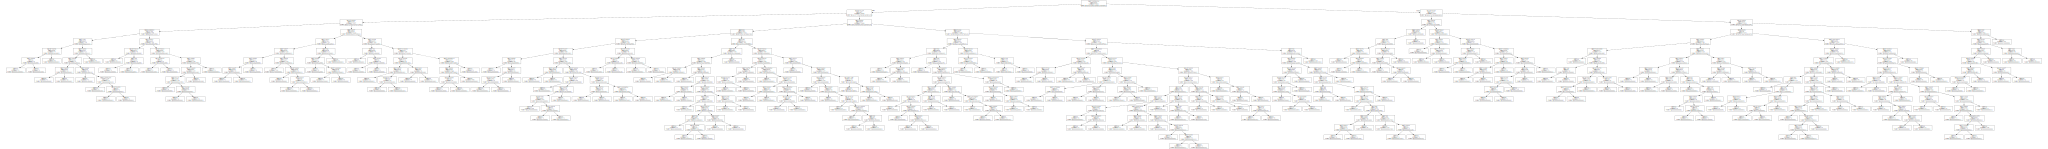

In [2]:
from sklearn import tree
dot_data = tree.export_graphviz(best_tree, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("best_tree")
graph

### 5 -  Comentários Finais

Os resultados obtidos não foram de forma alguma satisfatórios, pois a acurácia da classificação das strings completas foi consideravelmente baixa. Entretanto, é notável que a acurácia da classificação de caracteres individuais é bem superior.
De fato, a escolha dos atributos junto com a baixa qualidade das gravações gerou uma distribuição de dados que não pode ser compreendida de maneira satisfatoriamente constante por nenhum dos métodos testados.
Assim, as medidas a serem tomadas seriam a obtenção de um conjunto de atributos mais expressivo e/ou a escolha de um método de classificação diferente dos testados que possa se adaptar melhor a distribuição do problema.
